<a href="https://colab.research.google.com/github/francescostreet/ShreckCiuchino2026/blob/Branch-Sereno/Latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🌐 **Google Drive Connection**




In [1]:
# @title
from google.colab import drive
drive.mount("/gdrive")
current_dir = "/gdrive/My\\ Drive/Challenge1-Datasets"
%cd $current_dir

Mounted at /gdrive
/gdrive/My Drive/Challenge1-Datasets


## ⚙️ **Libraries Import**

In [2]:
# @title
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.8.0+cu126
Device: cuda


## ⏳ **Data Loading**

In [179]:
# @title
import pandas as pd

current_dir = '/gdrive/My Drive/Challenge1-Datasets'

X_train = pd.read_csv(os.path.join(current_dir, 'pirate_pain_train.csv'))
y_train = pd.read_csv(os.path.join(current_dir, 'pirate_pain_train_labels.csv'))
X_test = pd.read_csv(os.path.join(current_dir, 'pirate_pain_test.csv'))

## 🔎 **Exploration and Data Analysis**

In [180]:
# @title
# Define column names for the dataset
column_names = ['sample_index', 'time', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes'] + [f'joint_{ind:02d}' for ind in range(31)]

# Read the dataset into a DataFrame with specified column names
df = pd.read_csv('pirate_pain_train.csv', header=0, names=column_names)

# Merge df with y_train (the original labels DataFrame) to add the 'label' column
df = pd.merge(df, y_train, on='sample_index', how='left')

# Read the test dataset into a DataFrame with specified column names
df_test = pd.read_csv('pirate_pain_test.csv', header=0, names=column_names)

# Remove rows with any missing values
df.dropna(axis=0, how='any', inplace=True)

# Print the shape of the DataFrame
print(f"DataFrame shape: {df.shape}")

# Display the first 10 rows of the DataFrame
display(df.head(10))

DataFrame shape: (105760, 41)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30,label
0,0,0,2,0,2,1,two,two,two,1.094705,...,1.945042e-06,3.999558e-06,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5,no_pain
1,0,1,2,2,2,2,two,two,two,1.135183,...,6.765107e-07,6.019627e-06,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5,no_pain
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.698525e-07,1.446051e-06,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5,no_pain
3,0,3,2,2,2,2,two,two,two,0.938017,...,5.511079e-07,1.847597e-06,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5,no_pain
4,0,4,2,2,2,2,two,two,two,1.090185,...,1.735459e-07,1.552722e-06,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5,no_pain
5,0,5,2,0,2,1,two,two,two,1.146031,...,1.753837e-07,2.957340e-07,6.217311e-08,0.000007,0.006150,0.006444,0.033101,0.023767,0.5,no_pain
6,0,6,2,1,2,1,two,two,two,1.025870,...,1.772156e-07,1.976558e-06,1.576086e-06,0.000005,0.006495,0.006421,0.031804,0.019056,0.5,no_pain
7,0,7,2,2,2,2,two,two,two,1.038597,...,1.790415e-07,2.210562e-06,1.485741e-06,0.000000,0.015998,0.005397,0.035552,0.015732,0.5,no_pain
8,0,8,2,2,0,1,two,two,two,0.984251,...,1.165161e-06,3.030164e-07,5.416678e-07,0.000000,0.020539,0.008517,0.008635,0.015257,0.5,no_pain
9,0,9,0,2,2,2,two,two,two,1.054999,...,3.959558e-06,2.017157e-06,1.154349e-06,0.000007,0.007682,0.021383,0.034006,0.028966,0.5,no_pain


In [181]:
# Display a concise summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  object 
 7   n_hands        105760 non-null  object 
 8   n_eyes         105760 non-null  object 
 9   joint_00       105760 non-null  float64
 10  joint_01       105760 non-null  float64
 11  joint_02       105760 non-null  float64
 12  joint_03       105760 non-null  float64
 13  joint_04       105760 non-null  float64
 14  joint_05       105760 non-null  float64
 15  joint_06       105760 non-null  float64
 16  joint_07       105760 non-null  float64
 17  joint_08       105760 non-nul

# Data manipulation

In [182]:
#Define a dictionary for n_legs, n_hands, n_eyes
legs_dictionary = df['n_legs'].unique()
hands_dictionary = df['n_hands'].unique()
eyes_dictionary = df['n_eyes'].unique()
print("Unique strings in 'n_legs' column:")
print(legs_dictionary)
print("Unique strings in 'n_hands' column:")
print(hands_dictionary)
print("Unique strings in 'n_eyes' column:")
print(eyes_dictionary)

Unique strings in 'n_legs' column:
['two' 'one+peg_leg']
Unique strings in 'n_hands' column:
['two' 'one+hook_hand']
Unique strings in 'n_eyes' column:
['two' 'one+eye_patch']


In [183]:
n_cols = ['n_legs', 'n_hands', 'n_eyes']
mapping = {
    'two': 2,
    'one+peg_leg': 1,
    'one+hook_hand': 1,
    'one+eye_patch': 1
}

for col in n_cols:
    df[col] = df[col].map(mapping).astype(np.float32)
    df_test[col] = df_test[col].map(mapping).astype(np.float32)

for i in range(31):
  df[f'joint_{i:02d}']= df[f'joint_{i:02d}'].astype(np.float32)
  df_test[f'joint_{i:02d}']= df_test[f'joint_{i:02d}'].astype(np.float32)

# Drop the constant 'joint_30' column from both df and df_test
#if 'joint_30' in df.columns:
 #   df = df.drop('joint_30', axis=1)
  #  print("Dropped 'joint_30' from df.")
#if 'joint_30' in df_test.columns:
 #   df_test = df_test.drop('joint_30', axis=1)
  #  print("Dropped 'joint_30' from df_test.")

numeric_cols = df.select_dtypes(include='number').columns
numeric_cols_test = df_test.select_dtypes(include='number').columns

# Calcola la varianza per ogni colonna
variance = df[numeric_cols].var()
variance_test = df_test[numeric_cols].var()

# Seleziona solo le colonne con varianza > 0
cols_to_keep = variance[variance > 1e-3].index
cols_to_keep_test = variance[variance > 1e-3].index

# Crea un nuovo dataframe senza le colonne costanti
df_temp = df[cols_to_keep]
df_test_temp = df_test[cols_to_keep_test]

df = df_temp
df_test = df_test_temp

# Display updated DataFrame information to confirm the changes
df.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 26 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  float32
 7   n_hands        105760 non-null  float32
 8   n_eyes         105760 non-null  float32
 9   joint_00       105760 non-null  float32
 10  joint_01       105760 non-null  float32
 11  joint_02       105760 non-null  float32
 12  joint_03       105760 non-null  float32
 13  joint_04       105760 non-null  float32
 14  joint_05       105760 non-null  float32
 15  joint_06       105760 non-null  float32
 16  joint_07       105760 non-null  float32
 17  joint_08       105760 non-nul

In [184]:
# Merge df with y_train (the original labels DataFrame) to add the 'label' column
df = pd.merge(df, y_train, on='sample_index', how='left')

# Remove rows with any missing values
df.dropna(axis=0, how='any', inplace=True)
df_test.dropna(axis=0, how='any', inplace=True)

# Print the shape of the DataFrame
print(f"DataFrame shape: {df.shape}")
print(f"Test DataFrame shape: {df_test.shape}")

# Display the first 10 rows of the DataFrame
display(df.head(10))
display(df_test.head(10))

DataFrame shape: (105760, 27)
Test DataFrame shape: (211840, 26)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_08,joint_09,joint_10,joint_11,joint_12,joint_26,joint_27,joint_28,joint_29,label
0,0,0,2,0,2,1,2.0,2.0,2.0,1.094705,...,0.712989,1.050142,0.529555,0.447370,1.091046,0.017592,0.013508,0.026798,0.027815,no_pain
1,0,1,2,2,2,2,2.0,2.0,2.0,1.135183,...,0.722685,1.060313,0.446810,0.414432,1.045862,0.013352,0.000000,0.013377,0.013716,no_pain
2,0,2,2,0,2,2,2.0,2.0,2.0,1.080745,...,0.668043,1.011410,0.432499,0.431535,1.088221,0.016225,0.008110,0.024097,0.023105,no_pain
3,0,3,2,2,2,2,2.0,2.0,2.0,0.938017,...,0.702085,1.047223,0.478806,0.420665,1.096833,0.011832,0.007450,0.028613,0.024648,no_pain
4,0,4,2,2,2,2,2.0,2.0,2.0,1.090185,...,0.712197,1.044731,0.452906,0.476537,1.103968,0.005360,0.002532,0.033026,0.025328,no_pain
5,0,5,2,0,2,1,2.0,2.0,2.0,1.146031,...,0.646228,1.056162,0.547064,0.464709,1.143319,0.006150,0.006444,0.033101,0.023767,no_pain
6,0,6,2,1,2,1,2.0,2.0,2.0,1.025870,...,0.734906,1.042529,0.445074,0.474467,1.063973,0.006495,0.006421,0.031804,0.019056,no_pain
7,0,7,2,2,2,2,2.0,2.0,2.0,1.038597,...,0.636691,0.996125,0.468641,0.463964,1.145227,0.015998,0.005397,0.035552,0.015732,no_pain
8,0,8,2,2,0,1,2.0,2.0,2.0,0.984251,...,0.735875,0.986229,0.454055,0.478525,1.101066,0.020539,0.008517,0.008635,0.015257,no_pain
9,0,9,0,2,2,2,2.0,2.0,2.0,1.054999,...,0.612981,0.991768,0.506058,0.419849,1.050455,0.007682,0.021383,0.034006,0.028966,no_pain


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_07,joint_08,joint_09,joint_10,joint_11,joint_12,joint_26,joint_27,joint_28,joint_29
0,0,0,2,2,2,2,2.0,2.0,2.0,0.842535,...,0.950154,1.057105,1.061014,0.327447,0.253370,1.177406,0.019372,0.066324,0.022228,0.013576
1,0,1,2,2,2,2,2.0,2.0,2.0,0.898836,...,0.993922,1.105165,1.015887,0.331900,0.294067,0.985953,0.069747,0.080417,0.023650,0.038793
2,0,2,2,2,2,2,2.0,2.0,2.0,0.957765,...,0.982370,1.142910,1.032120,0.384204,0.272972,1.059171,0.054968,0.058811,0.027023,0.054202
3,0,3,1,2,2,2,2.0,2.0,2.0,0.832596,...,0.944723,1.057460,1.013968,0.381349,0.283902,1.132100,0.048695,0.047128,0.016151,0.024983
4,0,4,2,2,2,0,2.0,2.0,2.0,0.805972,...,0.948609,1.008785,0.974159,0.380332,0.311384,0.980731,0.019762,0.031116,0.015618,0.017931
5,0,5,2,2,0,2,2.0,2.0,2.0,0.805308,...,1.025050,1.050914,1.023095,0.310682,0.209324,0.936655,0.037433,0.034157,0.013880,0.033762
6,0,6,2,2,0,2,2.0,2.0,2.0,0.878559,...,0.926120,1.054816,1.030822,0.309517,0.300793,1.135787,0.076399,0.025877,0.049272,0.037960
7,0,7,2,2,2,2,2.0,2.0,2.0,0.847666,...,0.944574,1.041811,0.956960,0.376977,0.279399,1.022974,0.041566,0.055916,0.024414,0.026338
8,0,8,2,2,2,1,2.0,2.0,2.0,0.913557,...,1.022430,1.044301,1.014973,0.351867,0.279328,1.138381,0.040049,0.047536,0.018454,0.010675
9,0,9,2,2,2,0,2.0,2.0,2.0,0.880579,...,0.953042,1.080148,1.009135,0.312861,0.364807,1.049919,0.022977,0.096785,0.035494,0.023898


In [185]:
# Generate descriptive statistics for numerical columns in the DataFrame
df.describe()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_07,joint_08,joint_09,joint_10,joint_11,joint_12,joint_26,joint_27,joint_28,joint_29
count,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,...,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000
mean,330.000000,79.500000,1.633746,1.654851,1.653640,1.663134,1.990923,1.990923,1.990923,0.943095,...,0.837427,0.849700,0.909554,0.694840,0.691105,1.047288,0.041905,0.058244,0.049886,0.062273
std,190.814948,46.187338,0.682423,0.669639,0.666649,0.661994,0.094795,0.094795,0.094795,0.202049,...,0.237901,0.180488,0.180319,0.257571,0.262644,0.110833,0.060292,0.079820,0.060773,0.072597
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.122095,0.004671,0.107917,0.072233,0.107136,0.000203,0.000000,0.000000,0.000000
25%,165.000000,39.750000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.828277,...,0.781375,0.717725,0.825898,0.469688,0.460407,0.983152,0.009885,0.012652,0.016290,0.019638
50%,330.000000,79.500000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.005126,...,0.904914,0.831221,0.940954,0.690806,0.705150,1.057917,0.021898,0.031739,0.031843,0.039041
75%,495.000000,119.250000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.081039,...,0.984410,0.991104,1.030941,0.866482,0.851772,1.124471,0.048579,0.071051,0.058741,0.079518
max,660.000000,159.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.407968,...,1.361969,1.357288,1.388105,1.631494,1.464157,1.396754,1.223617,1.187419,1.412037,1.370765


# Graphs

Extracted 4 pain survey columns.
First 5 rows of the new pain_survey_df:
Counts of 0, 1, and 2 for each pain_survey column:
pain_survey_1: {0: 12352, 1: 14031, 2: 79377}
pain_survey_2: {0: 11760, 1: 12983, 2: 81017}
pain_survey_3: {0: 11529, 1: 13573, 2: 80658}
pain_survey_4: {0: 11361, 1: 12905, 2: 81494}
Total aggregated counts of 0, 1, and 2 across all pain_survey columns:
{0: 47002, 1: 53492, 2: 322546}


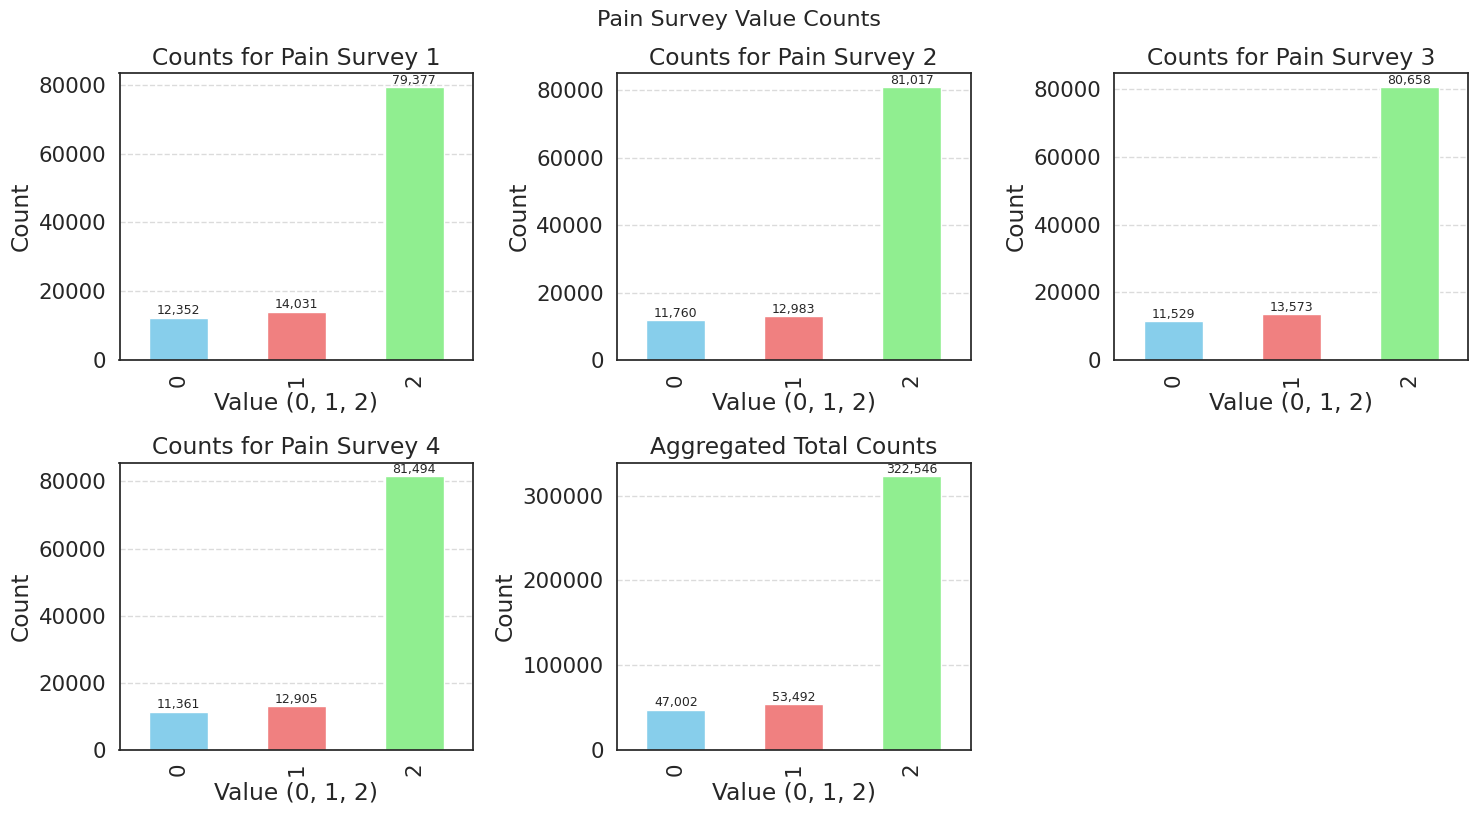

In [186]:
# @title
pain_survey_columns = [col for col in df.columns if col.startswith('pain_survey')]
pain_survey_df = df[pain_survey_columns]

print(f"Extracted {len(pain_survey_columns)} pain survey columns.")
print("First 5 rows of the new pain_survey_df:")
pain_survey_df.head()

pain_counts = {}
for col in pain_survey_columns:
    counts = pain_survey_df[col].value_counts().reindex([0, 1, 2], fill_value=0)
    pain_counts[col] = counts.to_dict()

print("Counts of 0, 1, and 2 for each pain_survey column:")
for col, counts in pain_counts.items():
    print(f"{col}: {counts}")

total_pain_counts = {0: 0, 1: 0, 2: 0}
for col, counts in pain_counts.items():
    for value, count in counts.items():
        total_pain_counts[value] += count

print("Total aggregated counts of 0, 1, and 2 across all pain_survey columns:")
print(total_pain_counts)

num_pain_surveys = len(pain_survey_columns)
num_plots = num_pain_surveys + 1 # +1 for the aggregated total

# Determine grid size for subplots dynamically
# For 5 plots, a 2x3 grid works well, leaving one empty spot
if num_plots <= 3:
    ncols = num_plots
    nrows = 1
elif num_plots <= 6:
    ncols = 3
    nrows = (num_plots + ncols - 1) // ncols
else:
    ncols = 4
    nrows = (num_plots + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten() # Flatten the array of axes for easy iteration

# Plot individual pain_survey column counts
for i, col in enumerate(pain_survey_columns):
    counts_series = pd.Series(pain_counts[col])
    counts_series.plot(kind='bar', ax=axes[i], color=['skyblue', 'lightcoral', 'lightgreen'])
    axes[i].set_title(f'Counts for {col.replace("_", " ").title()}')
    axes[i].set_xlabel('Value (0, 1, 2)')
    axes[i].set_ylabel('Count')
    axes[i].ticklabel_format(style='plain', axis='y') # Disable scientific notation
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    for p in axes[i].patches:
        axes[i].annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=9)

# Plot aggregated total counts
total_counts_series = pd.Series(total_pain_counts)
total_counts_series.plot(kind='bar', ax=axes[num_pain_surveys], color=['skyblue', 'lightcoral', 'lightgreen'])
axes[num_pain_surveys].set_title('Aggregated Total Counts')
axes[num_pain_surveys].set_xlabel('Value (0, 1, 2)')
axes[num_pain_surveys].set_ylabel('Count')
axes[num_pain_surveys].ticklabel_format(style='plain', axis='y') # Disable scientific notation
axes[num_pain_surveys].grid(axis='y', linestyle='--', alpha=0.7)
for p in axes[num_pain_surveys].patches:
    axes[num_pain_surveys].annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=9)

# Hide any unused subplots
for j in range(num_plots, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Pain Survey Value Counts', y=1.02, fontsize=16)
plt.show()

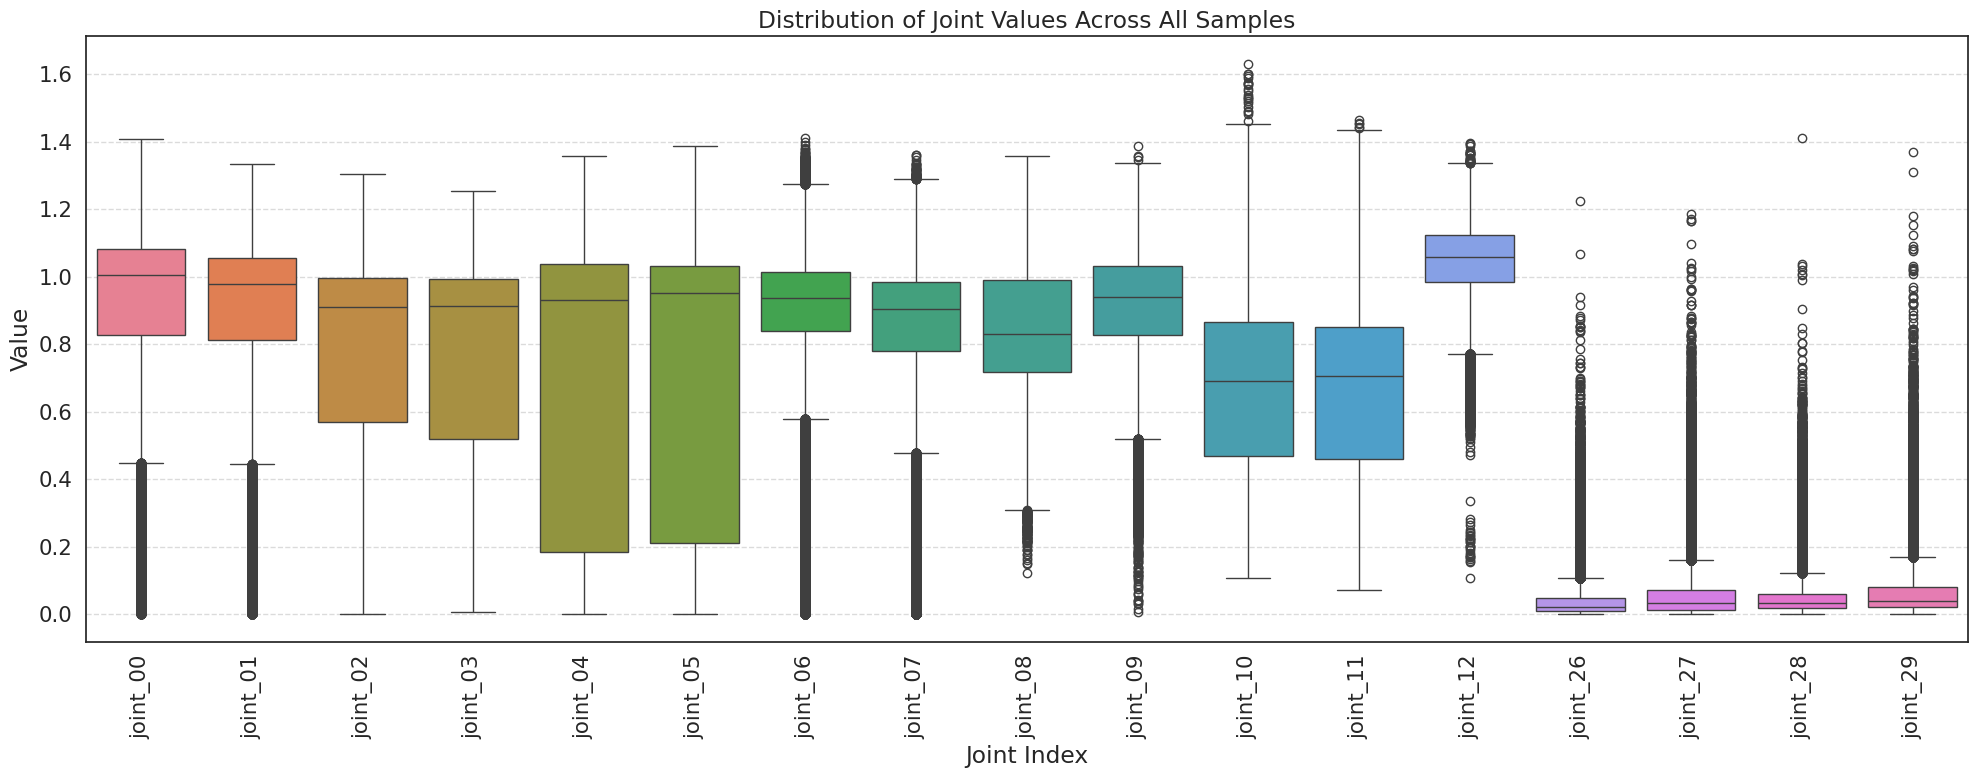

In [187]:
# @title
import matplotlib.pyplot as plt
import seaborn as sns

# Identify all joint columns
joint_columns = [col for col in df.columns if col.startswith('joint_')]

# Create a box plot for each joint column
plt.figure(figsize=(20, 8)) # Adjust figure size for better readability
sns.boxplot(data=df[joint_columns])
plt.title('Distribution of Joint Values Across All Samples')
plt.xlabel('Joint Index')
plt.ylabel('Value')
plt.xticks(rotation=90) # Rotate x-axis labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Data analysis & pre-processing





In [188]:
unique_pirates = df['sample_index'].unique()
n_pirates = len(unique_pirates)
print(f"Total number of pirates in the dataset: {n_pirates}")

random.seed(SEED) # Ensure reproducibility of shuffling
random.shuffle(unique_pirates)

# Define the number of users for validation and test sets
N_VAL_USERS = 135 # You can change this number

# Calculate the number of users for the training set
n_train_users = len(unique_pirates) - N_VAL_USERS

# Split the shuffled user IDs into training and validation
train_users = unique_pirates[:n_train_users]
val_users = unique_pirates[n_train_users:n_train_users + N_VAL_USERS]

# Split the dataset into training, validation, and test sets based on user IDs
df_train = df[df['sample_index'].isin(train_users)]
df_val = df[df['sample_index'].isin(val_users)]

# Print the shapes of the training, validation, and test sets
print(f'Training set shape: {df_train.shape}')
print(f'Validation set shape: {df_val.shape}')

Total number of pirates in the dataset: 661
Training set shape: (84160, 27)
Validation set shape: (21600, 27)


In [189]:
# Define the columns to be normalised
scale_columns = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes'] + [f'joint_{ind:02d}' for ind in range(13)] + ['joint_26', 'joint_27', 'joint_28', 'joint_29',]

# Calculate the minimum and maximum values from the training data only
mins = df_train[scale_columns].min()
maxs = df_train[scale_columns].max()

# Apply normalisation to the specified columns in all datasets
for column in scale_columns:
    # Normalise the training set and ensure float32
    df_train[column] = ((df_train[column] - mins[column]) / (maxs[column] - mins[column])).astype(np.float32)

    # Normalise the validation set and ensure float32
    df_val[column] = ((df_val[column] - mins[column]) / (maxs[column] - mins[column])).astype(np.float32)

    # Normalise the test set and ensure float32
    df_test[column] = ((df_test[column] - mins[column]) / (maxs[column] - mins[column])).astype(np.float32)

In [190]:
# === Estrarre feature statiche per sample_index (una riga per soggetto) ===
static_cols = ['n_legs', 'n_hands', 'n_eyes']

# Assicurati che df_train, df_val, df_test esistano già (li hai creati poco sopra)
static_train_df = df_train.groupby('sample_index')[static_cols].first().astype(np.float32)
static_val_df   = df_val.groupby('sample_index')[static_cols].first().astype(np.float32)
static_test_df  = df_test.groupby('sample_index')[static_cols].first().astype(np.float32)

# Controllo rapido (opzionale)
print("Static train shape (subjects):", static_train_df.shape)
print("Static val shape (subjects):", static_val_df.shape)
print("Static test shape (subjects):", static_test_df.shape)


Static train shape (subjects): (526, 3)
Static val shape (subjects): (135, 3)
Static test shape (subjects): (1324, 3)


In [191]:
# Display the first five rows of the training DataFrame
print(df_train.shape)
df_train.head()

(84160, 27)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_08,joint_09,joint_10,joint_11,joint_12,joint_26,joint_27,joint_28,joint_29,label
0,0,0,1.0,0.0,1.0,0.5,1.0,1.0,1.0,0.777507,...,0.478382,0.755707,0.276742,0.269510,0.762947,0.014211,0.011376,0.018978,0.020291,no_pain
1,0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.806256,...,0.486231,0.763060,0.222432,0.245846,0.727910,0.010745,0.000000,0.009473,0.010006,no_pain
2,0,2,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.767592,...,0.441994,0.727711,0.213039,0.258133,0.760757,0.013093,0.006830,0.017065,0.016856,no_pain
3,0,3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.666220,...,0.469554,0.753597,0.243433,0.250324,0.767434,0.009502,0.006274,0.020264,0.017981,no_pain
4,0,4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.774297,...,0.477740,0.751796,0.226434,0.290464,0.772967,0.004212,0.002132,0.023389,0.018477,no_pain


In [192]:
# Display the first five rows of the test DataFrame
print(df_test.shape)
df_test.head()

(211840, 26)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_07,joint_08,joint_09,joint_10,joint_11,joint_12,joint_26,joint_27,joint_28,joint_29
0,0,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.598405,...,0.697633,0.756975,0.763566,0.144088,0.130134,0.829913,0.015666,0.055856,0.015742,0.009904
1,0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.638393,...,0.729769,0.795884,0.730947,0.147011,0.159372,0.681456,0.056841,0.067724,0.016749,0.028300
2,0,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.680247,...,0.721287,0.826442,0.742680,0.181341,0.144217,0.738230,0.044761,0.049528,0.019138,0.039542
3,0,3,0.5,1.0,1.0,1.0,1.0,1.0,1.0,0.591346,...,0.693645,0.757262,0.729559,0.179467,0.152069,0.794781,0.039633,0.039690,0.011438,0.018225
4,0,4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.572436,...,0.696499,0.717856,0.700784,0.178800,0.171814,0.677406,0.015984,0.026205,0.011061,0.013081


In [193]:
# Define a mapping of activity names to integer labels
label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2,
}

# Map activity names to integers in the training set
df_train['label'] = df_train['label'].map(label_mapping)

# Map activity names to integers in the validation set
df_val['label'] = df_val['label'].map(label_mapping)

# Model definition

In [194]:
WINDOW_SIZE= 45 # I wouldn't exceed 180 since each "activity" is composed by 180 measures, by
STRIDE= 15 # random first guess

In [195]:
# Define a function to build sequences from the dataset
def build_sequences(df, window=WINDOW_SIZE, stride=STRIDE, return_labels=True, feature_columns_to_extract=None):
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0

    dataset = []
    labels = []
    sequence_ids = [] # New list to store sample_index for each sequence

    # Always use 'sample_index' as the ID column as per user request
    id_column = 'sample_index'

    # Always use 'label' as the label column as per user request
    label_column = 'label'

    # Use provided feature_columns_to_extract or default to all 'joint_' columns if not specified
    if feature_columns_to_extract is None:
        feature_columns_to_extract = [col for col in df.columns if col.startswith('joint_')]

    if not feature_columns_to_extract:
        raise ValueError("No feature columns provided or found for sequence building.")

    for current_id in df[id_column].unique():
        # Extract sensor data for the current ID using the specified feature columns
        temp_data = df[df[id_column] == current_id][feature_columns_to_extract].values

        # Handle cases where a user might have no data points (empty temp_data)
        if len(temp_data) == 0:
            continue

        current_label = None
        if return_labels:
            if label_column in df.columns:
                current_label = df[df[id_column] == current_id][label_column].values[0]
            else:
                # If labels are expected but the column is missing, raise an error
                raise KeyError(f"Label column '{label_column}' not found in DataFrame for ID {current_id} when labels are expected (return_labels=True).")
        # If return_labels is False, current_label remains None or is not used for appending

        # Calculate padding length to ensure full windows
        padding_len = window - (len(temp_data) % window)
        if padding_len == window: # If len(temp_data) is a multiple of window, no padding needed
            padding_len = 0

        # Create zero padding and concatenate with the data
        if padding_len > 0:
            padding = np.zeros((padding_len, temp_data.shape[1]), dtype='float32')
            temp_data = np.concatenate((temp_data, padding))

        # Build feature windows and associate them with labels
        idx = 0
        while idx + window <= len(temp_data):
            dataset.append(temp_data[idx:idx + window])
            if return_labels:
                labels.append(current_label) # Append the actual label
            else:
                labels.append(-1) # Append a placeholder if not returning labels, for shape consistency in list before converting to numpy
            sequence_ids.append(current_id) # Append the current_id for each sequence
            idx += stride

    dataset_np = np.array(dataset)
    labels_np = np.array(labels, dtype=np.int64) if return_labels else np.empty(0, dtype=np.int64)
    sequence_ids_np = np.array(sequence_ids)

    return dataset_np, labels_np, sequence_ids_np

In [196]:
# Get the list of actual joint columns present in the preprocessed dataframes
actual_joint_columns_global = [col for col in df_train.columns if col.startswith('joint_')]

# Generate sequences and labels for the training set
X_train, y_train, seq_ids_train = build_sequences(df_train, WINDOW_SIZE, STRIDE, feature_columns_to_extract=actual_joint_columns_global)

# Generate sequences and labels for the validation set
X_val, y_val, seq_ids_val     = build_sequences(df_val, WINDOW_SIZE, STRIDE, feature_columns_to_extract=actual_joint_columns_global)

# Generate sequences for the test set (without labels)
# df_test does not contain the 'label' column, so we set return_labels=False
X_test, _, seq_ids_test       = build_sequences(df_test, WINDOW_SIZE, STRIDE, return_labels=False, feature_columns_to_extract=actual_joint_columns_global)

# Print the shapes of the generated datasets and their labels
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"seq_ids_test shape: {seq_ids_test.shape}")

X_train shape: (5260, 45, 17), y_train shape: (5260,)
X_val shape: (1350, 45, 17), y_val shape: (1350,)
X_test shape: (13240, 45, 17)
seq_ids_test shape: (13240,)


In [197]:
def build_static_array_from_seq_ids(sequence_ids, static_df):
    """
    sequence_ids: array/list of sample_index for each window (in same order as X)
    static_df: DataFrame indexed by sample_index with columns static_cols
    Returns: numpy array shape (n_windows, n_static_features)
    """
    # Some seq ids might not be sorted; use .loc to fetch rows by index
    static_list = [ static_df.loc[idx].values for idx in sequence_ids ]
    return np.vstack(static_list).astype(np.float32)

# Create static arrays aligned with each window
X_train_static = build_static_array_from_seq_ids(seq_ids_train, static_train_df)
X_val_static   = build_static_array_from_seq_ids(seq_ids_val, static_val_df)
X_test_static  = build_static_array_from_seq_ids(seq_ids_test, static_test_df)

print("X_train_static shape:", X_train_static.shape)
print("X_val_static shape:", X_val_static.shape)
print("X_test_static shape:", X_test_static.shape)


X_train_static shape: (5260, 3)
X_val_static shape: (1350, 3)
X_test_static shape: (13240, 3)


In [198]:
# Define the input shape based on the training data
input_shape = X_train.shape[1:]

# Define the number of classes based on the categorical labels
num_classes = len(np.unique(y_train))

In [199]:
# Convert to tensors and create datasets with sequence + static + label
train_ds = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(X_train_static).float(),
    torch.from_numpy(y_train).long()
)
val_ds = TensorDataset(
    torch.from_numpy(X_val).float(),
    torch.from_numpy(X_val_static).float(),
    torch.from_numpy(y_val).long()
)
# test dataset (no label)
test_ds = TensorDataset(
    torch.from_numpy(X_test).float(),
    torch.from_numpy(X_test_static).float()
)


In [200]:
# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 32 #in this course don't exceed this, isn't useful

In [201]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [202]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [203]:
# Get one batch from the training data loader
for xb, x_static_batch, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Static features batch shape:", x_static_batch.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([32, 45, 17])
Static features batch shape: torch.Size([32, 3])
Labels batch shape: torch.Size([32])


# 🛠️ Model Building

In [204]:
# @title
def recurrent_summary(model, input_size, static_input_size=0):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
        static_input_size (int): Number of static features, if any. Defaults to 0.
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create dummy input tensors with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)
    dummy_static_input = None
    if static_input_size > 0:
        dummy_static_input = torch.randn(1, static_input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            if dummy_static_input is not None:
                model(dummy_input, dummy_static_input)
            else:
                model(dummy_input) # If no static input, call with only dynamic input
        except Exception as e:
            print(f"Error during dummy forward pass in recurrent_summary: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [205]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',
            bidirectional=False,
            dropout_rate=0.2,
            static_size=0
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.static_size = static_size


        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the hidden_to_classify (after RNN, before potential reduction)
        if self.bidirectional:
            classifier_input_size_from_rnn = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size_from_rnn = hidden_size


        # Calculate input size for the final classifier, incorporating static features
        final_classifier_input_size = classifier_input_size_from_rnn + self.static_size

        # Final classification layer as a small FFN with Leaky ReLU
        # Using final_classifier_input_size as a hidden layer for simplicity
        self.classifier = nn.Sequential(
            nn.Linear(final_classifier_input_size, final_classifier_input_size), # Hidden layer
            nn.LeakyReLU(), # Activation for hidden layer
            nn.Linear(final_classifier_input_size, num_classes) # Output layer
        )


    def forward(self, x, x_static=None):
        """
        x shape: (batch_size, seq_length, input_size)
        x_static shape: (batch_size, static_size) (optional)
        """

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x)

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, :, :]) and bwd (hidden[-1, 1, :, :])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1) # take the last layer and feed it into the classifier
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        if x_static is not None:
            # ensure same dtype/device
            x_static = x_static.to(hidden_to_classify.dtype)
            x_static = x_static.to(hidden_to_classify.device)
            hidden_to_classify = torch.cat([hidden_to_classify, x_static], dim=1)

        # Get logits from the sequential classifier
        logits = self.classifier(hidden_to_classify)
        return logits

# Network and training hypeprparameters

In [206]:
LEARNING_RATE = 1e-3
EPOCHS = 400
PATIENCE = 50

HIDDEN_LAYERS = 2
HIDDEN_SIZE = 64

DROPOUT_RATE = 0.3
L1_LAMBDA = 0
L2_LAMBDA = 0

LABEL_SMOOTHING= 0

# Calculate class weights for the imbalanced dataset
# Ensure y_train (numpy array) contains integer labels
class_labels = np.unique(y_train) # Use the global y_train (numpy array) that has integer labels
class_weights_np = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=y_train
)
class_weights_tensor = torch.tensor(class_weights_np, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=LABEL_SMOOTHING)

In [207]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [208]:
# @title
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=L1_LAMBDA, l2_lambda=L2_LAMBDA):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, static_inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, static_inputs, targets = inputs.to(device), static_inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs, static_inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [209]:
# @title
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, static_inputs, targets in val_loader:
            # Move data to device
            inputs, static_inputs, targets = inputs.to(device), static_inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs, static_inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [210]:
# @title
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty and has variance before adding a histogram
            if param.numel() > 0 and param.data.std() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty, finite, and has variance before adding a histogram
                if param.grad.numel() > 0 and torch.isfinite(param.grad).all() and param.grad.data.std() > 0:
                    writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [211]:
# @title
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=L1_LAMBDA, l2_lambda=L2_LAMBDA, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

In [212]:
# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1],
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=True,
    rnn_type='LSTM',
    static_size=X_train_static.shape[1]
    ).to(device)

# The current recurrent_summary does not deeply inspect nn.Sequential modules.
# I will manually provide the details for the new architecture.
# Parameters updated after removing the rnn_output_reducer
# If bidirectional: rnn_output_dim = HIDDEN_SIZE * 2 = 64 * 2 = 128
# Classifier input = rnn_output_dim + static_size = 128 + 3 = 131
# Classifier: (131 * 131 + 131) + (131 * 3 + 3) = 17162 + 396 = 17558
# Total parameters: 148,480 (RNN) + 17,558 (Classifier) = 166,038

print("-------------------------------------------------------------------------------")
print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
print("===============================================================================")
print(f"{'rnn (LSTM)':<25} {'[[-1, 60, 128], [4, -1, 64]]':<28} {'148,480':<18}")
print(f"{'classifier (Sequential)':<25} {'[-1, 3]':<28} {'17,558':<18}")
print("===============================================================================")
print(f"Total params: 166,038")
print(f"Trainable params: 166,038")
print(f"Non-trainable params: 0")
print("-------------------------------------------------------------------------------")

# Set up TensorBoard logging and save model architecture
experiment_name = "LatestConfiguration-ws45str15" # Updated experiment name
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
# The `writer.add_graph` call needs to be updated to pass the static_inputs as well
x_static_dummy = torch.randn(1, X_train_static.shape[1]).to(device)
writer.add_graph(rnn_model, (x, x_static_dummy))

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (LSTM)                [[-1, 60, 128], [4, -1, 64]] 148,480           
classifier (Sequential)   [-1, 3]                      17,558            
Total params: 166,038
Trainable params: 166,038
Non-trainable params: 0
-------------------------------------------------------------------------------
Cannot insert a Tensor that requires grad as a constant. Consider making it a parameter or input, or detaching the gradient
Tensor:
Columns 1 to 100.01 *
-6.4758  0.9956  0.9575 -6.7566 -2.6382 -3.3386 -4.1626 -5.2979 -1.9608  0.1328
  5.3589 -4.6417  2.0950  0.9270  0.1886  8.3618  5.6366 -8.2458 -8.3130 -8.0627
 -2.4323 -2.2171 -5.8868  7.1167 -5.1178  7.0007  3.7872  6.0059  0.0314  6.7017
  2.3880 -0.4589 -1.3275  0.6676  2.7863  2.8687  0.5726  1.7014 -1.2550 -2.5421
  8.5205  1.6693 -3.3203 -8.3435 -7.9529 -5.0446  8.0444  2.0187 -7.6

RuntimeError: Cannot insert a Tensor that requires grad as a constant. Consider making it a parameter or input, or detaching the gradient
Tensor:
Columns 1 to 100.01 *
-6.4758  0.9956  0.9575 -6.7566 -2.6382 -3.3386 -4.1626 -5.2979 -1.9608  0.1328
  5.3589 -4.6417  2.0950  0.9270  0.1886  8.3618  5.6366 -8.2458 -8.3130 -8.0627
 -2.4323 -2.2171 -5.8868  7.1167 -5.1178  7.0007  3.7872  6.0059  0.0314  6.7017
  2.3880 -0.4589 -1.3275  0.6676  2.7863  2.8687  0.5726  1.7014 -1.2550 -2.5421
  8.5205  1.6693 -3.3203 -8.3435 -7.9529 -5.0446  8.0444  2.0187 -7.6294 -0.1113
  4.9561 -0.7313 -1.7853 -1.9150  1.3641  3.7415 -2.5513  7.2388  8.5571 -7.6355
  8.4961 -0.5371 -3.9001 -6.8298 -7.0618  6.7871  0.8415 -1.6068 -4.0985  4.5288
 -4.1321 -3.5278  5.9326 -0.0875 -3.2318  6.3110 -4.2938  2.0950  0.9560 -5.9052
  5.1941 -2.0279  8.0994 -1.5884  1.1642 -0.1963 -7.3608  6.9336  5.7617  7.7209
 -1.2543  1.4290 -7.2571 -2.5391  7.1411 -6.9641  5.8411 -5.4047  1.8799 -2.2018
 -0.3471  7.8552  5.4138  0.9705  1.5900  4.4067 -1.8173 -6.5979 -2.0447 -7.7698
  6.4697  5.4321  3.0365  5.1117  6.0333  4.3091 -8.0200  2.7115  4.7760 -1.3947
  5.9814  8.4290 -7.2449 -5.5084 -4.6600 -3.2013  8.2642  1.5053 -2.8152  6.0883
 -4.2053  1.5343 -5.7831  4.7852 -0.6325  6.7261 -6.3049  1.1238  7.9041 -8.6670
  4.0009  2.3605  8.6365  5.2826 -2.4078  6.9031 -3.5675  6.3293  7.9468  8.4778
  6.1554 -5.9448 -8.3496  0.5070  3.1174 -2.0126 -6.4941  4.1412  8.1177 -3.7231
 -3.7445 -2.8610 -5.9662  8.3679  3.6987 -4.2023 -7.5073 -5.6335  6.3660  5.3925
  1.2283  4.1809  5.2948  4.7424 -3.9764 -1.0262 -1.0384 -2.0905  5.9204  2.4658
  1.6449  7.5684  4.0680 -4.9561 -1.5015 -8.7158 -0.6393  5.2460  0.1383  6.9275
  8.7341  0.0283  8.4229 -7.6050 -0.8545  7.3486  6.6772 -6.4941 -3.0884  2.4490
 -3.0930  6.0669 -7.8186  4.1046 -1.3733  5.8258 -8.3679 -1.5839  6.5125  5.0049
  3.1082  8.0811  7.0251 -8.3496  2.6535  0.3038  5.7068  2.6138  1.4511  1.7914
  3.0334  4.7394  0.8469 -2.7588  3.6011 -2.2995  6.6284 -5.1086 -1.8539 -7.0496
 -6.0333 -6.8787 -0.5798  3.7262  1.7227 -2.7420 -5.7709  4.3732  0.7565  4.4830
  5.0079  7.0679  7.6721  2.3026 -0.6985  3.7567 -4.1443  0.9674 -5.1117  6.2012
  6.0120 -2.5604 -3.0609 -4.3335 -8.0017  2.1606  8.0261 -2.0370  2.3361  4.1229
  5.9906 -7.4768 -2.9022  4.4952  6.7505 -7.7698 -8.0444 -0.1476  0.1602 -2.5681
 -7.8918 -5.2277  6.1890 -1.1436 -0.8118 -8.6243 -3.2684  0.1726 -4.1504  0.4848
 -8.4656  0.4971 -0.0046 -1.2154 -4.6997 -6.1829  4.1901  6.3660 -5.9540  1.6693
  0.7397  0.3273 -7.0190 -1.8661  0.1032 -4.8859 -2.3346  6.8604  3.4454 -6.4758
 -7.4951 -5.0079 -6.7810  2.0126  7.5989  2.1088  7.1838 -1.0719  2.6260 -0.6218
  2.4261  8.6304 -6.0669  6.9092  2.7084 -3.4790 -3.3051  4.1107 -7.7148 -8.1055
  1.2871  7.1960  2.0905 -7.5012  5.1910  7.3547 -7.3486 -7.8186 -8.5449  0.6115
  1.5015 -1.8524  0.2705 -5.1697 -5.4596 -1.4557 -2.8366 -6.0699 -2.1500  1.5579
  6.1249 -6.5430 -5.9235  5.9326  3.4515  8.3374 -0.2653  5.5634  2.2934 -1.2138
 -1.4526 -0.9819 -8.2336  7.3608 -1.1261 -4.1473 -8.6487 -3.6133 -7.9529  0.0331
 -2.1347  6.6406 -4.8401  7.9895 -3.6255 -5.4688 -3.7811 -6.5430 -6.8115 -7.9468
  6.4270  5.6580  5.9479  0.9720 -7.0251  2.3315 -4.3549  3.5858 -3.7628 -3.5889
 -4.9591 -4.8035  2.5558 -3.3142 -2.6764 -3.7933 -2.2247  7.3242 -2.7176 -3.0075
 -2.2369 -3.5980  5.8807  5.6580 -7.4646 -8.3862  1.9516 -4.6844 -4.3457  0.9125
 -3.2532 -6.2073  1.3275  6.7627  6.2347  8.4229 -0.1849 -8.0933 -3.5736  0.7507
  5.0598  5.3101 -7.0679  6.1462 -7.2144 -3.6804 -5.5023  5.5420  8.0322 -1.0201
 -5.8655  5.5054  2.3193 -6.0730 -5.7556  0.3471  8.2581  5.4749 -8.7036 -1.6968
  2.0050  7.2388 -8.0688 -8.0750 -7.4219 -3.9429 -2.0691 -8.3496 -8.6304  1.0010
 -4.9042 -8.5693  1.4107  7.3730  1.4702 -5.5511 -7.6172  8.3069  3.3478 -3.4302
 -3.6499  4.0436  3.3569  7.3669 -0.3805  5.5176  6.9397  0.4421 -0.5344 -8.4045
 -0.9987  0.0564  2.8503 -0.7133  3.5431  3.9673 -4.7180 -8.3008  2.8519  0.0662
  7.1655 -4.5349 -3.6194 -1.3268 -0.0401  2.2018 -4.3152  2.0950  3.7354 -5.9448
 -4.6753 -1.0239 -3.3966 -4.2999 -5.4260 -7.0312 -1.1864 -0.2258 -8.5999 -4.3091
 -5.4382 -6.1920  1.2901 -2.2598  2.4185 -2.9053 -6.5796  6.7078 -5.8380  6.3538
  6.8665  4.1656 -0.1727 -3.6438 -6.1829  1.5480  0.8957 -2.4933  5.8105 -2.7298
  0.8545  1.6571 -5.0385 -7.2632  4.1473 -5.6824 -0.7046  0.8766 -4.1382 -1.3153
 -3.4546  1.5358 -0.0154 -8.3069 -7.2021 -2.2324 -3.8605  5.0018 -2.5253 -4.9683
 -8.4717 -7.7759  2.8122 -8.5938 -3.2104  3.3386  3.7018 -1.6464 -8.2397 -5.9937
  0.7252 -1.6357  4.5563  4.2877 -1.9592 -2.5681 -6.2500  1.7471 -3.5522  2.3209
  3.1250 -3.7811  5.8411  0.8636 -1.4236 -2.1591 -4.4952 -1.4343 -1.5869 -6.6650
 -6.5002  2.1729  3.1403  1.0002  0.2892  4.6967  4.7974  0.0539 -3.9703 -2.9144
  4.1626  1.5472 -0.8255 -2.9739  3.9246 -0.3099 -2.9053 -6.2469 -5.8075 -0.6588
 -8.6121  7.6782  6.3293  5.5206 -2.2018 -5.1331 -8.0627 -3.3844 -5.7922 -6.1096
  8.3801 -8.5876  8.2153  4.8248 -8.3313 -0.8522  6.4758 -6.7688 -4.4525  6.1493
  5.7587 -0.5661  6.2988 -1.2215  1.0712 -0.4208  2.9800 -5.6122  6.4941 -2.0813
 -2.3376  1.6861  1.5015  2.7603  5.1392  2.2308 -1.6815  6.3538 -4.0375  4.8279
  6.4331  7.8796 -5.7922 -0.2531  8.6548 -3.6255  8.6548  2.8137  6.2042  3.1708
  0.3206 -7.0251  3.8849  8.0444  2.7008 -0.8316 -4.5685 -3.8269 -5.8990 -0.3689
 -5.9296  6.9458 -7.4341 -8.5144  4.6906  4.0375 -6.2256 -5.1392  8.1848 -5.2765
  5.5206 -2.2552  6.6772  0.2474  8.2764 -1.1787 -8.5144 -1.0239  8.2581  4.2419
  1.8860  7.5256 -7.5073 -3.4424  1.5900  5.3253 -8.4717  0.8499  0.5589 -1.9806
 -5.4779 -0.2241 -1.6708 -2.2247 -6.5002 -5.3925 -7.4097  0.2821 -4.2572  6.5735
 -1.4771 -5.3070  0.2991 -3.5217 -7.8430 -7.1533  3.1799  5.0110 -4.0527  3.1342
 -2.1072 -1.9043 -5.5756 -4.5898  2.7802 -4.1168  2.2781 -3.8757 -4.7211 -7.9529
 -4.4250  5.0079  0.1042 -8.5510 -0.1927 -4.3976  2.3926 -0.4688  3.5278 -8.5571
 -8.6914 -0.4799  8.4106  4.4312  0.8835  4.3488  3.7262 -7.0374  8.0505 -7.0374
 -6.3049  7.8186  0.1489 -6.1554  6.5857 -0.8133  3.4637 -1.1017  5.8594  2.3575
 -7.1289 -7.8003  0.3220 -3.5583 -4.8248  5.5023 -2.7008  7.8796  4.3427 -6.6040
 -0.4177 -0.1649 -7.0374 -7.7942 -0.5501  1.2253  6.0791  3.2532  0.6611 -6.0150
 -2.5345  0.6157 -6.6956  6.5979  3.4393  1.9119  1.1368  3.0273  5.7892 -5.4230
  5.8411 -0.9003  6.2622  5.5450  8.2642 -5.3864  7.7332  3.4851  4.5990  5.3772
 -0.2539  3.9612 -6.4941  6.6650  5.7617 -0.0949 -4.1260  1.2329  2.2690  6.5491
  5.6091  1.5961  6.2866 -5.7953 -0.7702 -3.5767 -5.6335 -3.8422 -1.8753 -8.1055
  1.4786 -1.6571 -4.3396  4.0863 -4.3030  2.3499 -7.9346  5.2124  2.3468  5.2155
  7.6904  6.4697  0.0668  4.8737 -4.2877 -7.1594 -8.0200 -4.2816  0.0707  5.7007
  7.2815 -2.2003  8.3252 -2.4338  8.5266  3.8696 -4.2969 -7.3242  5.5939  8.7341
 -5.5786 -2.1545 -8.0078  4.5654 -4.7211  5.8594 -3.6652  2.3941 -5.9418 -0.8339
  2.6474 -2.8015  3.5919  6.4636 -4.4067 -7.5500 -4.3152 -1.8356  5.2948  3.4149
 -1.6174 -3.6743  7.3486 -1.5518  6.5979  7.9529 -3.8208 -6.2408 -2.7237 -5.4413
 -4.8492  4.6875  0.6115 -5.7526 -7.7026  6.8481 -6.3843  6.1798  6.5430  5.2917
 -7.2449  5.6915  5.2277 -1.7609  3.9490 -0.8331 -5.1849 -5.7800 -5.5267 -2.4673
  4.5807  1.0880 -5.3833  4.2328 -8.6060 -6.5125 -3.9490  5.5450 -7.8613  6.8420
  2.7939  8.0200 -1.2955 -6.4636  6.3293 -8.4412  7.0923 -4.9347 -6.8481  6.9458
  7.6965 -5.7007 -2.5070  5.7037  8.2764 -5.9387  7.7209 -4.4556 -3.8391  5.2032
  5.3741 -4.5898 -0.4593 -6.3110 -6.2103 -1.7899  3.3203  3.2074 -3.1525 -0.1689
 -1.6830  0.6092 -0.2001  2.1713  3.7109  5.9814 -7.0801 -0.4860  4.2664 -1.3451
 -6.5735  7.3975  4.8798  5.6519 -8.5754  0.5005  1.6586  4.9164 -7.6111 -7.4768
 -4.6356  0.5547 -1.1238  2.5467  3.3478 -5.1849 -2.4338  5.3406  6.7749 -4.0375
  3.0380  7.0251  1.8692  3.5461 -0.8377  3.5919 -1.1215 -3.9520 -4.1962 -3.7476
 -8.6853 -1.9058 -8.0383 -2.4429  4.9561 -8.3191 -8.3008 -8.5510 -7.8918 -8.4045
  5.6732  5.4291  4.9164  2.7145 -7.8430  6.7261 -5.2734  7.8064 -1.2527  0.2052
  6.9214  4.4037  4.5898 -3.3051  4.1473  3.3081 -3.1342 -3.1235 -0.7671  3.0838
  2.8137 -6.7566  1.8234  8.0933 -2.3209  0.7660 -2.6398  6.9214 -4.3793 -0.1118
  7.5439  0.4395 -3.3386  5.0842 -6.2988  2.8595  3.9886  6.8726 -1.3573  2.9144
 -5.9662  5.4474 -8.0139  7.0007 -0.5161 -1.1322  6.2408  4.7058  7.5623 -2.5742
 -3.2074 -5.7007  6.3232 -0.4860 -4.2053 -0.5676  7.7454 -4.6692 -8.1848 -5.3711
 -6.3538  5.3955  2.2873 -0.3286 -8.0017  5.9570  3.1525  7.2266  3.6560  7.9956
  6.0760  1.2863  4.0833  6.3477  6.5186 -8.2336  1.9394  7.2388  5.5176 -1.2878
 -2.7420  4.2267  3.5126  8.4778 -2.3026 -8.5327  2.8198  0.6306  4.0070 -1.4938
 -7.0190  7.8979  7.2327  7.6416 -5.2643 -1.0956  1.7517  2.7298 -4.3549 -7.7087
 -6.3293 -6.8115  1.3878  3.5583 -7.6355  6.5369 -6.8665  3.5248 -6.0242  3.2166
 -0.5749  8.5388 -7.7332  2.3560  3.5828  3.6072 -0.8873 -5.8380 -4.9164  0.9132
 -6.1340 -6.0089  0.5100  0.9491 -1.4275 -5.0140 -3.5004 -0.4387 -6.4270  4.7241
  3.3325 -1.9806  7.5073  4.9622  7.9590  1.0185 -6.7444 -4.6967  8.6243 -8.3191
 -7.7515 -2.4902  3.6469 -0.6592  1.5305 -2.6672  3.1403  1.7593  2.8198 -1.7365
 -4.1687 -1.5038  0.9422  0.6001  6.9580 -1.7410 -8.4412  0.8484 -8.5938  7.1350
 -0.6477 -6.8420 -7.1289  2.1530  5.3406 -5.5969  6.4087 -3.0594 -1.9623 -8.2275
 -6.6284  6.0913 -4.3152 -2.2507  2.4445  6.6162 -4.9561 -7.3120  2.1866  4.0558
  6.6040  8.5205 -1.1909  5.6305 -3.2288  1.9424  4.6509 -7.1777 -4.4098 -2.6108
  7.4158  1.9424 -8.5266  2.6688  3.2227  3.1708  3.1677  6.9763  4.1168 -5.7739
 -0.8209  3.5797 -2.1576 -6.4514 -2.3163  6.7505  7.9895  5.2460  3.3386 -5.9906
 -2.3254  6.7932  1.4908  3.5278 -8.6792  2.4323  8.1116 -6.6467 -0.1323  1.7273
  2.6199 -4.5105  8.0811  1.6144  0.1466 -6.6528  5.8472 -5.8289 -5.8258  7.3364
 -5.6183 -3.6499 -5.6152 -2.9388  3.6896 -1.8631  5.0262  3.8391  1.8021 -6.1829
  7.0984 -7.8796  3.9154 -4.1504 -7.1045 -2.7390 -5.8899  7.2083  4.3823 -3.5797
 -1.0071  5.3925  3.4607  3.6102  0.8621  2.5909 -7.2693  1.4000 -1.9104 -5.7861
 -2.5055 -8.6304  1.3718  6.0181 -6.9824  5.5756 -5.7800  4.1931 -3.7140 -6.9397
  5.5786 -3.7720  1.0780  2.0279  5.2124  4.0131 -8.2031  0.3828  5.0629 -7.8674
  8.1238 -5.1086  7.0801 -1.4793  2.7405 -3.3661 -4.4769  0.0328 -2.0157  6.6101
 -3.7567  0.7896 -6.4758  4.8004 -1.1459  7.6050  1.6830  0.4440 -4.0070  8.2703
  3.5767  7.8674  7.6965  6.5491 -6.5918  1.0201  6.8481 -4.2511  0.4749 -3.6163
  0.0479 -2.6718  2.6917 -2.2919 -1.4420  1.3954  3.1738 -1.3466 -5.0201 -8.6060
  7.0740  3.9978 -6.0577  2.8214 -7.1045 -6.3293 -7.4768  2.8107  4.2877  2.5162
 -1.3290  5.4840 -0.9628 -1.1147 -5.9174  5.5023  0.1175 -7.9285  4.8981 -8.1787
  0.7309  6.1371  4.8401 -5.4291 -4.5776  7.7759  4.6417 -2.5253  5.3345 -8.4778

Columns 11 to 200.01 *
 7.2815 -3.2654  1.7914 -0.3929  0.2954 -5.7251 -4.4861  7.6965  5.2612 -8.6548
 -2.3911  4.5410  5.4871 -4.8340 -1.0643  1.8677  7.0923  0.2892 -8.1909  0.5318
 -3.5889 -1.2245 -2.8366 -5.4901  5.2490  1.5732  1.1719  6.2561 -2.5742 -5.8594
 -2.4841 -1.8082  3.4698  2.2522  8.0750  8.3008 -4.4189  7.8491  1.8646  0.0576
 -0.2455 -5.2277  4.6906 -8.6243  2.9984  2.2736 -7.1411  0.7465  6.6162  5.2612
 -3.9612  6.4453 -5.6763  4.4495 -1.5182  6.9153 -0.1860  1.2032 -5.4626  8.5144
  6.6772  8.3557  7.7759 -8.6670 -2.2491  6.2347 -3.4729 -7.4585 -8.2153  4.8035
  1.8524 -0.3401 -7.7576  6.4392 -1.7563 -7.7881 -0.5733 -1.8433 -4.0344 -4.8920
 -3.2135 -7.1777 -7.9956 -1.5839  0.6039 -6.7078  6.7383 -5.1514  8.4900  0.9132
  0.1911 -2.7557 -2.5040 -2.8656  0.3963  7.4524  2.7756  0.5733 -8.3923 -1.7044
  3.2349 -3.0777 -1.7822  3.4454  7.4097 -6.4209  5.4108  6.2042 -0.2380 -5.6366
  0.4478 -0.5157  4.2328 -0.2157  2.9877 -3.5278  8.3862 -6.0211 -0.3359 -5.0018
 -3.3569  6.3416 -8.4961  0.8804 -6.9153  4.3152  3.8422 -4.9347 -6.7993  1.5297
  5.8655  8.2092 -8.3984  2.1469  1.4389  2.2964  6.8970  4.9072  4.7699  3.7567
  1.2291 -4.4769  6.4087  1.4511  7.8430 -3.1860  7.3242  3.7689 -1.0056 -6.8970
 -5.7922  6.0699 -5.4718  2.1317 -1.9623  1.6708 -3.9581 -2.7420  2.8183 -3.6255
  3.9246  8.3801  8.3923 -5.9143  2.1255 -8.6060  1.7563 -0.9117  1.0353  8.1848
 -3.5706 -7.2510  8.6975 -6.5979  1.0323  4.3915  8.6609 -5.0110 -8.6670  0.8163
 -5.5298  7.7332 -2.0432 -0.6977 -0.3016 -6.3171 -3.2623  1.6891  1.3443 -7.3425
  3.5034  0.3622  5.1788  4.2297 -1.8661  4.7485  5.5206 -0.9972 -3.4637 -5.0720
  3.9215  5.0201 -1.2535 -3.3691 -4.3732  4.6570 -4.3365 -8.2214 -0.9369 -3.4088
  2.5772  1.0628 -5.4779 -3.1464 -3.4058 -2.4170 -0.6779  3.5706  7.7026 -7.5684
 -4.6997 -5.5817 -1.8539  4.3396 -5.8624 -3.8849 -2.8305  6.6956  2.5940 -2.7435
  5.5756  3.5828  1.7334 -6.0516 -6.3599 -2.5421 -1.6586  6.6101 -7.8186 -6.0272
  2.0966  0.0569  2.1820 -0.5161 -7.6782  3.2349  6.8542  4.7974 -6.2378  0.0289
  1.1452  6.0333  7.0312  2.1271  7.8491  2.5253 -3.1891  8.1238 -6.7566 -0.0771
 -0.3279 -1.8677  2.5513  1.7471 -3.2898 -0.5936  5.7800 -6.9153  1.5976 -0.8217
 -5.7800 -0.9705 -0.1701  1.4595 -3.9642 -4.3854 -7.2449  7.6782  1.0750  7.5500
  0.7397  8.6182 -8.3252  2.9678 -6.9641  3.1281  3.4149  4.2267 -3.7201  7.3181
 -2.9312  6.5247  5.3864  3.7781 -2.5330  3.0228 -4.2145 -4.0161  2.6596 -6.9275
  7.7576 -5.9509 -0.5531 -7.1472 -1.6800  3.7079 -0.9827 -8.1177  8.4229 -4.0009
 -1.3153  0.5531  6.9885 -4.6570 -8.0444 -7.5867 -2.5146 -3.5126 -4.5288 -1.6327
 -6.3110 -6.2439 -2.8290 -3.5797 -0.2943  1.9028  0.1865 -6.2988  5.8289  0.8110
 -0.3323 -1.3100  2.8275 -6.4636  4.6600  8.1421 -7.0374 -2.0172 -4.9683  5.9326
 -1.8692  3.9276  0.6657 -5.7800 -6.1005  3.1921  5.7373 -0.4501  1.8661 -8.1848
 -6.5491  0.1586  6.2439  7.2754  1.1658 -6.0242  0.9346 -1.5503 -0.4234 -6.7261
 -2.3621 -0.3025  3.3112 -6.5613  2.7649 -7.5684  4.1809 -6.4697  2.8152  8.5449
  0.6504 -2.0111  8.0322 -7.9651  1.4397  5.7343 -1.8982 -5.6580 -7.5378 -3.5126
  4.3823  5.9021  3.0823  4.1656 -5.1117 -5.6824  8.7341 -1.2917 -6.7017  6.8970
 -1.8036 -1.3321  3.4790 -1.0689  6.9702  2.0386 -3.4454 -4.6448  8.3435  5.1300
  0.5474 -8.4656 -1.5854  5.5847 -5.1758 -3.2043  0.7656  5.7526  7.8064 -4.5441
  1.1375  5.9998 -4.8706  1.0880  6.8054 -6.5369 -4.6814 -4.4006  8.5388 -6.2805
  8.1726 -1.0765  6.7078 -3.2440  2.4261 -8.2275 -7.1655  5.0873 -0.9300 -6.4148
  7.8857  2.1744 -2.4292 -4.7882  1.4091  7.5439 -5.3528 -8.2214 -6.4514 -3.9856
  2.3697  6.6223 -2.5116 -2.6352 -7.9712  1.5015 -6.3843  0.5081 -7.8186 -7.3547
 -5.7037  3.0228 -5.7678 -6.6162  4.9744  1.2688  3.1921 -8.1421  5.4077 -0.3311
 -4.0955 -1.0139  0.9651 -2.4796  0.2750  3.5980  0.5089 -1.7578  3.7811  7.1167
 -2.4063  7.4646 -6.4880  8.6060 -0.7732  0.1894  5.9631  8.2153  0.6260 -6.5308
  0.0442 -6.3049  7.2632 -0.0974 -7.7087 -2.1866  4.0283 -1.8906 -5.5237 -1.8127
  6.6101  6.3782 -7.4097 -0.6454  5.9662  2.0248 -2.9129 -7.3364  0.8865 -4.7821
 -1.8738  5.5023 -2.3712  5.6763 -6.5308  1.1124  4.9225  5.4260  2.9831  1.2680
  6.8542 -7.2144 -8.1482 -1.9806  7.4585  1.3809  1.5266 -1.8509 -3.4668 -2.0844
  2.1362 -4.5685 -1.2955 -3.5767  1.3763 -7.5562  7.7820  2.0187 -5.4016 -1.8784
 -5.6671  6.7322  5.7495  1.4343  8.1787 -6.1462 -4.7455  7.5806  6.5491 -5.2917
  3.9307  0.2134 -2.5482 -5.8258  6.5247 -4.2023 -6.0669 -1.3008  5.3284  0.1114
  7.4036  8.0139  5.0446 -0.0280  4.5380 -8.4961 -8.3008 -5.6671  6.8970  3.0563
  5.3101  4.7241 -5.1971 -3.7964 -1.5488  5.3833  3.4668  3.4607 -4.3762 -5.9174
 -0.4761  1.0231  5.0629  6.1859 -8.5815 -5.7770 -2.6733 -1.3702  6.6345  4.5410
  3.8574 -6.7017 -0.5413  6.3843 -8.0811 -1.1658 -2.5543 -5.3925 -2.4475  2.2537
 -7.3059 -6.2622  4.1931  6.1493 -7.4707  8.6792  3.9459  8.4412 -0.8957  1.3832
  3.3875 -4.4739  8.3191  1.1688 -0.8911 -5.2856 -1.9501 -8.1482 -6.2561  1.8097
  7.6538  8.1360 -2.0828 -0.1392  6.8970  3.2104 -5.6091  2.5558 -6.5918  6.2683
  5.1514 -2.8473  7.9468  5.1208 -8.0688  7.1472 -2.3636 -2.4567 -5.9418  4.4830
 -0.8942 -1.6266 -2.4796 -1.6190 -3.6560 -0.2338 -8.4839  7.7576 -1.5900  3.1464
 -1.4488  6.2103  8.7097 -1.3687 -6.1310  3.5522  6.2988  5.2032  0.9888 -0.6474
  4.2969  4.7607 -5.5328  1.5976  7.8125 -1.6022  3.1769 -8.2397 -6.6406  4.1473
  6.7322  5.5389 -3.5614  2.9984 -6.3599 -1.1154  8.6670  2.5452 -6.9702  4.7821
  2.4796  2.1683  0.8728 -4.7607 -2.1896 -1.7700  2.7023  0.9636 -0.0042  4.2664
  4.4647  8.5144 -6.3965  4.9866 -5.0476 -6.6589  6.1646  5.4504  0.1810  6.5247
  8.2031  8.0994 -6.3782 -6.6162 -7.0618 -5.9937  4.1260  3.3234 -7.7820  5.0018
 -3.7811  7.2388 -7.2449 -5.9479  5.8014 -3.5889  7.2754  5.8075  2.8427  3.4454
  4.4037  1.5121 -3.5828 -7.7026 -7.6599 -4.1382 -2.1942 -3.4576 -6.8542  2.1439
  5.3009  1.8875  0.8247 -3.1799  6.7871 -0.5047  6.8481  7.2571 -7.8369  5.7678
 -5.4779  3.3417  3.0151  3.8910 -8.1177 -7.6782  7.2632 -2.2736  8.7341  4.4708
 -4.4067 -2.4109  8.7280 -1.2329 -2.1439  2.6062 -4.1595  1.8219  5.4443  5.2826
  6.3782 -2.7237  5.6000 -7.6721 -1.1765  4.9713  4.0588  2.3346 -3.7720  3.2990
  4.8615 -7.7515 -0.1760 -6.5613 -8.2703 -5.6305 -4.9408  2.6062 -4.0955 -3.6774
  0.4627  7.2693  0.4715  4.2847  6.3599 -1.6449 -4.1016  4.1412  6.4270  5.9082
  8.4961  0.9712  2.0157 -0.4467 -4.0527 -5.2673  4.0680  5.8105  3.4485 -0.9102
 -4.2297 -1.7441 -4.4281  2.8259 -0.9331  0.9613  7.7026 -2.3773  2.4811  8.6792
 -3.3875 -6.1127 -5.8105  0.5814 -0.7420 -5.0964  1.2726  3.3600  1.6632  5.5206
  2.7390  7.3486 -5.6030  3.9856  2.4918 -6.6467  2.8641  8.1360  6.2744 -4.4617
 -4.8431  6.0028  3.6987 -4.0649 -0.2342 -4.4434 -6.8604 -5.3741  2.2034 -0.7755
  7.0190  5.8838  8.1787 -8.3191  8.0505  4.6539 -1.0880  3.9337 -3.5004 -4.6295
  0.1663 -3.8666 -2.0920  7.0435  3.3234 -4.8279  0.1229  7.3730 -7.9224 -4.7241
 -4.3304 -0.1122  5.4718 -8.5083 -1.3504  1.5747  5.1270  3.7415  2.3056  8.4656
  7.6660  3.9215 -4.8004  6.0760  6.2317 -6.3171  4.5380  7.3547  8.3923  6.8420
 -7.0862 -1.9775 -5.3345  7.1350  3.0396  5.8899 -0.3664  5.8441 -8.5449 -6.2073
 -2.2171  2.1759 -7.2449  4.9805  2.7573 -7.3853  6.0669  4.5654  0.8759  3.0930
 -2.3499 -4.1412  7.9773 -5.3436 -7.3547 -5.9479 -4.5197  2.2034 -7.7209  6.1371
  0.1295 -3.5522  7.5806  2.7359  5.0934  6.0120 -8.0505 -1.8051  4.6997  2.7634
  2.0935 -6.1249  1.7456 -1.5732  2.4689  6.7017  3.2593  1.4580  2.8442 -4.9255
  5.4260 -3.5339 -2.2064 -3.6865  0.7801  2.8992 -2.5940  6.3232  2.5436  6.1554
  8.6548  7.8613  3.9673  7.8857  1.1215  2.1362  5.5695  2.3544 -4.7241 -5.7037
  8.0383 -3.6682 -3.6469  5.6183  3.5431 -8.3984 -5.8685 -7.5928 -5.7892  4.3610
 -0.8286 -3.4363  2.4216  2.8366  7.7087 -4.7760  2.7710  6.3721  2.9648  4.5380
  0.5711  6.3416  6.3721 -0.5474 -0.0434  6.1676 -4.1443 -1.2711  1.8982  2.7435
 -3.8971  2.3727 -5.6763 -5.4138 -0.5230 -8.0200 -2.3300  0.1341  5.4962 -5.1971
  8.4961  0.4982  6.9519 -5.4504 -6.4026  2.3178 -4.1107 -4.5471  5.8746 -6.0425
  4.9255 -6.7078  2.1072  3.3539 -1.1986  6.6895 -6.6101  0.3214 -6.9580  1.3832
  4.6875  4.7882 -0.5413  8.0139 -1.3802 -0.8492  4.4861 -4.1779 -8.5083 -3.7262
  0.6886  1.6632 -4.1199 -3.6072 -4.8096 -6.7261  5.6458  0.5180  6.9458 -0.9575
 -8.0994  5.4474  4.7852 -4.5380 -0.3065 -1.3481 -3.6835 -5.7678  2.9022  0.3628
  3.0594  5.0842  6.9946  6.6772  2.4933  2.8214  5.7281  5.6335  0.2848  0.8858
  5.2124  8.4229 -2.9617 -0.4799 -7.2083 -3.6926 -4.1290  1.0612 -7.4280  7.4341
  4.8706  6.8604 -3.7567  0.7481  5.8624  7.9285 -2.3880 -2.7542  2.3514  5.3864
  0.9331  7.2632  4.5319  5.6976 -3.4058  5.8990  6.5063 -7.8552 -2.0691 -5.6915
 -4.6143 -4.4250  4.4708 -8.3374  6.8726 -0.4086  4.4434  7.3792  4.0039  2.3148
  2.1652  5.7953 -2.7802 -4.7546  8.3801 -0.9041 -3.1235  5.0537  5.1697 -1.8494
 -5.4504  7.1106  8.0383 -4.0680  2.9846  8.4534 -0.5917 -3.4607 -5.4810  1.0719
  6.8909 -1.5533 -3.9856  7.2693  6.2225 -3.5675 -5.2734 -5.2185 -5.9113  2.5360
  0.9331 -8.1177 -3.5797  0.7465 -6.2622 -5.2673 -2.0859 -3.4393  1.2169  7.0251
 -4.3152 -0.7919  6.6345  8.4045 -2.1149  0.6294  5.6244  5.8990  8.2947  1.3268
 -4.6417  3.7415  3.0243 -2.1179 -2.9816 -8.4839 -0.8614 -4.5898 -7.0190 -6.9580
 -4.9896  1.9760  3.3936 -8.5449 -5.3864 -1.5747  8.6426  4.6204  6.5552  0.1736
  1.4000  8.0994 -1.0979 -1.9882  2.3102 -4.8157 -0.8789  1.6052 -3.1738 -5.8472
 -7.1533  2.3666 -3.7292 -5.4352 -6.7078 -7.5867  8.2581 -2.1667  7.7209  3.7720
  2.8564  2.2263  2.4948 -2.3010  6.7139  0.1618  1.4496  6.6223 -2.2263  2.6062
  8.6243  0.3220 -8.4412 -6.9580  1.8463  7.8796 -0.8812  5.2338  5.8075 -1.9699
 -4.2664 -7.6355 -0.3609  7.3303 -3.3569 -1.8372  6.5491  2.1164  1.1421 -7.8369
 -1.1650  7.9834  0.5356  8.1665  2.1515  6.9275 -6.4270  4.3610  5.2155  4.8218
  2.8412 -4.2358  3.2410  2.7328 -7.1533  4.6631 -3.0304 -7.5256  2.1561 -5.7739
 -2.3514  8.7219 -7.1289  6.3293 -4.3945  2.7817  6.8665 -2.4475 -0.3971 -0.3002
  1.7120 -7.5134 -6.6162  4.1809  3.4149 -5.3009  7.3975  1.6922 -6.3660 -7.5989
  6.8665  2.8229 -5.5298  0.0374 -8.5449 -2.0844  7.8003 -0.3136  7.0557 -6.1096
  6.3538  1.3458  5.8899  1.3031  3.7262  2.1851 -3.9581  6.8665 -3.4912  3.1250
  3.5553 -6.5857  6.2744  1.7899  5.0812  7.1777  2.0981 -1.9547 -7.6782  2.2614
 -2.1133  3.7933 -1.5717  3.9917 -6.1371  7.5562  0.3727 -1.8829 -5.3284 -2.3834
  7.0251 -6.7505 -8.2642  5.0049  6.6162  7.1716  1.2512 -5.9753 -7.2083 -2.0859
 -1.2726 -7.0557  3.1830 -0.1594 -8.0933  0.0657 -1.9592 -4.4556  0.8743 -1.1436
  5.6396 -8.3130  0.7568 -7.6050  5.7281 -2.3041  8.2642 -2.0157  7.3486  3.8788

Columns 21 to 300.01 *
 3.9307 -5.6946 -2.5116 -5.5115  3.8513  5.6061 -0.1385  0.3443 -7.4768  2.2491
  3.9246  5.1849 -7.0435 -4.4067  3.8635 -7.2937 -3.3264  7.9590 -2.7130 -4.0985
 -3.6743  0.6165  6.1096 -8.6182 -4.9011 -4.1870  2.0844  5.0049 -7.6477  4.4434
 -8.7280  5.5054 -6.2988 -0.1886 -2.5162 -2.2141 -1.7380  6.0242 -7.8491  0.1970
 -1.9592 -7.4341  2.6321 -1.3512 -7.5684 -4.2755  2.5391 -7.8735  7.8491 -3.9612
  6.1340 -0.1451  5.4413  3.4363 -2.0309 -1.1551 -0.2260  0.7259 -1.7639 -0.9377
 -8.0688  1.1047  6.7139 -4.9591  3.0029  5.0446 -5.8533  0.9201 -8.0933 -3.0579
 -6.6406 -6.1035 -4.9438 -2.6199 -8.6304 -6.2683  8.5999 -2.0264  6.3232  1.9058
  5.1361  4.6783 -6.0181  6.1584 -8.0933  6.8176 -1.7105  1.5076 -5.7526  1.8417
 -3.1708  7.2205  6.3416  6.3354  4.9164  2.1652 -4.7241 -0.5222 -6.8665 -7.5867
 -3.1769 -8.5144  4.0955 -8.5999 -6.4087  3.1860  2.0081 -4.2633 -5.3192 -4.2969
 -3.1494 -1.2589 -2.3010 -8.5449 -3.3234 -1.6052  4.9255  4.4769 -3.4637  5.4443
  8.3923  7.1533 -6.1035  4.3060  3.4241 -2.2125 -7.0190  8.2520 -1.3496  2.0279
 -4.0192 -4.7150 -4.1565  6.5796  5.0751 -7.7393 -0.5478  0.5745 -3.6102  4.1931
  1.3725  6.4209 -7.6904 -4.6661  2.7817 -2.6459 -8.6975  7.5073  7.7942  3.5004
  4.9957 -2.7634  5.2460 -3.2959  1.3344 -6.6345 -5.2612 -6.6223 -1.0750  3.1036
 -1.7014 -4.6356 -8.5022  5.0720 -6.1951 -5.8136 -0.6321 -4.2694 -8.0688  2.1408
  6.7627 -7.8125  0.0324 -0.8492 -4.4617  7.7820  1.2726  1.7090 -7.1777 -0.5455
  7.6050 -2.7176  4.6112 -4.9072 -0.8713  4.9591  6.4941 -7.3425  6.8604  1.5511
  7.7576 -6.4331  5.0354 -7.6355 -8.2520  3.6499 -6.0272 -2.2751 -7.6477  0.7057
  1.5221 -5.3375 -8.4961  5.1300 -6.2988 -7.7393  6.8726  4.4983  3.5767 -6.1646
 -2.7817  8.0383  5.4230 -3.7323  2.3056  3.9917  8.2703 -0.3633 -7.0801 -0.1776
 -8.1177 -3.8330  0.8629  5.9601  0.3836 -3.8239  5.4382 -4.1016 -1.6464  3.8635
 -7.8674  1.9806  2.1271 -1.9882  5.5389 -1.7532  3.1586  7.5317  0.9071 -0.9125
 -6.8726  7.3425 -8.7280 -4.7424 -6.0547  4.6631 -2.6779  4.6631  4.6570 -3.1494
 -2.2842  3.9185 -5.8075  3.4241 -3.6682  6.7078  8.1055 -0.2733  0.0196  0.2058
 -1.9348 -1.0529  4.7424  8.5815 -1.9791  5.0507  2.3544 -1.7975  5.6244  1.6541
  5.4810  7.6233  2.0172 -0.6046  7.2021  1.7059  4.2816  0.0173  7.4280  4.6722
 -0.8179  4.2572 -2.1118  2.2003 -1.4900  8.5999 -5.2673  3.8879 -0.0835 -8.4229
  6.3477  7.7637  8.5510 -6.8115 -2.1606 -8.4290  6.8115  4.6265 -0.6836 -3.0533
  2.6611 -8.3252  6.2195  0.6413 -7.8430  1.9547  3.2410  2.1652  0.3395 -8.6853
  7.5562  8.2764 -7.0312 -4.9316  1.4389  4.0985 -3.5553 -0.9689 -3.8239  3.4363
  3.0304 -7.2266 -4.1656  3.8330  7.9834  1.5320  5.0171  1.4191 -5.0842 -5.2704
 -2.4185 -3.6682  6.9702  0.1837  3.6011  5.8777 -8.4717 -8.3984 -2.9999 -4.4647
 -6.3599 -7.8430 -6.1218  7.4219  7.6538 -5.1270  5.3833 -0.9865 -0.9224 -4.4830
 -5.4016  6.7444 -3.4576  3.1769 -7.4585  4.7302 -2.9160 -4.4250 -8.3618 -8.5144
  5.0354 -7.9651 -1.2657 -1.4221  1.0376  8.6853 -7.2083 -5.3558  7.6599 -4.1412
 -2.1393 -4.5593 -6.9702  8.3313 -1.6785 -7.5195 -5.0507 -8.1726 -7.8735 -2.3392
  7.2021  3.3905 -5.1880 -0.3464  2.0187 -2.2797 -4.9774  0.7820 -6.9946 -3.3417
  1.7395  5.6427  0.1218 -2.0447 -2.7039  3.5156 -1.5526 -8.4595  5.8868  4.1931
 -6.7505 -2.7100  4.0924 -0.8476 -6.0394 -4.1138 -5.2673 -2.3849  7.8186 -2.3987
  5.2521 -7.3181  5.8899  4.1351  5.1819 -5.2948  4.7394 -7.3425 -3.7476 -8.6670
  5.3345 -2.3117 -6.4209  2.4139  3.9429 -6.0883  1.3321 -2.5833 -3.0106  0.6161
 -5.8075  5.3009  2.2247  8.6304 -6.1890  7.5012  2.5589 -0.3439  3.8849  6.8542
 -2.3346  1.3794 -0.0463 -8.0566  8.1543 -7.9468 -1.3283  3.0014  6.9580  6.4514
  8.4290 -4.6265 -3.6133  3.4058 -1.3809 -6.2866  5.4199  2.0447 -1.8494  6.8665
  5.8746 -1.6342 -1.5747  3.1052 -8.5449 -8.5144 -2.0981 -6.3293 -6.0242  6.6895
  2.0966  4.3121 -6.3354 -2.3346 -3.7018 -2.4506 -4.6204  4.4586  1.2146  2.5803
 -8.4290 -3.7109  2.3834 -8.7341 -1.3275 -2.4567 -4.2938  2.2675  5.0995  4.2999
  4.1107  4.6356  7.1167  3.4180  2.4643  2.1820  0.3508  7.8979 -4.4922  2.3972
 -6.8970  3.8239  6.9763  8.6609 -5.2856  0.8438  1.0704 -0.6126 -5.7037 -5.6702
  3.3752  2.5772  7.6172  1.2703  8.2825 -2.9968  0.8095  6.3049  7.5439 -0.4742
  3.0777 -0.8057  5.8380  1.3771  3.5797 -1.7761 -7.7332  5.9540 -4.6021  3.9917
 -1.4244  8.4106  1.0658 -6.0974  1.1787 -8.2764 -7.2021  4.5593  2.6672 -4.0680
  3.7048  8.1909  1.8341  3.8605 -3.6743  3.8422  8.6731  7.6355  7.6233  5.5969
 -1.0933  5.5298 -2.3834  4.2725  0.7484 -4.8859 -5.4962 -6.9397  5.9174 -0.2512
 -2.2079 -3.7750 -2.9587  3.0029  8.1543 -6.8115  2.5497 -3.9520  8.3496 -2.4292
  8.6975  3.3752 -5.0659 -2.7008  3.0777  6.7688 -4.9225  4.2572  7.1716 -3.6560
  0.7187 -2.0279 -4.4373 -4.9835  0.5585 -6.7444 -3.9642  6.2622  6.4209  5.7953
  5.8624  4.0710  0.3092 -0.4791  3.2196 -5.8960 -4.1626  8.5449 -3.5217  4.6265
  6.7932  0.9872  4.4098  7.7698  6.7505  1.6815  4.6234  7.3364 -8.5999 -4.6661
 -1.8234  7.9285  3.6591  8.5999 -6.6101  5.4626 -8.2458  2.4445 -5.9357 -7.8918
 -4.1473  2.3300  3.2288 -6.2744 -7.0190 -8.0505  5.4779 -0.0472  6.2195  5.1636
 -7.5073  3.0807 -0.4486 -7.1167  7.4585 -1.8143  2.1347 -3.5370  2.3605 -7.6111
 -4.9927 -6.9153  3.9093  5.3284 -8.2153 -5.2887 -0.5161  8.6060  8.2031 -0.9636
 -2.8458  7.8918 -6.9641  8.2397  7.5562  6.4270 -4.3396  1.5114 -8.0139  4.2816
 -5.5054 -6.1218  5.3894 -1.4259  5.1422 -6.3599 -1.6266  8.2397 -6.5247  5.5695
  0.8865 -8.3801  0.2916 -8.7158 -5.7159 -1.1253  6.1432 -5.6183  0.2512  5.4932
  2.7557  1.7136  7.4829  0.8583  2.3407  5.0232  3.7964 -2.1057 -8.5022  6.5186
 -5.5664 -4.2206  3.2410  5.1147 -2.7161  8.5571  0.3683  8.4595  0.0332  6.5857
  0.4482  4.3274 -3.3112  7.0312  8.3435 -6.3782  0.1663  6.8359  6.4148  0.4158
 -7.3730  8.6914  4.4067  6.8115 -4.5837 -5.2582 -2.3010 -1.2833 -7.0129  3.6316
 -4.0833  0.9682 -7.4280  4.7455 -0.8110  1.3069  2.4994  2.9892  7.2937  5.1208
  8.2703 -0.4295  7.8796 -4.2114 -0.1868 -0.3548 -4.7729  7.7515 -7.3425  1.2886
  6.4270 -7.0496 -5.5084  5.7434  3.6865  3.1677 -6.1066 -2.4902  4.1260 -4.2572
 -8.0444  3.5156  2.2629 -2.8580 -4.3762  3.4576 -0.0276 -6.8909  6.9275  1.5289
 -0.8530 -2.9709 -5.2979  5.4352  3.0411 -2.8961 -1.3382  4.9591 -2.6016  0.4456
  5.2887 -3.8940  8.1787  3.8605 -1.4496 -7.6294  6.2500  3.6865  5.7190 -7.2144
 -8.4412 -4.5929 -7.9285 -4.6570 -0.2787 -3.1952  5.3192 -0.4776  7.3059  7.1777
  3.4698 -4.8737  7.1960 -4.6753 -3.5248  6.1737  2.9724  7.1899 -3.2013 -0.0663
  0.5814 -1.5839  1.8372  2.4796  7.5500 -1.8524 -6.9092 -0.4780 -7.3792 -2.8793
 -1.7899 -2.6749  3.2776 -3.3020  3.9612  8.3496  8.6975 -2.3544  3.3875  7.4219
 -0.3584  0.0945  1.4404  7.4097  6.1310 -6.6284  4.0680 -6.8726 -0.3807  3.0212
  5.5511  6.3293 -6.9946 -4.5441 -4.8950  4.7638  1.3199  3.6102 -2.5726  4.0405
 -5.5786 -5.3314  0.1567  8.1421  0.4860  7.0496 -6.5186 -8.0872 -5.0354 -2.2675
  4.9469  5.0690  4.6631 -4.9103 -3.9215 -1.8860 -7.0740 -1.2863  2.7771 -6.4941
  1.5114 -3.7567 -5.3314  6.2866  5.8838 -2.4994  6.8054 -4.6234 -5.0262  5.1544
 -3.3112  3.6194 -1.0201 -4.0863 -4.7058  1.4221 -8.1055  4.9744 -1.9470  3.1616
 -4.0833 -6.7444  0.3038  1.7670 -0.8179 -5.4901  2.7496 -8.7280  8.5693 -8.3252
 -2.3682 -4.3396  2.8610  3.5858  4.9408  0.4208 -7.1838  0.6397 -5.0934 -1.0757
 -0.7626 -4.6173  7.7637  7.4036 -6.8298 -5.9998 -4.5197 -3.9581  6.6895 -1.2444
  3.2776  0.8430 -7.7148 -5.8990  0.2861 -3.5004  7.6965 -3.4424  7.5928 -3.4149
  6.6406 -3.6591 -2.9343 -6.8787 -2.2751  6.6711  4.2877  8.0994 -1.3405  2.1271
 -2.1759  4.8004  5.4932  1.3344  0.1976  1.2840  6.2042  2.8412 -2.6642  5.0690
  5.7220  4.8035 -7.4463 -4.5105  7.6172  0.5867  5.8136  8.7341  3.7933  2.6398
 -2.7191 -7.5867  7.6355  6.7566 -6.2042  0.9132 -6.3843 -3.7659  2.4658  7.8979
 -2.8198  0.4662 -8.1726  1.7288 -3.7048 -0.0684 -4.3121 -4.6051 -3.0167 -3.5065
 -7.7637 -0.6630  0.0751  2.8564  2.4643 -7.7271 -8.5083 -5.1147 -4.8370 -7.9346
  3.7506  5.7434 -3.6774 -0.5730  6.6101  3.6621 -8.6182 -4.1412 -1.9272  1.2596
 -3.8574  7.5195 -5.8472  3.3722  6.6223 -1.2550  8.0200  4.0588  1.8723 -5.9540
  6.3599  2.6138  2.4292 -0.5970  1.8036  3.5187 -2.0035 -7.0068 -3.7170 -4.7272
  5.4077 -0.0058  5.7526  0.0794 -0.4963  6.7017 -3.1143 -6.6711  5.4108 -4.7028
 -3.4454  3.0273  2.1133 -7.0801 -5.2551  7.0801  2.3270 -2.9938 -7.7148  7.1777
  5.4047 -3.1708  8.1299  4.4952  0.0542  4.4586  1.0979  3.3661 -4.0100  4.5654
 -6.6101  4.2694  6.8909  8.4595  8.1665 -3.3325  1.8433 -0.4623 -5.2856 -2.4277
 -1.1139  5.7465 -5.3040 -6.4087 -3.0746 -0.1495  8.5754 -4.5746 -6.6467 -1.8051
 -6.4758 -1.4168 -1.7609 -5.9479  2.7908 -5.4901 -3.2349  6.0974 -6.4636  0.1817
 -6.4087 -7.8369  6.6711  4.5959 -4.2114  8.4167  1.9089  1.8433 -0.8408 -8.3374
  3.7750 -7.4768 -3.6987  2.5772  2.1545  3.7811 -5.8838 -4.4373 -6.5125  0.3891
 -2.1835 -0.1149 -7.1289  4.9927 -5.2551  5.5481  5.8472  0.4765 -0.1968 -4.9988
 -8.7036  4.4952  6.5063 -6.3721  7.6904 -2.1439  5.3040 -1.7929  2.8214  3.7933
 -0.9773  2.5375  1.4328  2.3697 -1.4259 -5.6335 -1.9226 -0.7191  5.5634 -5.1392
  6.6772 -2.4872  6.8542  2.5177 -7.3853  2.5391 -3.1738 -1.1467  8.0505 -7.7820
  2.3331  5.1758 -4.2816 -7.4829 -5.6519 -0.9956 -1.4061 -2.0935  5.0262  0.4475
 -4.6722  1.3062  0.3443 -0.9857  4.4006  5.4169  8.2520 -2.3804 -7.0312 -6.6223
  2.1805 -5.1331 -3.3447 -1.9165  1.2489 -7.5073  4.4250 -1.8646 -6.7871 -0.0281
  5.8197  5.4077 -5.3436 -7.9529  2.4399 -7.3975  8.6304 -3.0487 -2.3804 -7.9834
  5.7739 -4.9591 -1.1711  0.2731  4.4800  5.6061 -5.7770  1.7776  4.4769 -1.6022
 -1.1444  7.7759 -0.6973 -7.1655 -8.0505 -1.6296 -7.7209 -7.2998 -6.9885  2.6260
 -8.2397  7.3730 -5.9204 -6.9824 -0.4261 -3.2654  1.6220  3.8574 -4.4952  0.9842
  7.0496  1.1597  5.3955  5.6946  0.7130  6.0242 -7.9346 -3.0960  3.8208  6.1737
  6.3904  4.3793  0.5787  5.0690 -8.1299 -1.6800 -0.4509  1.8921  0.7343  0.0167
  1.0643 -3.5980  2.1454 -6.2744 -6.5063 -7.2327  2.4719 -2.3819  5.2307 -3.1525
 -0.9811 -0.0358  8.0505 -6.3171 -4.1656  3.7140 -6.1127 -1.0086  6.7261  0.6477
  4.0283  4.8065  5.8502  4.0802  4.3457 -3.6621 -8.0139  7.3608 -1.3565 -1.3016
  3.6774  4.9072  7.4158  8.0933  0.1321 -8.1116 -2.9282  1.4626  6.0394 -0.5032
  5.7861  2.8976  0.7568 -0.8904 -3.5522 -7.4951 -5.9235  6.7139 -4.6173  5.3101
 -3.1860  2.1698  4.3304 -8.2947  3.8177  1.2695  1.0254 -3.5461  2.0691 -8.2520
  0.6950  7.5684 -2.4002 -6.5002  0.4093  6.5857  7.9773  8.0688 -1.0681 -2.3468
  6.1401  8.2886  0.5859 -7.5989 -4.2877 -3.0624 -0.3546 -3.2166 -2.2324 -1.4793
 -2.2964  7.0923  4.1992 -3.6713  0.2253 -7.5989 -8.2642  8.3984 -2.2263  6.4331

Columns 31 to 400.01 *
-5.6030  3.8605  2.8259 -2.4017  1.0147 -5.9967  2.8351 -8.2397 -6.7810  5.6458
 -1.1070 -3.4912  7.2266 -0.3265  8.0444  0.9773 -8.1787 -0.0666  4.1809  4.4373
 -0.6168 -4.0527  4.8279 -3.9886 -6.4148  3.9062  7.4524 -5.3314 -0.1080  6.6833
 -3.0243  4.5898  1.2848 -3.8300  7.6660 -4.0649 -6.3538 -2.7618 -1.2299  6.6101
 -0.6493  1.8143  2.6459  1.6693  2.5101  7.2632 -5.4688 -2.6474 -0.4608  7.0740
  3.1113  2.6596 -6.4026 -8.2397 -6.8298  2.1103 -4.8431 -2.3041 -1.0132  6.3232
 -8.3191  2.3651 -5.8960 -6.9519 -7.3669  7.4341 -5.2002 -2.7954  6.8176  6.1066
 -7.4646  8.5632 -5.5237  6.1523 -1.9073 -5.6580 -2.9755 -1.7563 -2.2385  0.9613
  4.4312  6.4697  1.0658 -3.1250  7.0557 -5.4932  3.8208 -7.9651  6.6711  6.5125
  4.0039  6.9275  0.8080 -2.6550  5.1971 -1.9745 -2.7985  5.3925  5.1849 -7.5195
  0.0524  3.8940 -3.6194 -7.3975  3.4668  8.6731  1.7456 -5.6702  6.3171  5.5695
 -8.5327 -6.4636 -3.5034 -7.6599 -8.6670 -1.1528 -3.0731  3.6743 -2.6688  7.8308
  2.6718 -3.1891 -1.2665 -2.1957 -7.8369  4.3335  1.7792 -1.7868 -7.2937  5.8167
 -2.5787  4.7485 -2.8076 -4.4373 -6.1218 -4.6844 -1.7212 -0.2647  4.2877  7.7698
  7.9346  0.0149 -3.2898 -7.8003 -6.5674  2.0325  1.7258  5.9540 -0.2026 -5.1331
 -2.0294 -0.8163  6.8970 -3.3905 -6.4087 -8.3557  7.5256  3.5797  1.8814 -4.1443
 -0.1902 -3.4149 -6.9458 -1.6022  6.7749 -1.8280 -5.2734  7.9590 -0.1009 -2.4567
  4.6478 -0.5962 -1.3054 -8.6304 -0.2485 -5.2765  0.1606  4.8553  1.3985  8.3496
  8.1421  1.1490  0.8011 -0.2949  6.5613 -4.2358  7.9468  0.3267 -4.4586 -8.0994
  7.7698 -1.5572  5.2368  0.3885 -0.7439 -4.9316 -2.1118  7.7515  4.7699 -5.7800
 -6.1859 -7.1045 -2.5192 -3.9215 -4.6356  0.8018 -3.9886 -0.2232  4.2175  0.9415
 -0.7542 -3.8147  4.3762  5.6824  8.5449  1.7380 -1.2589  0.8789 -1.5572  3.2104
  3.4424 -4.9072 -3.0579 -3.3844  7.3853  7.7820  2.0355  2.7664 -7.8369  5.0690
  1.2703 -6.5918 -6.6345 -4.9133 -6.3477  0.4284 -7.2449 -1.4572 -2.8793  4.3549
 -8.2031  4.2664  1.1818  6.6711  4.5898  0.2573  1.4244  0.7114 -2.9022 -6.8726
 -0.9811 -5.9479 -7.0312 -5.1025  1.4702 -7.9956 -0.7942 -4.7516  6.2744  6.0608
 -0.8270 -2.8931  7.5012 -5.4626 -5.6854  8.5144 -1.7380  6.9397 -6.9275 -5.5084
  7.1167 -3.3173 -6.0974 -8.0383 -5.8105  5.4565 -1.6525 -2.7527  8.4351  2.2934
  0.7622 -0.0495 -3.5370  4.4586  7.9285 -4.9194  1.2566  4.7302  1.4160 -6.4148
 -8.5205  6.1127  8.4717  0.3750 -5.7770 -6.2225  0.2972  4.5013  1.6479 -3.8879
 -7.4402  3.5675 -5.2917  3.3142  8.7036 -4.5685 -1.5411  5.8136  1.9470 -8.0444
  4.4159  4.6814  0.1138 -3.8879  2.0386  2.7359 -3.5187  3.5583 -1.7593 -0.7076
  5.2551 -8.7341  0.4242 -8.6365  3.4973 -7.0679 -8.2520 -8.1299  5.6183 -2.5314
 -5.1636  5.2765  3.4668  2.3071 -1.9974 -1.2955 -6.3171 -2.2705  3.6438 -3.2288
 -5.1086  4.8431  7.6111  8.4045 -4.5959  1.2253 -7.3730 -0.4391  2.2766 -1.9775
 -2.0630 -1.7349 -5.6305  6.3293  3.6469  3.3691 -1.9775 -7.1533  6.2256 -6.6467
 -5.9631 -0.0384  6.8176 -8.6792 -5.1453 -1.1177  2.7893  7.9651 -5.6946  1.1864
  2.7786  2.1683  3.4088  7.4890  7.8369 -3.6530 -3.5706 -2.0981 -7.1106 -0.6145
  6.3538 -2.4155 -8.0627 -3.3905 -3.4882  1.2871 -4.3213  2.0615 -0.7046  2.5787
 -6.1768 -5.4382  8.4961 -6.4758  1.3771 -1.2566  2.9037  0.7656  5.2002  4.0344
  4.2389 -8.0139 -3.2471 -3.7842 -8.2092 -7.6721 -3.6163  5.6274  6.2622 -4.1901
  4.5105  1.4511  4.2755 -4.2053 -7.2205 -3.1830  4.3030 -1.8326  1.1414 -1.9638
 -3.8940  4.6539 -5.8502 -5.8899 -4.8828  0.6100  4.1229 -5.6915 -7.9102 -4.7089
  4.1473 -2.1271 -7.1350 -2.5146 -1.3596  4.3854 -1.7776  5.0507 -7.6477 -7.2205
 -0.0335 -2.1469  4.3304 -6.9336 -2.9633  6.8726 -4.2114  2.0172 -2.5574 -3.0594
  2.2781 -4.1260 -4.8584  6.1707  0.5665  2.2949  3.0365  8.6731 -0.2270 -2.7603
 -6.2378 -3.8971 -1.7212 -5.2094  2.4643  8.5266  5.5267  1.8616  6.2500  0.7576
 -1.7303 -1.6357 -8.7158  4.8584 -0.9201  8.1238  5.7312  6.7200  0.1888 -3.6133
  1.4183  3.8818 -7.3181  2.9510 -7.2388  8.5449  4.7638  2.4673  2.9037  6.6956
 -7.0984  2.3636 -2.4719 -7.3059  1.1719 -3.5889  5.0354 -4.3518  1.0742  5.5817
 -3.5553  1.4771 -5.6213  2.3819  1.2459 -0.5547 -6.1707 -6.0699 -4.9866  6.8665
 -1.9577  7.8918 -5.1819  4.8615 -1.8158  0.7919  6.2622 -3.9520  8.0078 -2.4048
  3.2806  5.7648 -2.9160  1.6083 -5.0415  7.5073 -1.6113 -8.2275 -5.9784  3.2471
 -6.1554  8.1543  5.0140  1.3199 -0.2308  5.1971  0.0616  4.7394 -6.9824  5.7770
 -0.0645  6.2317 -5.2551  5.0812 -8.1787 -4.2023 -0.7736 -2.7664  4.4983 -0.5569
  5.0934 -8.0933 -4.5746 -4.8584 -0.1514  5.3894 -2.8244 -7.1838 -4.5044  8.2825
  5.1331  6.3904  4.1534  1.3512 -6.0120 -7.2388  1.6159  3.2349 -1.3603  2.2125
 -5.1392  2.2598  3.6377 -7.0801 -3.2928  0.5066 -3.6621  7.5806 -2.6642 -5.9296
 -7.4951 -1.6785  3.7476 -3.4546  4.8523  8.0383  8.4351  1.1452  1.4778  6.8298
  1.1177 -7.8369  6.8726 -8.7280  5.5939 -1.3039  0.0709  6.7505 -6.3965 -3.3936
  1.1734 -0.2153  4.7546 -6.4941 -7.5989  2.4368 -4.0527 -4.3243 -2.5803 -3.6987
 -1.6006  3.5065 -1.4450  1.8021 -5.7678 -0.9468 -2.1347  1.9150  5.8624 -5.5267
 -3.1235  7.7454  5.9235  4.6021  0.9621  5.4077 -5.1147  5.3284 -1.8524 -2.5070
  3.9429 -7.0312  7.4341  2.8015 -6.5979 -5.1147 -7.1350  4.3365  5.1575 -4.0527
 -5.8167  7.1350 -4.3671  3.0075 -0.8690  6.7383 -3.2776 -6.6711  8.3923 -3.1708
  1.5640  8.5205 -6.0242 -5.3955 -6.6956 -4.9072  0.1197 -0.0788 -8.6731  5.6671
  3.5767  4.4769 -1.9272 -1.3321 -2.4231 -7.3853  0.4650  7.6477 -4.5654 -1.2848
  3.2104  7.9041 -3.0258  7.0557  1.9577  1.8372 -0.2245  3.4821 -8.5571  2.7863
 -8.2153 -2.8091 -7.1899 -2.9343 -6.6223 -4.2511 -8.6548  5.8868 -2.2110 -4.5715
  6.1493 -2.3346  1.8845 -2.1088 -8.5632 -7.3914 -3.3752  3.0167  4.8706  7.1655
  1.0902 -8.1238 -8.5938  3.1281 -4.4464  6.1096  1.6815  3.8605  5.5176  8.2581
 -8.3008  1.9440  1.4244 -3.3844  1.2985 -4.8584 -8.3801  0.2073  7.0129 -3.7506
 -2.5284  7.2205 -0.7690 -1.7639 -8.0872  5.3040  7.2510  6.4209 -1.4526 -0.3656
 -2.0020  4.4617  3.4668 -8.5999 -3.6957  7.5195 -2.3163  7.3242  7.1655  7.1716
  0.1235  6.5369 -0.5970 -0.5226 -2.3407  3.3936  2.5391 -5.3345 -6.1707 -7.2571
 -2.4918  3.3661 -8.7036 -7.7087 -4.4434  8.3313  7.5195  6.4087  8.0811 -0.8308
 -8.0383  6.6223  4.1626  0.3574  6.0516  5.2887 -5.6335 -5.5511  3.7720 -1.1787
 -5.1208  4.9042  8.6548 -7.7271  0.4135 -4.5654  6.6040  8.1116 -4.6326  7.9651
 -8.4106 -4.2542 -3.9673  0.7427 -5.5023  6.5430 -8.0505  6.4026  0.8598  6.5979
 -0.7420 -3.6346 -8.6548  1.9211 -3.4546  1.9943 -8.5999  0.7820  6.2988 -4.8676
  0.3481 -7.3425  5.4260 -4.2419  5.1025  4.4800  2.9739  3.6499 -2.1866 -1.4542
  4.1504 -5.5786 -2.0096  3.5339  3.5248 -8.4717  4.3854  8.3984 -7.6965 -3.8330
  5.6458  4.4067 -5.8624 -3.2410  7.2693 -5.9631  0.7465 -5.9235  0.7919 -8.1543
  6.4575  0.6699 -6.0486 -2.0523  2.0844  2.3315  2.9785  1.2733 -7.9956 -7.4524
 -3.4454 -7.0618 -4.8767 -4.7791  0.6889  3.4943 -2.4734  7.4097 -0.6477 -1.1757
  4.9316  2.3071 -5.1270  0.3386 -5.4626  2.7344 -5.8441 -4.4800 -1.7670  5.0934
 -6.2042 -5.9998  2.1973  6.5308  7.0557 -0.5520  7.9651  4.9835 -6.9153  4.4434
  8.3252 -5.8044 -1.2611  4.1779 -1.9592  6.2012 -2.9373 -1.1215 -5.6274  4.6143
 -7.8369 -1.7578  4.8767  6.4636 -3.9703 -5.8441 -0.4936  7.2083  5.8350  7.8125
  8.4656  2.4384  2.5116  2.9892  6.4209  6.9214  1.8082 -2.5864  0.5653  3.2410
 -3.9612 -8.0750  2.5620 -7.8308 -5.5817 -3.4332  5.1514 -1.5945 -5.1758  2.7039
 -7.2021  5.5756  6.9458 -2.9480 -4.7607 -4.3915 -7.9407 -4.7974  2.4323  7.7576
  0.6943 -1.7395  5.9753 -1.3062  1.5656 -7.4097  3.9185  0.8049 -1.5671 -0.3090
  4.3549 -7.5745  1.7349 -5.2063  6.2805  1.0757  3.7262  3.2257 -0.6725  6.7932
 -2.4216 -6.2073 -7.7087  5.5939  6.1371 -4.5258 -4.8798 -5.3833  0.9270  5.7526
 -5.2643  0.2571 -6.7322 -5.0812  6.9824  4.2816 -7.1594  4.9652  4.4556 -6.3354
  1.4427  0.0177 -8.4290 -4.0894  2.8854 -3.2959 -0.5463  0.1234 -1.5541  3.4973
 -5.3314 -6.7078  6.7749  3.4943 -0.3717 -5.7190 -2.5192  7.4707  6.5002  7.7759
 -1.4740  2.0111  2.2919  2.9678 -7.5317  8.5815 -3.1952 -3.2928  6.8237 -7.1167
 -3.7750  5.6519 -6.7688 -5.9204  8.5266 -1.6510 -4.0253 -7.1350 -8.6243 -5.4626
 -5.2734 -3.1799  2.4414  7.6355 -6.2317  2.8732 -2.1469  6.7078 -7.4097  1.3260
  6.8115  4.4830 -3.3722  6.5430 -3.5889 -5.9631 -6.2683  4.2114 -7.2144 -5.9387
 -3.8147  8.2886  6.5491 -7.7942 -3.7262  4.9652  6.0242 -1.3435 -2.6184  6.9519
 -1.9485  6.5369 -7.9163  6.3477  6.1340 -4.3365 -2.3346  2.6733  1.0483 -0.2674
  4.3762  7.6538  4.6326  4.2023 -3.0792  4.7455  2.0020 -5.9174  4.0497  3.2349
  0.2119  1.2032 -6.1523 -3.5065 -8.2581 -6.8481 -0.9308 -2.7359 -4.6417 -6.7932
  1.1375  4.3457  4.6661 -1.0223 -4.9255  8.0566  5.8228  4.8981 -4.9438  3.5583
  1.8494  4.0833  3.7964 -0.7256 -2.7451  5.5359 -4.4617 -2.6291 -6.0791  4.5990
  1.1536  7.2205 -2.3392  1.0231  6.9153  4.4952 -7.4524 -0.8011  3.2104 -4.7272
  6.9885 -8.0383 -5.1086 -0.7042 -1.0132 -2.7191 -7.9407  8.1116  6.8604 -5.8014
 -1.2466  0.0377 -6.2408  4.3579 -5.7098 -5.9998  3.8605 -2.7206 -2.8275 -2.2659
 -4.3030 -8.0383 -1.0513 -1.3611  5.6702  4.2633 -4.6387 -5.7220  6.2622  7.2510
  4.6234  7.6904 -7.4036  2.7817  4.6356 -2.5940 -1.3847  4.7577  0.7099 -7.1167
 -7.8552  7.8308  1.2321 -6.9031  5.0903 -6.8481 -1.2383  1.6785  0.8362  7.0679
 -7.0312 -1.6190  4.3091 -5.1605 -5.7281 -1.4008  7.8674 -1.8829  8.6670 -3.8239
  4.8126 -7.5378 -3.7079  7.5745  7.1106 -0.5421  8.4717  4.5807 -3.8055  3.9490
  2.3087  0.1488  6.1462 -3.6987  4.4739  3.1647 -5.6152 -3.1036  8.5938  7.0984
  6.9641 -6.7627 -2.4567 -3.9856  2.3956 -6.1066  3.2227 -3.0365  0.0243 -2.4155
  1.9867  8.5266 -1.6342  8.7158 -4.9591 -7.4097 -5.3680  7.8491  6.6589 -0.6638
 -7.0251  0.9155  0.2625 -0.0343 -7.3547 -3.0716  1.8112 -7.5745 -2.9327  4.7302
 -1.4236 -3.4180 -5.2216 -2.0157 -3.2654  0.3500  4.3884  4.8004  0.5062 -0.1807
  3.2501  2.0950  6.3721 -4.9316 -1.6632 -5.1361  4.4037 -5.7098  7.7759  7.9102
  6.3965  3.0228  5.1453 -1.3428 -3.4790 -0.6084  0.8316 -1.5289  7.5073 -2.6672
  2.7695  7.9407  8.5388  4.8187  2.4368  5.7007  5.9875 -5.6763  7.2510 -5.8502
  0.8827  4.3884  4.8676  7.8735  4.7150  0.4208  8.5571  7.6782 -6.2683  0.1544
  1.1276  5.9967  1.8585 -7.0435 -2.3956  1.6953 -3.1311  0.1921  7.1716 -0.5550
  3.3661  0.2144  6.0028  1.2772  8.5205 -6.4514  2.8900  6.7017  3.9856 -1.2642
  0.3054 -5.7068 -1.6815 -2.6749  3.7964  5.0598  8.2642 -6.4209  0.2234  7.8918
 -3.5614  7.5928 -4.5868  2.8656  4.1595 -8.6731 -5.6244 -8.3374  7.0862 -1.9516
 -3.0838  8.7280 -6.6406 -2.0996 -5.7068 -2.0065  6.3049  0.5054 -6.7871  4.4342
 -0.2892  0.7450 -8.3923 -0.6084  3.6011 -5.7648  7.5989  3.1250  7.7332  8.5022

Columns 41 to 500.01 *
-3.5950  2.1851 -4.0222 -8.2581 -8.3801 -7.1167  1.1009  8.1055  2.8336 -6.2439
  1.3123 -1.4267  1.5488  0.5375 -7.6294 -4.5319  0.0554  1.2207 -1.6983  1.6525
  0.4082  5.3253 -3.6743  1.9241 -1.6464  2.9770  8.0627 -8.3984  7.5745 -2.3758
  5.2155  0.8919 -2.6215 -7.4890  5.1025 -8.0933 -1.3855  4.6204 -8.0383 -5.6763
 -5.5023 -1.1482  4.3915 -0.4707  0.1891  4.1351  0.6901 -6.1951 -4.2053  2.6794
 -0.6088  1.6800  3.9948 -4.0894  7.1716  8.2886 -5.9692 -4.3610  0.1885  4.2206
 -6.6162 -8.2031 -4.7607 -5.8319 -7.7881 -2.4170 -6.7566 -0.7484 -1.3199  1.0643
 -2.3071  3.8086  1.8631 -2.4750  8.5510 -0.8591 -0.6691  1.4565 -1.6235 -3.2684
  8.6731 -6.1371  0.4707  2.9373 -6.0425  2.2598 -8.2336  5.6976  1.9684  4.2023
  7.7209 -4.0314  0.3143 -0.5676  6.1829  1.5213  8.6243 -0.0865  4.9469 -6.2927
  6.2866  4.3182  7.7209 -2.4887  5.4810 -4.5105  0.3508 -7.8247 -2.2156  2.4261
  4.7089  0.0210 -0.5161 -0.0119 -5.1025  5.9692 -1.1444  5.3314  4.3030 -4.6021
 -4.2480  0.0627 -2.5131  1.6800 -6.3660  5.7495  3.5919 -3.7781 -4.5563 -0.0117
 -3.5095 -5.6274 -1.6556  4.1748 -4.7729 -8.1909 -0.1030  8.5876 -0.9735 -3.4332
 -4.1412 -3.4576 -5.0507  0.8530 -7.4829 -8.4167  5.2734  5.6976  4.9957  5.5847
 -2.0630 -7.3303 -5.2765 -7.0435  5.2368  6.1737 -1.9318 -1.8463 -0.1028 -1.4275
  3.3020 -1.1848 -5.9540  3.5583 -5.1849 -7.4097 -6.2622 -2.8809 -3.6652 -0.4547
 -7.0129  2.3972  0.4467 -8.0933  5.2032  6.4880 -6.2103  7.0496 -7.0740  1.3924
  0.7385 -6.4941 -1.7105  7.1960 -8.4106  2.0248  6.4270  3.0685 -8.0200 -7.2021
 -4.3976  4.5502 -5.8624  4.7638 -0.3450 -3.6621 -4.4220 -0.8850  7.3425 -7.3181
 -1.6037 -8.1055 -3.7323  6.5369 -0.7534  0.8606  8.4656 -1.5244 -1.2733 -5.9143
 -5.5115 -2.1362 -3.5431 -3.2990  4.2999  5.7831 -7.7637  3.2990  4.5258  3.8605
  2.2980  2.8534  7.0068  6.6406  7.6904  3.5980  0.5013 -0.4990 -3.3844 -3.3081
  5.9631  5.3864  3.3173 -0.6413 -7.2815  5.3345  3.8116 -2.4612 -7.4707 -5.5145
 -0.8087  2.5360  5.7587  3.7170 -6.4575  0.6367  5.4565 -1.0048 -4.3457 -4.8767
  7.7148 -6.9214  0.3519 -7.3486 -6.2012  7.7515 -5.5298  2.4689 -1.4236  7.6904
  5.2795 -2.5497 -6.7566  2.3102  2.4887 -5.8990  6.3660 -5.4077 -7.2815  0.2909
  8.0444 -0.8797  5.8594  4.1931  5.8258 -7.2327 -3.1433 -4.4464 -4.0894  6.1920
  8.2764  3.0670 -8.6792  5.9540 -4.9438  4.4617  1.4595  3.6896 -2.6291  8.5022
 -3.8361 -6.7200 -2.7313  8.6975  7.4829  0.3937 -3.1769  5.0903 -1.6968 -4.3427
 -6.7993 -1.3657 -0.1454 -1.1452  1.4702  5.5939  2.1515  7.4158 -6.4392 -2.7756
 -8.2886  0.0606 -7.5134  4.5471  6.0577  2.3376  5.4535 -8.0261  6.2500  3.3600
  2.4063 -6.8970 -6.5063  0.7103  8.5510  7.3242  2.4139 -2.0218 -4.5319  4.1199
 -0.9727  1.6434 -5.4352 -8.3618  5.6885 -1.7426  4.4159  5.7983  1.1101 -2.4750
  8.1482  6.3843 -7.9346  0.9956 -5.8807  0.1637 -7.4890 -0.8224  5.1514  8.0322
 -8.6426  6.8176 -5.4810  6.4331 -4.4800  1.2283 -2.8305  5.7556 -8.0261 -5.5481
 -0.6668 -3.7476 -5.7526  4.4952 -0.0215 -0.4002  7.3486 -2.6474  1.6479 -4.5319
 -0.6462 -3.6011 -6.1615 -3.0014 -3.0975  6.2927  4.2755 -1.9440  5.8990  6.0577
 -7.8430 -8.4106 -8.5144  3.7781  5.4535  0.1115  0.2758 -2.6215 -4.5776  7.9346
  6.4209 -4.1626  2.5955 -5.0873  2.2308 -6.5918 -5.2429  6.2317  2.0370  2.1530
 -3.5706  4.2206  8.3862  8.3740  6.7810  6.4453 -7.0007  2.0172  7.5317  2.4811
  0.5669 -4.2236 -7.3425 -7.0862 -6.3965 -5.8868 -0.1925  5.2917 -0.8263 -3.0045
 -3.8696 -2.1393  3.4180 -7.5500 -6.4392 -4.7943  1.1528  0.7587  0.8423  4.7729
  8.5754 -7.4463 -6.0852  2.0050  4.0802 -4.1290 -1.8402  5.1849  8.2031  5.9082
  6.5002  5.0354 -5.4718 -0.9720  6.8359 -4.1107 -4.3182 -8.3191  0.3561 -4.8065
 -4.5959  6.2317 -6.5796 -6.5125 -7.1167  6.7139  3.0319 -5.2887 -2.7863 -3.3386
 -2.6245 -7.4646  6.8604  8.1787 -7.2021 -8.7341 -8.5205  4.8370 -6.1951  3.7994
  0.9621 -7.2266 -3.0243 -6.3965 -0.9277  4.9530  7.9468  4.5898  5.0964  1.4610
 -7.8064 -5.9662  7.5928  3.1616 -7.2632  8.4839 -7.1960 -7.2571  5.4901  4.1931
 -1.3107 -1.0254 -3.8513  7.5928 -5.5908 -3.5950 -1.5182 -6.1127 -8.4778 -7.1045
 -1.1429  5.0964  2.1866 -5.2460 -0.0017  3.1860  6.7871 -5.2643  5.9387 -3.0106
 -5.4718 -0.7996 -7.5256  1.6068 -6.3904  5.8685 -0.8415 -2.1347  0.9453 -6.9519
  2.0615 -6.7932  4.6783  0.0855  6.7322  2.5864  4.4952  0.5875 -6.7322 -0.5795
  0.2197  6.6223 -0.6371  2.1957  1.9318 -8.4106  2.3438 -2.8397 -4.3213  3.2349
  0.6859 -6.5979  2.3605 -0.2821 -5.6061  7.0984 -4.4250  3.3081  1.3214 -2.8290
  3.5217 -0.0167  1.5419  7.1350  6.6956 -6.2195 -7.7209  3.9948 -4.2511 -1.4412
 -0.2274  8.5205  1.9073  7.7881 -7.7637  7.5073  8.5388 -8.2336 -0.7000 -1.2527
 -8.3252 -8.5388 -6.0516 -5.0079  6.3660  4.6753  4.6295 -6.5613  4.9561  4.2450
 -1.5602 -2.3468  5.7037  6.7993 -5.0262  3.4698  0.0107 -7.7393 -5.9387  4.0710
 -0.8438 -3.7292  0.8835  0.8186  1.4984  2.3407  4.2480  3.0746 -1.3245  4.6631
  6.1340 -4.7119 -3.7415 -0.2117  1.5808 -1.1398  7.7576 -7.8125  3.2135  3.7140
 -2.9633  1.8097 -3.2043  7.7698 -2.1759 -6.4331 -2.0798  0.6344 -6.7139 -8.4167
 -7.7698 -0.0004  4.3579 -5.4871 -2.0905 -5.5603  4.6753  5.3650  4.7272 -2.0523
 -3.0151  4.2419  4.0680  0.7465 -0.6042 -0.1787 -1.5869  7.3853  8.3984 -1.7960
 -7.3120  5.1117 -0.0797 -2.4979 -3.6346 -1.6693 -0.4681  5.2795 -6.6711  5.1514
 -7.5439  6.6284 -5.1941  5.8868 -6.1340  3.2745  5.2582 -2.4368 -0.6035  8.3679
 -3.3783 -8.3740  3.4149 -0.9422 -5.5725  3.3813 -7.8064 -8.6121  7.5989  5.9692
 -5.0751  6.6650  2.5116  8.3740 -0.8575  1.0468 -6.2988 -6.2744 -8.1909  7.1533
 -4.7302 -2.8549  1.1703  5.9052  6.6040  2.7374  1.8814 -7.4890 -7.9651  7.2510
 -5.4565  3.0792  3.4851 -4.9042 -1.5236  4.9469  8.5022 -1.1459  0.1225 -8.4412
 -6.8481 -1.0063 -6.1890 -7.8064 -5.8899 -7.4890  3.5828  3.3844  8.5266 -4.8279
 -4.2023  0.2995 -7.1228  4.3976  4.6722  0.9544  8.3252 -1.1765  8.0566 -1.7593
  2.7374  5.3345 -8.4045 -2.8748 -1.8661  6.2225 -3.4943  7.0068 -3.9612  0.2598
 -4.6936 -0.6649  4.5074  6.5979  4.6600  3.5797  6.9580  4.6448 -6.5002 -6.1646
  6.2347  2.7145 -0.8835 -3.2471  8.1299  2.9495  3.5706  4.5715  0.3019  6.2256
  6.1798 -1.1635  5.1727 -3.2776  4.2694  1.9623  4.7821  0.9247 -0.6325  1.2115
  7.9834  8.2886 -4.7211 -6.3354  3.2654  8.0322 -5.6274  3.8086 -1.8143 -8.4961
  6.0638  5.7526  2.7283  4.5532 -1.1032 -2.6886 -6.1615  3.0930 -0.6817  1.6235
 -3.9246 -7.7026 -1.5579 -6.9275  6.7627 -2.6932  5.0018 -8.2886 -5.5542 -6.6528
 -7.4890  4.9164 -4.9988 -1.3756 -7.6904 -6.8909 -3.3112 -6.3293  3.6163  2.0660
  0.5405  1.3794 -4.7455 -7.1167  3.3447 -4.3335  6.3171 -4.6661  4.1748 -4.2206
  3.3020 -7.5928 -6.6223  7.0374  8.6182 -4.8187 -1.5434 -2.6047 -5.0568 -6.4148
 -5.0385 -1.4999 -4.8065 -3.7262  0.9193  6.5796  2.4002  6.4636  6.0516 -5.5756
  0.4711  4.2969 -1.1353  8.6731 -4.2816 -1.5266 -7.7332 -1.8646  3.0884 -1.3680
  4.9194 -7.7942  1.1833 -5.4443  5.9082  0.3246 -2.9083 -2.2659 -7.6477 -0.8659
 -5.6244 -1.1612  8.2214 -0.7195  2.4429  4.7882  1.5182 -7.8003  8.6853  2.1103
 -0.7751  5.3009 -6.4819 -5.2856 -5.5359  5.3864  8.1665 -5.6244 -6.1951  2.6123
 -1.0681 -1.1749 -6.4087  4.3549  4.0894  5.2185  4.5898  3.9551 -4.1687  5.2429
 -8.4351  7.5989 -4.9194  5.2917 -6.7810 -3.7231  3.7933 -0.4353  1.4122  5.4688
  4.1931 -0.8385 -3.1708  1.8204  8.6670 -7.2937  7.6904 -4.6265  2.9312  2.6566
  5.9204 -6.1798 -7.6721 -8.2336 -8.5571 -0.2905 -6.9458 -6.7566 -5.5603 -5.0201
  5.5206  5.6519 -6.5247 -3.3813 -3.5217  7.8491  7.8430  7.4890  0.9651  4.8279
 -2.4460  3.0716 -0.9071  0.9087  4.1107  3.3417  3.1677 -4.2847  4.1473 -1.9684
 -5.5664 -8.2336 -3.7689 -5.7251 -1.5747 -4.6234  3.6530  0.3326  6.7444  0.7328
 -6.2500 -0.8354 -2.2125 -6.4026  7.2205  6.1096  3.1464  3.6560  5.2887  2.7725
 -3.6102  1.0956  7.2876  2.5528 -7.2937 -5.5603 -3.5034  4.3518 -1.2947 -4.5990
  2.5650 -3.1738 -7.9590 -6.6956  3.9001  2.7771 -8.6853  3.9398 -6.6711  2.0676
  6.1798 -7.3364  0.8987 -2.8015 -3.7415  8.4412  4.5807 -4.8950  1.6479 -5.2734
 -3.9337  0.8858 -0.5775  1.6830 -4.8035 -3.1143  3.1555  3.2776  5.4138 -5.0262
  2.7649 -8.3801 -3.1006 -4.2572  5.1422 -6.9153 -6.7017 -6.2012  5.1086 -7.5378
  7.1594 -8.5632 -7.6965 -7.6172 -7.5928  6.4331  6.2805  4.2969  0.4341 -1.8036
  8.6914  0.6306  3.3325 -8.2520 -6.4819  5.2368  1.0422 -5.0934 -2.9831  5.7556
 -3.3997 -0.6386 -6.0089  4.8126  1.2199  2.4994  1.3184  3.0548 -6.4758  6.6956
  7.7759 -4.4922  3.3447 -0.7454 -2.0569 -2.8305 -5.4230  0.8224  4.9866 -3.3356
  8.6121  0.8987 -1.7746  8.2642  7.7026  1.9302  3.7872  0.1063 -3.5828  7.6355
  5.5695 -5.5115  7.7881 -3.9520  6.3660 -2.1500  7.1167 -8.3191 -3.4302 -6.8298
  0.2750 -7.3242  1.3641 -5.1636 -8.3923 -1.1345 -4.7913 -5.1208  8.4167  2.9984
 -0.2741 -7.2449 -0.4353 -4.7302 -2.3712 -1.0292 -6.7993 -6.3416  0.8446 -4.5624
  5.0873 -8.3557  3.9764  1.9501 -2.1027 -5.6213  3.9856 -4.6387 -7.5012 -5.7953
 -2.6382  4.4708  6.8176  7.4707  5.4413  7.2449  3.6224 -2.0844  6.5308  6.3660
  0.5730 -2.0447  6.1035  0.3841  6.7261 -7.4829 -5.9082  2.0538 -4.2297  3.8849
 -7.8552  5.1514  8.1726 -1.2466  5.8380  2.7893 -1.6556 -2.1469  5.3650 -6.6467
  4.0131 -0.4391  5.2307 -1.5350  7.7087 -7.6904  4.0863  5.3528 -1.9272  4.2633
  1.5976 -1.5869  3.9764  4.8981  2.1561  5.3101  3.0563 -2.6749  7.0496  0.7347
 -3.1708 -3.9368  8.4106 -2.0935 -1.9714 -7.5073 -4.4189  8.5571  7.1350  1.0826
  1.9028  2.9053  3.5431 -6.2012  6.3843 -7.7698  2.3560 -4.5044  5.9753  3.0792
  1.9318 -3.0655  1.0040 -4.2145  3.4027 -4.2969 -1.8661 -0.6718  1.0010  1.6052
  3.1738  8.4839 -4.3945  7.6904 -5.5145  1.3794  3.5492  7.4585  1.9104 -0.3202
  3.9093  6.0181  3.0197 -1.6525 -4.9988 -4.9072  6.5857 -7.7759  8.6304 -8.4595
  5.9692 -3.2837  5.1788  0.4627  4.0039  8.3557 -0.6199  1.6693 -6.0944  4.1931
  6.2347  3.1769 -0.3456 -6.8665  6.5063  7.2266  4.1168  7.6294 -7.1777  6.5063
 -5.7037 -8.0444  7.6538 -6.6956  3.2471 -4.6387 -1.6937 -7.7026  4.9286  4.1992
  4.3671  4.1260 -2.9373 -2.6428  7.9407  7.8003  8.0322  4.0649 -5.5481 -5.5298
  8.3252  4.0649 -7.6904  5.3040  8.0994 -6.5857 -5.4382 -5.6458 -3.2196 -0.7545
 -3.9398 -1.3817 -5.4321  1.9043  5.4077 -8.3008 -7.7148  3.4393  7.7759  6.0059
 -0.3302 -1.0605 -8.4534  1.5717  8.3008  2.5909 -3.2379  3.6469  6.3965 -4.4464
 -3.8544  5.1544 -2.5009  8.1055  5.9906 -4.4617 -5.4260 -3.1799 -5.2765  5.7526
 -5.7007  1.8082 -3.0106 -7.1045 -7.2571 -0.0602 -7.5806 -1.7853 -8.4900  7.4585
 -3.6804  5.2277  7.7698 -4.5868  5.3986  2.9846  1.8219 -4.3671 -3.8910  8.3252
 -5.8319 -2.6749  6.1249 -7.3792  6.4453 -2.7939 -1.1497 -7.2327  3.3813 -2.6093
 -7.8125  1.0155  1.0002 -0.6104 -1.8478  6.7688 -7.5989 -2.8976  4.0375  5.1422

Columns 51 to 600.01 *
-2.5787 -7.4707 -7.3547 -2.2064  4.3060 -8.2642 -1.6327  6.5552  6.5308 -0.0149
  0.7858  4.0497 -3.3386 -0.6943  0.6699 -2.9266  4.6295 -2.4643 -7.6172 -7.7698
  2.0142  4.2542  0.6474  6.3721 -4.9347  7.7332 -8.7036  5.8014 -5.0964  2.9541
 -4.9469  2.3224 -8.4717 -3.9551 -3.4698  1.7120  0.3204 -7.4585 -5.9174  8.2153
 -6.4514  8.6914  3.0624  2.7939 -3.8025 -4.2877  3.6835 -6.1188 -7.4524 -2.4902
 -4.3213  7.2205  2.4567 -1.1711  5.6885 -3.4424  7.0190 -1.3527  0.7896  6.1554
  0.6222  3.8757  0.2203  7.2815 -2.4567  2.2278  6.9946  3.9215  6.5918 -1.4824
  6.6956 -6.3293 -8.6487  2.6779  8.2397 -7.0007  2.6749 -0.7545 -2.2888  8.5266
 -5.7129  2.7618  3.9154  0.5020  8.2581  0.1276 -7.0679  0.1880  8.2397  3.6285
  2.6352  7.6965 -0.6893  6.5369 -5.6244 -2.3788  2.4017  2.1973  6.9397 -2.7115
  2.3331  6.1859  7.7637  1.3603 -0.7244  2.3087  4.2328  2.2675  7.4524 -2.6443
  3.4332 -0.4299  1.2894  4.3091  2.1301 -0.8148  3.3173 -7.7454  7.4402  0.2474
  5.5023  3.9124  7.9285 -6.8054  1.8616 -3.1677  2.2079 -5.9875 -0.7835 -0.8018
  6.4941 -1.4458  5.1270 -3.4912  7.6599 -4.8737 -3.0075 -3.8086 -4.2145  0.8720
  8.3923  7.2021  4.3365  7.8308  4.6082 -8.4778 -1.5640  3.9948 -0.0619 -5.3894
  2.8397 -7.9956 -0.5943 -6.5857 -5.8655 -0.7553 -2.5497 -4.8462 -0.5249  7.2510
  5.9540  2.5299 -5.7800 -2.7786 -5.8044 -7.3425 -2.6840 -6.7688  6.8420 -6.4331
  5.1666 -6.8848 -0.3323  3.4637  5.9937 -4.7272  6.6589 -2.5467 -3.9734 -6.7078
  2.0264  3.7567  0.4330  8.6243 -3.0441  2.8854 -7.4646 -3.1738 -8.0872 -5.4321
 -2.3453 -6.9397 -4.9164 -6.2195  4.7394 -1.2062 -5.8105  8.1909  0.4608  1.4885
 -0.3834 -6.1859 -3.9581  3.1555  5.2582 -7.5684 -5.1910  1.7151 -6.7871  4.6692
  2.2781 -6.7139  2.9663 -6.7627 -6.1615  0.1648 -7.0801 -4.2480 -7.4158  8.4473
  5.6885  8.4473 -1.5854 -7.1533 -4.1595  7.3425 -3.6896  6.2317  0.5901 -1.7914
 -4.0619 -2.6688 -2.4323 -6.0822 -7.6172 -6.7566  6.7078 -4.3823  2.9663  1.7502
 -2.2507 -8.0200  8.0627  8.4717  2.7771  1.4503 -3.5156 -5.9418  5.9723  2.9968
  2.7924 -3.8605 -7.4890  2.6901 -5.1910 -6.0883 -4.7821 -7.4829  5.3070 -2.9648
  3.1738 -3.3783  7.4158 -2.0004 -3.4180 -4.8798 -6.7322 -8.1482  6.3416 -0.4627
  0.8171  8.1116  6.9946  2.8900 -3.2410  4.1199 -7.8735  8.6853 -2.2888  1.2878
  8.6243  8.7158 -7.2205  3.3417 -6.9824 -8.0505  1.3351  1.6327  6.2622  6.6895
 -6.9519 -5.6915 -2.7542  3.7048  8.0322 -2.7252  6.6895 -5.0842 -1.7242 -1.8875
  0.4593  5.2612  6.7566  8.3618  0.8171 -1.8860  6.0760  0.8423  4.9469  3.2257
  5.9601 -7.8613  4.3304  3.8574 -8.5266  0.8804  6.8665  0.3510 -2.4063  4.8004
 -2.5558  7.2083 -2.7023  5.6824  8.6792  8.3740 -7.3547  7.7332  8.6121  5.2490
  4.0649 -6.5857 -6.6101 -4.5715 -7.0374  0.4894  6.6467  1.9592  0.5199  5.7312
 -0.1532 -7.1838  1.0048 -7.0374  2.8763 -3.4088 -6.7688  0.0675  5.4779 -2.8870
 -6.7017 -0.1855 -0.8461  1.0262  3.9673 -0.8026 -6.5063 -6.8787 -8.0200 -2.1088
  1.0002 -8.0139 -8.5510  8.3435 -7.9468 -5.9631 -4.9316 -5.7648 -2.2659 -7.3303
  5.8380  6.1432  5.3040 -6.0577 -5.5176 -0.8606  6.9275 -2.4017 -1.2619 -2.1240
  4.2633 -8.1848  2.5101  3.7445 -6.8665  7.7515 -4.8981  8.3374  3.8727 -2.7420
  6.1432 -6.0028  3.2501 -2.8366  8.0872  4.9530  5.8685  4.2908 -0.8087 -3.5675
  8.4167  5.3711 -2.6062 -2.5314  8.6792  7.7881  0.1351 -1.1688  6.7200  5.4169
  2.4963  2.1805  0.8713  5.4718  2.0996 -4.2542  5.8502  1.9043  2.2354 -7.1960
 -0.0745  1.0674  3.2135 -2.3727 -4.3671  5.4626 -4.3671  2.9282 -1.2665 -3.1113
  0.5859 -0.5058 -4.9683 -2.0798  5.6732 -4.1351 -4.3182  3.8239 -8.2092 -7.7209
  2.5650 -6.8054  1.5900  0.0283  7.3059  6.3477  6.7139 -0.2596  2.4612  0.6580
  1.8311  6.4209  2.3148 -3.1250  7.8003  4.9896 -0.4436 -3.9093 -3.9642  1.7456
  2.4475 -1.9913 -3.7506  1.4420  3.6163  7.1899  4.5715 -2.5620  3.6438 -3.1952
  4.2847 -6.9153 -5.7220 -0.8545 -8.0933 -8.3801  7.8186 -3.8788 -5.4291  6.9519
  2.9800 -0.4768  1.4160  1.1650  7.5012 -0.9697 -0.9537 -3.4637 -0.0177 -1.0139
 -1.9257  1.5366 -2.6138  1.2787  2.5009 -2.0493 -6.6406 -1.6998  2.6260 -7.8796
  8.4839  4.0649  3.5614 -1.9577  5.7922  2.2797 -5.8655 -1.7365 -5.2887  4.4067
 -2.5513  8.4106 -5.2765 -1.4259  6.3477 -8.1055  0.9560  0.8774  4.1992  7.5867
  6.8481 -7.2754  1.6724  3.7506  5.1147 -7.8979 -2.0294 -6.1737  4.0405 -6.2286
 -3.6469  7.3547 -4.4037  8.2520 -4.9347 -2.5848  0.5096  6.0516 -3.8055 -7.2937
 -4.9805 -4.8706  2.3514  3.9429 -4.1626  3.2440 -0.6584 -4.2053 -6.8665 -2.7634
  4.6936  5.2521 -5.7587  8.3130  6.6101 -0.4059  6.2195 -6.6833 -6.4026  7.3181
 -2.0477 -8.1177  2.7496 -6.5247  8.5815  2.1225  0.2821  4.4067  7.3608  2.9373
 -4.5166 -3.1464 -3.4973  7.3059 -2.9007 -5.7556  1.9669  1.9989  0.6603  1.3680
 -2.6779 -3.7842  5.4565 -1.8661  1.1993 -3.9856 -8.6914 -8.1909 -6.6895 -1.0399
 -5.7190 -0.6355 -3.3051  0.3481  6.1615 -3.7994  6.0394 -6.8787  6.4026  8.0139
  0.9903 -8.1726 -7.9651 -7.6233  1.8494 -3.8361  0.3435 -3.5553 -1.9989 -5.8563
  2.1118 -8.7158  0.8377 -7.5745  5.9662  1.7792 -7.1777 -1.1230  8.6060 -1.1238
 -0.2207  7.4646 -8.0811  7.5073  6.3293  0.4566 -0.0896  4.7913 -4.2603 -0.7771
  8.2153 -7.1899  0.8301  1.2352  2.2354 -0.7164  3.6743 -0.0135  6.4270  0.4566
  5.5267  8.5999 -7.0007  7.0007 -1.6647  5.0629  1.5221 -0.7038 -3.6865 -3.0090
 -3.6865  4.8309 -0.7889  6.9458 -2.1149  2.6978  2.8641 -5.0659  3.2104  0.1221
  4.4159 -1.7410 -5.7312 -0.1937  6.7322 -5.3833  3.4485 -2.5513  7.7393 -1.5358
 -5.0262 -5.6213  0.5817  3.9978  5.7434 -8.1360 -1.7120  3.9124  3.2349 -4.8920
 -3.6255 -6.7200 -5.1666  4.4006  7.0374 -8.3740  4.6356  4.2297  0.9727  5.9875
  8.5571 -7.8979 -8.2764  0.1719  3.9886  3.8025  0.2031 -3.5004  1.7914 -7.3486
 -6.5491 -5.6976  2.7405 -7.7881  1.5160  7.6843 -7.5073 -5.4016  7.4646 -6.0547
  1.6342 -0.5402  8.5632 -7.1167  7.1167  4.1992  0.7351 -6.9641 -3.7231 -7.2327
  3.3569 -0.2632 -2.9831 -2.7344 -3.5492  5.7220  0.8293  4.2694  4.6661 -8.2458
 -2.1210 -4.7760 -4.7546  4.2145 -5.6671  0.0115  6.1096  3.1097  4.8187  8.7219
  0.9621  6.6223 -4.8523  7.5378  0.5932 -1.9302  4.4189 -3.2501  1.6434 -6.6895
  1.1086 -7.3120  4.2633  4.3915 -0.7671  5.3436 -1.1055  0.2224 -3.7201 -0.6470
 -6.1737 -4.1809 -3.4790  0.5539 -6.9458  8.3557 -1.4709  6.1920 -2.2812  2.7939
  0.3881  7.1045  4.7882  7.2388  3.3569  0.1225  0.8522  2.4597 -2.7084  3.5156
  2.6047  0.4719  2.8412 -2.3590  5.9509  5.2185  3.1281 -5.9540  2.2385 -4.9469
 -3.8757 -8.2886 -7.8552  6.5063 -6.3843 -6.2805 -6.9885 -4.5532 -0.2037  0.8690
 -6.0699  4.5563 -0.4372  4.5410 -7.6477  8.1848  3.4424  2.3911  2.3132 -1.5457
  5.0629  2.9373  5.5420  8.3740 -2.5589  5.4901  4.7211 -4.8157  4.5624 -7.2754
  3.2593  5.9570  6.4453 -5.6030 -4.4189 -2.3636  1.0605 -1.4053  0.2579 -0.6065
 -3.3630 -2.0966  8.5266 -1.9958 -4.5502  6.9763 -3.2928 -4.8248  5.3833  4.1534
  4.0466  0.1454 -6.1554 -4.4952  4.3976 -1.1864 -4.2053  4.7485  3.8544 -6.4392
 -0.8644 -7.6538  2.8641 -3.7720  2.0599 -2.3987 -6.1462 -4.2725 -7.8247 -7.4951
 -4.8737  3.6530  1.6922 -5.5115 -8.4839  1.5190 -3.6194  3.3264 -2.6535  6.5552
 -3.9215 -6.8970 -4.0009 -5.2673  5.6274 -8.0200  1.5991  8.2886 -5.4352 -2.3376
 -6.3110 -5.7526  0.9499  7.9285  3.1342  0.6088  5.6793 -6.4270 -5.2032  3.5278
 -2.9678  4.5013 -0.2302 -4.1718 -8.6060 -4.0131  0.6672 -6.9031 -0.2804  0.0288
  5.7861 -5.3406  8.0994  8.0505 -0.0129  8.6914  6.2500  3.4698  8.2092  3.6896
 -4.0527  3.1342  0.0981  7.6111  1.2985  2.3010 -4.7974 -6.7993  2.5284  2.6474
 -3.9215  2.3529 -6.1615  5.4779  4.2236  6.1371 -4.9988  5.7404 -0.2413 -0.6588
 -4.9500  2.5925  2.3590  4.8859  8.0872  3.8605 -4.6265 -7.2998 -7.7332 -2.2202
  8.6182 -5.6610  5.3741 -3.0884  8.6182  6.4575  2.7802  4.5959  0.2344 -8.0200
 -0.0420 -8.6609 -6.2866 -2.6703  8.0994 -4.2786 -5.3711  5.0110 -7.0312 -5.1147
  0.8751  3.0411 -5.4413  7.0923  7.2266 -7.8918 -4.3488 -1.7593  3.6713 -6.8420
 -7.0312  3.2654  3.5889 -3.0746  8.2397 -1.0864  7.3364  4.0894 -7.9712  0.9880
 -3.8177 -8.5022  8.6731 -7.8186  5.3467  5.3864  2.6688 -8.4290 -1.5121 -6.7322
 -4.7150 -3.5736  0.2495  6.3049 -0.3389 -7.3914 -3.8422  2.8503 -8.6548  7.6965
  6.1584  6.2683  2.7969  7.9102 -0.9842  0.3290  1.0651 -2.5009  3.6438 -4.9042
  7.6538 -8.0261 -8.3923 -0.9048  2.6016 -8.3984 -1.9684 -3.7811 -4.1962 -5.8167
  1.0719 -0.6004 -6.3904 -6.0791 -7.7637  1.1719 -3.4515 -8.4839 -0.1087 -3.0487
  3.9795 -3.4058 -3.6774 -2.1759  2.9495  1.5244  1.8158  6.0913 -7.8735 -4.3884
 -3.8910 -2.7084 -5.0354  0.9529 -3.8177  1.6876 -3.0777 -3.3356  3.8361  4.0619
  7.7393 -4.0070  4.2145  8.4961  1.3420 -3.3173 -1.9669  1.8250 -2.3483 -1.3153
  4.9225  1.4969  7.2876 -1.3969 -1.6815 -4.4525 -6.7017 -1.4847 -6.5002 -5.1666
 -5.3162 -3.5736 -7.9590  7.4158 -0.7050 -0.7706 -0.5486 -7.8186 -6.6711  0.4295
  1.9241  7.2266 -5.2704  1.7593 -3.7262 -5.1392 -3.5828 -1.5335 -0.7820 -3.9520
  5.5664  4.9896  1.9775  2.8915  2.6062  6.9885 -0.2390  5.0568  8.4961 -1.2703
 -1.3611  6.2286  4.5166  4.8401 -2.8336 -6.6284  1.7654  3.6163  1.6022  8.5144
 -8.5571  8.1360 -0.4910  5.0873 -1.6479  4.1779  0.1778 -3.5950  8.0261  8.0078
 -2.0264  3.7811  1.9669 -4.4983 -6.8726  1.2726  4.4464 -0.8530 -3.5431 -4.3457
 -5.9784 -5.1086  5.9998 -5.1086  7.8918 -2.8793  1.3786 -7.8918 -4.1046 -5.4260
  0.5630  2.4445  1.9913  6.0028 -3.3600  0.1856  1.7776  4.8645 -1.2474 -5.3955
 -2.4963 -3.9368  7.9041  0.9369 -6.3354  2.0355  3.9368 -6.4514  5.3680 -1.8738
  8.3557  6.0364  3.8605  0.6004 -1.1162 -6.8481 -2.9022  7.2266 -1.7426 -0.9689
 -3.0746  2.5208 -2.6581 -4.1718  5.5542 -7.7087  3.4943  8.1665 -8.4473  6.1371
 -2.9358 -1.1208 -2.1561 -8.3557 -3.8757  4.1931  2.6367 -1.7609  6.2744 -4.0405
  8.6365  0.8232  0.0296 -7.8491 -1.4099 -2.8152  2.0889  7.3608  3.3356  1.1795
 -3.8513  6.4697  6.6589 -0.7580  0.0081  8.6365  4.0710  2.3041 -8.3862  8.1055
 -4.3304  4.9866  2.6718 -3.8757  6.8298  8.5571  5.8807 -2.7206  5.4688 -8.1848
 -4.3945 -0.2359 -7.8430  0.4761 -4.9347 -5.1971 -4.5380  5.1727  5.6152 -1.6357
  7.1594  5.0812  5.2368 -1.6312  5.4932 -2.2797 -6.2988 -7.2937  0.0492  1.8402
  2.4765 -5.8014  8.5205 -3.1830  7.7759 -5.9570  3.1860  6.1432  6.8176  4.6204
  1.8005 -5.7007  5.4108 -6.4880 -8.2153 -2.8076 -1.8539 -3.5126 -3.5645 -2.6566
 -2.0920 -8.1055 -0.0508 -8.5144 -4.1901 -2.2705 -5.0537 -7.5073  2.6886  1.6174
 -4.8126 -5.2765 -8.0750  1.7502  1.4572  8.0200  0.5787  0.3859  4.7638  7.8125
  5.5756  1.5930 -5.4016  6.6162  4.2877 -1.9867 -0.4845  2.3605  7.2876 -7.1960
  1.9302 -6.3965 -4.1382 -4.9988  2.8793  3.6530 -4.9927  1.0323  5.7068  2.5528
 -0.8102 -3.9001  8.2153 -1.2268  6.4514 -4.1626 -8.0444  1.5717 -7.4707  7.9102

Columns 61 to 700.01 *
 4.9438  6.0028 -3.6804 -4.8065 -4.2023  8.2886  5.3284 -8.4534 -1.6617  4.7211
 -7.8369 -6.1859 -4.8096  6.8115  8.3862 -5.3040  8.4290  3.4363  8.0505 -2.9266
 -5.8655 -1.9608 -1.2321 -0.6165  4.6021  8.3801  4.8309 -4.6722 -4.2755 -5.0262
 -5.1605  8.0017  6.9519  8.5449  5.9479  5.1788 -6.6895  1.2627  8.4412 -2.7390
 -0.7069  3.5034 -4.4495 -0.0558  2.2064  7.1655  4.1473  8.4167  1.0796 -7.8308
 -0.8026  5.3650 -5.9204  5.5328 -7.1960  2.3666 -7.9651 -1.8814 -4.9957  5.3314
 -6.7871  4.0009  3.2928  2.8976 -1.3641  4.6204 -6.8237 -5.7831 -1.4717 -8.3801
 -7.4341  5.2826 -0.6470 -1.6525 -8.6182  5.0079 -3.1677 -1.6174  7.8125  8.6609
  0.0492 -6.9275 -5.9143 -0.8072 -0.4871 -1.1147  2.8412 -2.1500 -3.2349  3.5767
  0.6107  0.8003  4.0558 -6.1096 -1.4938  0.0928  4.1565  1.4137  0.6187 -6.1615
  7.2327 -2.6794 -1.4343  1.2726 -5.4626  5.1758 -5.9357  2.5833  1.2413  5.8472
  3.0411  0.7133 -8.6060  0.6004 -2.0035 -4.7363  8.6060  5.5664 -7.6599  6.7078
  6.7383 -2.0508 -2.7603 -2.4261  2.5009  1.1459 -3.6896 -3.5828  6.9336  8.6060
 -0.0805  1.6342 -0.6203  3.8513  6.3782  4.6478  2.0859  8.6060 -6.2866 -2.0172
 -8.0444 -7.1899  0.4360  8.7097 -1.9547  0.4055 -4.6082 -4.3610 -5.2460  4.9316
 -1.6098 -2.0859 -7.2449  1.3725 -2.6581  2.8549  1.5610  1.8265  1.7975 -3.1708
 -2.4200  2.2263 -7.8735  7.8918  4.8401 -5.0385 -3.8330  4.6417 -7.6111  6.7078
 -7.0435 -0.7549 -3.6957  5.8746  6.9092 -1.9958  5.8807  2.5131 -5.0171  0.4395
  4.3793  4.1626 -0.3128 -7.4341  3.7415 -0.7183  2.2110 -7.2571  7.6721 -8.0688
  3.9307  5.1178 -5.9113  5.6488 -6.3110 -7.1899 -4.4617 -5.3589  6.1157  4.4830
 -2.1194  7.5562  2.0340 -7.3792  1.4320  3.6377 -2.8046  5.7983 -4.7668 -4.4128
 -8.5876  4.3854  4.2786  7.8247 -4.4983 -0.7427 -2.2690  2.1240  2.6993 -4.1656
 -4.6692  8.4045  1.8311  2.7084  2.7069  8.1116 -3.3997  5.3497  4.8157  0.9254
 -3.7262 -6.5308 -1.9897  1.5404 -2.5146  3.5431  6.8787  6.2012  5.4718 -3.1738
  2.1439 -8.6365  3.5553  4.8920  1.7670 -1.2428 -6.4636  8.6670 -7.2571 -3.1982
  3.5583 -4.2480  5.4230 -7.0679  1.0994 -5.4352  1.4854 -1.1314  6.2683 -2.2247
 -7.8369  6.7993 -6.6467  8.0322 -6.5002 -3.2135 -3.7598 -4.0955 -1.4847 -0.8331
  8.5999  2.5940  1.2871  0.5917  5.9265 -0.3708  4.8615  8.4839  0.2123 -6.0150
 -1.7715 -3.9398 -6.3904  3.4668  5.4657 -8.6426 -1.1604 -7.5012  4.9164  4.4617
 -5.0934 -4.4464 -2.7374 -4.7668  2.5879 -7.1655  1.6235 -2.0172 -5.5267 -0.9773
  3.0685  0.7191 -0.9995 -8.6243  4.1962  0.5650  4.2206  1.8677 -4.4739  6.6223
 -8.2275  0.5646  4.9713 -2.6169 -8.2581 -0.4620  1.5030 -1.5419 -8.4045  4.3304
  4.4342  0.6649  3.0106  2.4719  4.5837  0.0674  1.8234  3.2776  6.6223  0.9399
 -0.6973  8.5571  7.5439 -1.8173  5.7251 -1.0223  0.2127  6.6406 -1.3184 -2.4796
 -6.3599  3.2623 -6.6528 -8.1055  4.2084  5.7617  4.1626  8.2275  1.4221  4.1962
  1.3290  3.5217 -6.1768  5.2338  2.3514  6.2805  8.6609 -6.7627  1.7990 -4.9408
 -4.4769 -6.7139  1.1414  3.6194 -8.2642 -1.0956 -7.3547  7.9651  5.5176  6.8359
  4.7180  5.7739  6.0852  0.8369  7.8491 -0.8804 -5.8289 -3.6499 -7.3975 -1.0979
  2.9633  6.0181  0.5707 -0.2819  3.5980 -7.8003  1.1589 -4.7394 -4.5990 -4.2694
 -1.8280  5.4199  2.6398 -6.1707  7.8064  0.5024 -8.3801 -2.4582  3.7598 -8.1055
  1.9318 -0.3729 -1.5747 -4.1779 -3.2410 -1.0979 -2.6688  0.2562 -4.3365  0.1877
 -1.9516  4.7668 -2.3788 -2.6398  6.2744 -7.7820 -8.6792  7.3486  0.8247 -8.3374
 -4.1992 -8.1238 -4.4098 -7.3425 -4.0588 -8.5999 -8.3801 -1.7624 -7.9712 -7.0984
 -5.2887  5.6763  5.5237 -7.8674 -8.3130 -8.5999 -5.5511 -2.0248 -5.4291 -2.1072
  6.1981  8.5876 -7.5806  1.7838  7.2144 -5.0293 -1.6998 -0.0234  3.3386 -0.6153
  0.4833  3.7689  8.0444 -3.3691  0.0978  2.9282  7.4646  4.1382 -6.4331 -2.4582
 -1.6571  3.9368  1.7502 -5.1331 -2.6215 -7.0435  4.1229  1.9867  4.5349 -2.7771
  4.1992  7.3730  4.3213 -3.7201  1.7441 -2.3224  3.6102  6.7444  1.6464  1.0353
 -6.8787  0.5455 -6.1188 -8.2214 -1.5419 -2.0630 -5.2399 -7.8674 -2.2415 -4.8798
 -0.2924 -4.5227 -0.2886  0.4471  4.4281 -7.0618  0.7858 -3.6957 -6.3110 -5.1788
  4.6143  5.4993 -1.6846 -0.2850 -7.4585  5.0507  8.5083 -7.9407  3.2837 -5.5817
 -0.2455 -5.0018 -7.8552 -2.9404  1.6586 -0.0668  8.5999  0.8438  3.9734  0.8072
  4.5990 -3.1769  1.9089  8.5388 -3.0258 -0.8591 -6.3232  7.8735 -5.6732  5.2399
 -7.1533 -0.5093  0.8614  3.5400 -7.2571  0.8720  3.2471 -4.5105  3.5797 -4.6204
 -0.2802 -3.2593  7.8308  7.3486 -1.1322 -2.0813  6.3721 -2.7618  1.8875 -3.6041
 -2.6154 -3.8574 -5.4260  7.1411 -0.4406 -4.0039  4.0558  2.8900  3.2898 -5.1147
  6.1768 -3.6560  8.1970 -5.0446 -2.0035 -1.7059 -3.8330 -6.9092 -7.6660 -8.7097
  5.1422  2.7710  2.0355  6.7383 -2.6276  1.6129 -4.1321 -0.8690  4.6936  6.0547
 -3.5950 -5.8655  3.3173  4.1718  7.9956 -3.4943  3.6865 -8.4595  0.1458  4.3427
  7.7087 -5.3711 -4.7882 -4.4281  0.3485 -2.7145 -2.3193  5.7770 -1.1612 -8.4839
  5.4413  0.0780  6.6711 -4.6692  5.4749 -4.8248 -7.9834  4.4067  0.8537  0.2838
  3.8300 -1.7593 -2.9831  0.1608  8.6243 -2.1866 -0.8720  3.8269 -3.9398  7.8674
  4.2572 -7.3914  5.0690 -2.6962 -5.6061 -4.2542  1.6953 -4.2786  5.9082 -5.1483
 -4.3701  7.4463 -7.2876  1.9089 -0.5981  6.1584  1.3016 -2.0737 -4.5685  4.5319
  0.6310 -7.3853  1.0719 -2.6581 -1.0101  7.0862  7.7698  7.7881 -0.6641  6.5308
 -7.9468  6.1340 -2.7725 -1.6785  6.2286  3.8086  8.5876 -4.8126 -3.0930 -2.9083
  4.6295 -3.7750  5.5359 -1.6739 -1.1452  2.7390  4.1626 -7.7026  3.8788 -7.7271
  3.5675  2.4017 -7.9285 -1.1406 -3.2745  5.2155  6.4880 -8.4595 -6.2286  2.7267
 -2.0081 -4.1016  4.9255  6.0974 -1.5358 -6.7932  2.4460  3.3875  6.6650  4.9866
 -3.6224  2.0355  3.4546 -3.7903 -1.4656  6.9824 -4.7028  2.0767  5.3619  7.6477
  2.3041  3.0472  4.6509 -3.8879  4.6844 -0.0220 -5.0201 -1.3283  1.6937 -7.9163
 -3.6774  4.5746 -4.6143 -6.8542 -2.1622 -1.2039  1.0933 -6.8542  4.3335  8.5205
 -5.4565  7.3425 -4.6204 -0.6462  8.4106  7.4524 -4.1992 -2.8824 -0.0260  1.3268
  0.8858 -7.4402 -2.5742  2.5024 -8.2214  7.3364  5.6244 -6.8787 -3.1891  0.0762
  7.1838  5.7251 -2.2919 -5.9692  3.0914 -0.6748  4.4312  3.2593 -1.3695 -5.2246
  0.8842  8.3557  7.7515 -4.0771  1.3634 -5.0995  2.1744  5.2002 -3.8239 -5.0995
 -1.4549 -5.2673  4.0466 -1.5144 -2.8015  5.7251 -2.4887 -1.5945  7.3120  5.5420
 -2.1149  2.1423 -6.8115 -2.0172 -1.4008  2.5497  1.4519  7.8613 -4.9591  8.0811
  7.9102 -0.7416  6.0089 -7.6172 -8.0444 -4.6112 -4.4769 -7.4158 -3.9276 -3.9551
 -1.7563  6.2317 -5.9265  7.9773 -0.6359  7.2388 -1.6876  7.2021 -8.7036 -4.6509
  7.5439  8.4595  5.3680  6.4636 -7.8552  5.7709  6.6467  0.5108 -4.1748 -0.9888
  6.3599  5.5908 -7.8735  6.2225 -3.5370  8.2458 -5.1239 -2.3849  7.7759 -0.7698
 -8.6914  4.2786  4.8340 -0.1196 -3.1494  8.5510  7.5623 -3.7018 -8.1055 -7.1472
  8.5938  0.0126 -2.5620  1.9104 -6.6223  2.5284  4.5837 -3.2135  7.8308 -5.8136
  1.9440  4.3304 -3.2227  7.9285 -4.5441 -3.6011  8.5693 -1.5411 -8.2214 -1.5625
  4.6326 -2.4963 -3.4363  1.8890 -1.8616  6.7017  1.5404  1.1360  1.0681 -0.0019
 -2.4857 -4.1321  1.4374  5.2551 -2.9343 -6.3110 -2.4490 -3.4851  5.2765 -6.9214
  0.8881 -7.7698 -5.4169 -0.0800  1.4496  3.5309  5.5603  0.9666  7.2571 -5.3528
  7.1655  3.8940 -0.0263 -3.3630 -5.4932 -4.6021 -0.7122 -0.7027 -3.9185 -7.9895
  8.6243  5.1056 -0.3674  2.1149 -7.9102 -5.9021  6.9580  5.0964  0.8156  8.1482
 -7.1289  1.1864 -8.1299  3.4973  5.9082  0.8087  8.0811  8.1665  6.0791 -6.5918
 -1.8143  5.1849 -5.5695  0.4429 -6.5552 -7.2937  5.8228  6.9214 -1.7502 -2.4887
  5.5908  7.4097 -2.6932 -1.4999  7.7881  7.1899 -4.0192 -6.7078 -8.1177  3.8513
  0.2731  1.3725  0.4402 -7.2266  2.7817  3.7201 -6.2103  1.2672 -3.6285 -3.5950
 -8.0872 -1.5640 -2.9770 -0.3262  5.5054  0.6161  0.5489 -0.6733 -2.8946  5.7098
 -7.5439  8.5571 -5.6030 -0.7576  3.6194 -5.5237 -7.3059  3.8330 -2.9373 -3.7415
  5.6274 -5.3223  0.1079  1.6296  4.6997  4.5776 -6.1829 -5.5878 -6.1951  6.3110
  4.3213 -3.9948  6.7139  5.8075  5.7892  8.1238 -7.5867  7.2083  5.2887  3.6774
 -7.0557 -3.9429 -4.5074 -5.7434  2.1912 -1.0841 -2.2018 -7.3975  4.9591 -2.0538
 -2.0813 -3.8391  2.4826  7.4829 -2.6993  0.3771 -3.8269  8.4717  2.8549 -0.0730
 -4.9103 -2.1683  4.1870 -2.1027  7.3792 -1.0033 -2.4933 -3.1494 -7.1228 -7.0862
  5.4108 -2.1896  3.8666 -6.9336 -6.0394 -3.0869 -2.2873  4.9530 -4.1199 -5.5664
  5.0110 -1.6876  5.5267  1.2733 -0.7008  3.7415  1.1818 -6.2622 -2.1667 -8.6914
  1.9318  5.1636  2.7679  0.1813  4.7852  4.6844  4.0863 -6.2012  7.9956  4.1840
 -7.3853  7.4768  1.1108 -3.6865  5.8807 -0.5245  7.4463 -2.8091  4.4739 -3.3539
 -3.3356 -6.8115 -8.2275 -8.4961  2.9129 -0.9308 -6.5186  5.5359 -5.0476  1.3992
  5.0568  1.2032 -2.9877 -6.9092 -5.8441  7.9346  3.2349 -7.5012  2.1286 -8.0566
 -4.7638  7.2632  5.9753 -0.6466 -8.2275  8.5022 -3.7323  7.6050 -5.2094  2.3956
 -8.5022  5.1117 -6.6589 -8.5022  6.5735  0.8179 -4.8767  7.4524 -3.1311 -5.5664
 -0.8560  7.7576 -4.5349 -4.4434 -2.9160 -1.6006 -3.5583 -5.9143 -7.0862 -7.9285
  0.9460  2.9373 -6.3477  3.9246 -2.6199 -5.5054 -5.2063  5.2765 -3.7384  2.6031
  7.7759  8.3374 -8.3862 -0.2037  3.0136  0.8698 -0.3002 -7.2876  4.9561  3.3478
  2.7069 -6.5308 -6.9580  4.2389 -2.6306  3.2990 -6.9153  0.1931 -7.3730  8.4717
 -3.8788  0.2527 -6.7688  3.6316 -6.5125  6.2073 -6.8054  1.7181  8.2520  8.5938
  5.1575  5.5817  8.7036  0.9384  7.2632 -1.9623 -2.2614 -4.5044 -5.4718 -3.7354
 -6.6040 -4.4495  0.7889  2.6443  2.8366  6.5308  3.9856 -8.2214  6.9458  0.3386
  4.0558 -4.5471 -8.2764  2.9449  7.8796 -0.9010 -4.8126 -0.2916  3.0502 -1.2680
 -6.5308  2.3422 -5.5725 -8.0933  8.1482  0.4921  0.8873  5.2368  7.1533  2.4902
  0.4459  8.6243  5.4565 -2.6947 -5.0995  6.5552  5.4077  3.1525 -4.0771 -0.6248
  6.5491  4.5105  6.9519  2.2308  8.5022 -3.2806  6.3049  2.9465 -7.2388  7.3242
  5.9692 -2.8427  4.6234  0.6836 -8.0078  3.3447  8.2397 -1.8280 -2.1622  7.3914
  7.4890  4.1290 -4.4189 -8.6304  7.8674 -3.4149 -7.4097  4.0833  4.1565  0.6992
 -7.6904 -7.2510 -0.9567  4.6509  6.8359 -0.4292 -5.6976  4.8218 -6.2561  6.3843
  8.4900  8.7158 -3.9429 -3.2593 -0.5714  7.1228 -8.0566  2.4368  6.5857 -8.3618
  8.2214  1.5472 -5.6885  5.2246 -3.7811  3.1113  7.2815  1.8112  0.8560 -1.1185
 -4.4098  7.9956 -4.0955 -8.4167  1.3893  7.0190  2.7390 -2.9602  5.5511  7.7454
  5.3253  6.5002  6.6528 -4.8218  3.9581  3.9764  1.5747 -6.6589  7.3059  7.1960
  1.1246 -7.2998  1.1497 -3.2013 -5.4718  4.5166  4.1840  4.2419 -2.6352  4.9438
 -0.6767 -8.1299  5.2063  3.3112 -2.2400 -0.7198 -4.5685 -3.0670  4.3304 -2.7496
  1.5327  6.2317  4.0527  7.3853 -5.6610  2.7725  2.7451  4.0466  3.0258 -5.3589
 -7.7942  3.8666 -2.5635  7.9346  4.8950  4.1046 -0.9850  7.7698 -5.4047 -2.4536

Columns 71 to 800.01 *
-0.1313 -6.2866  3.9490  8.4717  4.9316  5.4474  5.1666 -1.7548  2.7100  7.4158
 -8.2336  1.4893  8.7097  7.3853  4.8615  8.1299  3.8513 -6.1371  7.0984  2.8183
 -4.7943 -6.3232  2.0126 -6.4331 -6.6528  4.2450 -2.7374  0.0760 -7.1533  8.5938
  4.5471  0.5997  0.4330 -3.8086  7.5134 -2.6978  5.4749 -6.9031 -0.4921  0.2562
 -0.4608  5.8929 -4.7363 -5.9418  4.4495 -0.7668 -1.1971 -7.1960  3.0258 -7.0007
  3.9886 -4.3518  6.7993  3.2867 -0.0371 -7.1106 -6.1249  3.7384  8.2703 -0.8415
 -5.4688  0.0813  4.2877 -5.9723  7.2693  4.6417  6.8542 -4.2450  8.2214 -1.3557
  3.1113 -1.4969  5.1239  5.3284  8.4351 -2.2232 -4.9042 -0.3727  5.9814  4.4342
  2.6459  0.7725 -6.6223  0.2766 -0.5630 -1.8890 -5.4993 -7.4219 -4.6783  4.8248
 -0.6786  0.5169  1.6006  2.7191  4.2145 -6.3293  2.4353  5.2734  8.1238 -1.2421
  4.3945 -7.4463 -7.1960  6.0638 -5.6183 -6.9031  1.8814 -2.6459 -1.1177 -5.3650
  1.8738 -5.3680  7.0007 -4.4281 -5.6580 -7.7637 -6.6589  4.7089 -4.7211  2.7313
  0.9697 -4.3518 -1.4992 -6.5857 -2.9648 -1.6556  0.9926 -6.1584 -1.3023 -1.8967
 -3.7628  0.7809 -7.8918 -0.0817 -8.4656 -4.1199 -0.4807  2.9221  1.9333 -4.4891
  2.1271 -8.2703  2.3575 -4.0283  4.9988 -5.1392 -2.8061  7.0923 -4.9805 -0.0312
 -6.8604 -6.4453  1.6815 -4.8584 -7.7759 -5.7800  1.4145 -4.9561  4.3030  7.4280
 -7.2632  6.8176  4.6570  3.0502 -3.1372  7.8552  2.0935 -3.5309  0.5260  7.3914
 -4.0833 -7.9407 -2.0813  2.5925 -6.7993  6.8359  7.6782  7.0129 -1.6953 -7.8186
  4.9408  2.5314 -0.8537  0.4059 -5.3864  2.6901  0.9926  5.4169  3.9581  3.1708
  5.9021  1.3298 -7.7332 -1.6312 -8.4229 -1.4877 -4.0558  2.5681 -6.1188  5.8746
 -3.4912  7.5928  7.5134 -4.9774  0.2474  4.5685 -4.2511 -6.0944 -4.8157  0.4204
 -1.8600  1.1871 -6.5369 -5.8105 -1.0445 -2.1072 -2.0325  0.3723  5.6488 -0.4005
 -6.2347 -6.8726 -6.7261  3.6957  4.9469 -7.9041 -7.8369 -6.6772  6.7932 -2.7664
 -4.6234 -0.3263  2.1393  7.8674  6.1249 -5.9662 -2.6947 -5.4565 -1.5915  1.1978
  3.9795  2.5223 -4.2603 -4.6600 -8.6853  2.7893 -2.7115  2.6199 -0.5043  4.9042
  5.8350  2.7405  3.7903 -6.1676 -5.9448  5.0171  1.2161  6.8176  6.5125  8.5449
 -0.1984  7.8430  5.4901  4.4128 -2.5696  3.6011 -5.1361 -7.4463  2.5970  5.2765
  2.6886 -6.2469  6.3477  0.9857  8.2458 -1.8921 -5.4260 -0.3876  0.4757 -7.8613
  0.8453  4.5288 -3.9398 -4.6906 -0.7042 -4.1962  6.7200 -6.6162 -3.6621 -2.6901
 -6.7993  8.2520 -1.7776 -8.0261  5.1453  5.4962  5.6213  4.0283 -1.6083 -2.4704
 -8.1299  4.9103  0.6954 -2.6718 -4.6051  7.0251 -5.1758 -4.4037 -1.1452 -5.0171
 -1.9089  4.2633 -7.8918  6.9519  4.6722  4.9805  3.8788  8.1238  6.1615  0.9659
  2.6184 -3.5400 -1.5259 -8.4900  1.6785 -3.7567  0.4963 -3.0807 -2.1286  6.2622
 -1.0696 -1.1116  8.0933 -0.8469 -6.1737  1.8646 -3.7476  1.0063  0.6390 -3.5675
 -3.1403  4.7913 -6.2744 -4.1840  8.6853  8.5205 -5.6976 -5.2032 -8.6853  2.0065
  4.9011 -1.6769 -2.4887  1.4946  1.4359 -2.5620  2.7252 -1.2154 -3.2074  4.1351
  6.0242 -1.4488  6.1432  7.9407 -2.7023  3.2104 -3.1067  7.0679  6.7322 -6.6162
  5.0537 -0.9499  0.5066 -7.7637 -3.5706  6.3232 -6.3049 -7.7576  5.7312 -7.4402
  3.1036 -2.3178 -3.7842  5.2307 -6.9031 -7.5317  4.7516 -5.3680  2.6047  5.6305
 -6.7200 -7.8979 -5.5267  2.3087 -6.6833 -3.1982 -8.5876 -2.7557 -7.7393  7.8186
 -1.7380 -1.9226 -0.5951 -5.9418  1.6602 -2.5116 -7.8186 -7.2021 -2.1225  7.6599
  4.5868  0.1315  0.0697 -1.6495 -3.1494  8.4900  1.3924 -8.2581 -1.9073 -3.3691
 -5.7312  2.8168 -4.0802  1.7151 -7.7148 -8.6792  8.5022  2.7756 -1.3336 -4.4159
 -1.2070 -5.9326  2.2202  6.8665  3.1113 -6.9153  5.7739  5.4413  1.8372  4.6387
 -7.7148  4.0649  6.6711  8.0933 -3.5919  0.8842  3.6163  0.2499  1.8921 -3.5461
 -1.3557  4.5441  2.9648  5.4565  2.8061  7.2510  0.7122 -2.9877  5.1788  4.8553
 -7.3120  8.2825  8.0994  1.7746  1.4526 -4.0863  4.2450 -7.2021 -2.0218 -3.5583
 -2.6550 -1.8051 -5.9998 -3.8330  7.3792  0.7473  3.8086  1.2917 -4.6112  0.7435
 -3.3783  6.4697 -0.9567  6.6345 -3.8055 -8.7341 -7.9407 -3.8971  6.8787  1.3062
 -4.5258  2.5818  0.6134  3.5248 -8.1970  1.3359  3.2318 -0.7484 -7.1655  3.8544
 -1.0529  0.5783 -2.0721  1.7853 -7.3303  1.4458 -0.7755 -7.9346 -1.8661 -2.1744
  3.3020  7.4524 -0.5917 -6.8970 -7.8003  1.6632 -2.9007 -7.3486 -7.7271  3.4210
  4.3884 -5.9814  7.5684  2.0279 -1.2413 -4.1046 -8.4778 -8.5266  8.0566 -6.0669
  3.8544 -4.1870  8.2642 -4.7607  5.0964  0.5627 -4.2175  8.1421 -1.1574 -0.9338
  4.1534  4.4006 -2.2095  4.9927  5.2582  7.4219 -4.4403 -6.8970 -8.5815  4.6143
  1.9257  3.5889  6.6223  4.4556  6.9214  4.2847  3.2074  7.2815 -4.3549 -5.8533
 -0.9277 -7.3364  6.3049 -5.1270  3.6224  4.7821 -4.5959 -5.7617 -7.0374 -5.3894
 -3.1433 -7.3792 -7.3303  0.9064  1.3840  4.2664  6.3171  6.7993  2.3071  8.4412
 -8.2275  3.3997 -1.3702  0.1410 -0.0293 -3.0869  1.8738 -2.2614  3.4668 -8.3130
 -8.6731  8.1055  3.0762  5.6519  1.0826 -5.5725  3.9581 -1.9363 -0.8652  8.2947
 -1.5717  0.8469 -5.4047  5.1788 -3.4790 -1.3512  2.2766  4.5166  1.2848 -7.2266
 -2.8885 -7.0190 -1.4389  3.6530  6.8176  7.7271  7.1777 -3.3234  2.1942 -4.9744
 -7.2571 -3.0518 -7.5500  4.5746  8.5022 -7.1899 -7.8979  1.9653 -4.3030  0.3952
  4.7150  7.7026  4.8401 -7.9407 -8.3801 -7.3669  5.1453 -4.4159  7.2144  3.3264
 -3.8116 -4.9286 -5.9021 -7.6721 -6.0699  0.5318  3.6377  1.0162 -0.7240 -8.1848
  5.1849 -5.8197  4.4861 -6.0760 -7.2449  0.7416 -8.0505 -6.5857  4.7180 -3.9917
 -7.7271  0.0585 -2.1011 -7.5806  4.1504 -3.3569  7.5256  1.6602  8.3130  1.2306
  1.0551  6.8176  6.4758 -4.2786 -4.2389 -1.0864 -5.4047 -0.2808 -3.2349  4.0710
 -6.7505 -3.2593  6.6284  2.1561  4.0253 -5.5176  4.6448  4.4342  0.9018 -5.7892
 -5.4688 -7.7209  0.8842  7.2937 -4.3823 -8.4290 -1.2100 -7.2266 -4.1443  7.5623
  4.8462 -3.9337 -3.8269 -3.4332  1.2756  5.7220  0.9949  3.4027 -3.5217 -2.7054
 -8.5205 -8.6243 -7.0740 -6.7383  6.9092 -0.8972  5.8411  6.0181  7.9712 -1.4404
 -6.4514 -1.2871 -3.4576 -5.7770  8.4106  7.2937 -4.3823 -4.1748  3.7354  2.4261
  7.4951 -5.9174 -5.5237 -8.3130 -7.9224 -6.3171 -8.6792  6.8115  6.4453  7.6904
  0.1087 -6.9824 -2.1652  6.3721  0.4318  0.8751  1.2009 -3.9764  0.6298 -2.7222
  3.4576 -5.2094  5.7129  7.4524 -3.5278  6.4453  7.4646 -5.8533  3.9185  6.2134
 -7.8979  8.1482  2.5650  4.6509  7.4524 -5.2002  2.4811  1.5152  7.0923 -8.6548
  1.3824 -4.6173 -5.0690  3.5889  1.4488  4.5013 -0.3811  7.3242  4.8340 -0.3889
 -4.0497  7.2998  7.7148 -2.8625 -8.4473 -5.7037  3.9093 -1.0735 -6.8909  0.7729
  4.3793 -3.9673 -4.9774 -5.9570 -0.4616 -0.5077 -0.7061  0.7912 -7.4951 -3.4363
 -1.4420  3.1006  7.1289 -5.3375 -2.8503  7.7393  6.1798  3.6804 -8.5754 -8.0322
  2.7771 -4.7424  1.0437  1.9562 -1.5488  3.4760 -3.9307 -6.9824 -4.6326 -0.7500
 -1.2093  3.5889  2.7390 -5.1270  7.5684 -0.8987  3.1921  6.1707  7.6660  2.9556
 -4.2267  8.5388  0.7797  0.2693 -6.3660  7.1106  1.1833  2.0081 -1.5930 -1.9577
  6.1127 -4.5746  7.0801 -3.2318 -7.0190  6.6589  2.8229  7.6294  5.2307  4.0771
  8.6182 -7.3364  4.5288 -7.3975  4.9133 -1.7242 -2.1469  2.7878 -4.0894 -1.7120
 -1.7838  1.9638 -0.5661  8.5754  7.1228 -4.5197  2.5665 -5.9784 -5.1849  7.2754
  5.9509  5.5695  3.4668 -7.9224  3.6102  0.0675 -8.6670 -2.9327 -4.5868 -8.4351
  5.3162  8.2764  5.1178 -1.6296 -6.2073  4.5105 -3.9337  8.0566 -2.4170  0.2888
 -8.5510 -0.3239 -7.8369  0.7092 -6.0944 -8.1665  7.3120  1.8173 -1.2253 -7.4646
  4.3640  4.7394 -5.4199  8.5449  6.3965 -0.2680 -3.4271 -0.2184  7.8369 -4.5959
 -0.9613 -5.9570 -5.1453  2.4673  8.6121  7.0557  8.1665  0.1816 -5.1971 -2.4170
 -0.8148  6.1066 -0.9438  4.5319  3.0624  4.6326  5.6305  6.6711 -1.8402 -2.5085
  2.7664  0.5363 -2.8625 -5.7220  6.2866 -2.6886 -7.8003 -6.7932  4.2725 -4.6082
  4.3518  0.6542 -6.6223  8.5938 -1.0895  1.8890  6.8359 -5.0201 -0.0034 -2.8046
 -4.4281  7.7209 -5.2917 -7.7759  2.1561 -0.0167  7.0068 -7.3914  6.4026  2.0813
  0.9941 -8.2458  7.4768 -3.6743 -7.2327 -0.0210 -3.0319  1.9806 -2.6428  6.1188
 -8.4229 -3.4882 -5.9326 -0.9445  7.6538 -1.9699 -7.4402 -8.5083  2.2766 -3.3752
  0.9003  7.7637  5.8228 -1.5343  2.3987 -1.7670  3.3752 -7.6904 -2.8946  4.6051
 -8.6060  1.6174  3.3447  5.0446 -5.6763 -2.0050 -3.4332  7.2388  2.3972 -2.2324
 -1.1131  5.0934  4.6692  5.5481 -4.4983 -7.6355 -6.7932  0.8217 -6.9031  1.8799
 -4.3884  2.3209  3.6469 -8.6121 -6.4087  8.3984  5.0293 -3.5309  2.4597 -6.5308
 -5.6366  1.4206  6.7322  2.0645  2.7817 -4.7852 -8.4106  1.9730  2.5833 -1.4130
 -5.5328  4.9103 -3.2654  6.2561  3.0746 -6.8970  8.3496  7.7820 -3.0212 -5.8838
  1.8921 -7.1716  5.5573  2.8046 -7.9285  5.6061  1.2459 -7.2021  1.0803  5.3772
  7.1899  8.6060  5.1270  4.9377  1.3504  1.3893 -5.2704  2.2980 -4.2725  1.6357
  6.1310 -1.1467 -3.0014 -3.2379  6.4697  7.4158 -1.2154 -1.5289  3.1189  3.7201
 -3.1616  0.7324 -7.4341  3.9093 -6.2347 -0.4375  1.3786 -8.7097  4.7882 -7.1777
 -1.5427  3.3356  0.3090 -5.4260  5.5267  8.1360 -5.0934  1.6266  7.9529 -4.8737
 -0.5989  6.5918 -4.0161 -5.5542 -4.0497 -7.9590 -7.3181 -2.6123 -4.4250 -7.9651
 -1.8036  8.0383  6.6040  3.0609 -5.8594  0.0255  2.8976  8.3740  0.3422 -8.5999
  7.1411 -4.7607  2.5620  1.2352 -2.3956 -7.6904  1.7090  5.2094  6.4941 -0.8057
  0.5459 -7.5134  4.9377 -4.3152  6.2439  8.0200  1.5495  6.1279 -6.0211 -3.0090
 -3.4058  3.9978  6.1798  1.8463 -0.5630 -1.8677 -1.2260 -3.6377 -7.4707 -5.1331
  0.3843  7.2693  5.6549 -4.3518  7.2144  0.8263 -7.0374 -6.5613 -0.4341  3.3112
 -0.8141 -4.1107 -0.4166 -5.4291 -5.3436 -5.8746  4.3640  3.9337 -3.9276 -0.0447
 -6.4087 -4.9622  2.1378  0.3141  2.9572  4.3243  5.4352 -1.6205  6.6223 -3.1555
 -7.9041 -3.7659  2.1225  6.6956  1.8661 -6.9458  7.8918  4.7760 -5.0903 -0.6802
 -5.3436  5.4016 -3.0884  4.4525  2.7039  5.8929  5.2032  3.7292  3.5217  2.6413
  8.7219  4.4128  1.9165 -4.4586 -3.7750  4.6783  1.5778  5.1819  0.8034  2.0874
 -0.7790 -3.3142  6.7322  7.8735 -2.7725  6.6162 -4.2084  4.8401 -6.4758 -8.7219
  8.4961  4.0283  3.5797  5.1483  6.5613  5.7648  2.8732  3.4027  5.2185 -4.6539
  1.0254 -6.1035 -4.8126 -4.2145 -8.1177  1.4801 -7.2205  6.1432 -4.4495 -3.3203
 -1.3329 -3.8849  6.1432  4.6906 -3.6957  2.7344  8.2642  5.7953 -1.4748  3.3844
 -0.1874  3.4271 -6.1340 -2.1622 -3.3600  5.5542 -4.9347  4.3701  6.5796 -1.8845
 -3.7109  6.2195  7.2510  3.5248 -8.5083  6.4453 -7.5684 -5.0262 -8.5754 -3.5004
 -5.8929 -6.9458  6.4209  4.4464  8.0811 -7.6538 -0.5360  7.9895 -7.9651 -4.5227
  2.2125  2.1393  5.9265  7.4768  5.5023 -6.0822  3.6346  5.2490  3.3325  0.2066
  3.3936 -0.5951 -6.3416  1.4404 -0.9811  3.5126 -5.0568  4.6600 -3.4271 -4.0039
  4.5776 -0.5844 -0.2771 -4.8431  7.7881 -1.1955  3.1067 -5.5817  8.5938  7.6172
  3.1677 -1.4862 -5.4810 -2.1088 -1.5854 -8.1360  0.2871 -2.1042  1.7487  1.2817

Columns 81 to 900.01 *
 3.9948 -4.7882  5.8228  4.0161  7.1167  2.5864  0.1823 -4.8767  3.1555 -2.4506
  6.6895  8.3618  5.7617  4.0466  1.4130  8.5144  6.6833  3.8727 -1.1177 -4.6844
 -6.7627  0.5901 -1.2863 -5.6030  8.0078 -5.8868 -1.2428 -7.0984 -0.1621 -3.9276
  6.6650  3.0045  4.4952 -4.3060 -1.6937 -7.1045 -5.1819 -2.3621 -6.2805 -3.1403
  8.1299 -8.4106 -1.8295  6.3843  1.3077  2.8687  5.8228 -0.9857 -1.5945  3.2318
 -6.9214  6.8970  2.2049  6.6284 -3.6957 -4.2175  8.6609  1.4374  4.3121  0.9666
 -2.1194 -7.2510 -5.0476 -8.0688  6.1432  6.0242 -3.6377  2.5940  5.4321 -6.6956
  7.3364 -3.2593  5.7251 -0.2119  3.9307 -6.7200 -1.3634  3.7994  0.1984 -4.6600
 -5.7739 -4.8889 -6.9214 -0.2409  4.3121  0.9895  1.5747 -8.2947 -5.7037 -7.5500
  3.9001  0.8461 -4.0253 -6.8237 -1.9760  3.1006  0.1015  5.8441  7.0801  3.8269
  1.8936 -3.4851 -5.2032  2.6688 -5.4626  0.3967  7.4890 -0.6397 -7.0007  8.0933
 -0.6809 -6.0669 -8.5327 -7.9712 -7.1960 -5.7465 -7.4280 -4.0863 -5.4565  0.2357
 -3.3142 -0.3258  3.8025  5.8472  0.7233 -6.7078  2.6596 -6.5430  1.4633  1.2253
 -1.8845 -4.8615  6.0547 -3.2928 -3.1433  2.9724  3.7292 -5.9204 -3.9825 -2.4902
 -7.6965 -7.2632  1.3489  8.2520 -5.3223 -1.5137 -4.7272  5.9540 -3.0853  3.3508
  7.3669 -5.8014 -3.9062 -4.0405  2.0187 -1.0773  6.1890 -5.4047 -6.5674  5.1544
 -7.3303  3.3844  5.5359  8.5205 -3.7323  4.4891  8.6792  4.6356  7.7637 -4.7058
  5.5267  5.9113 -1.3626  7.2693 -7.2266  3.0884  3.1525  6.6345  2.9449  7.5256
 -0.0338 -3.7323  5.2551  1.6800  3.3112  0.4974  3.2349  7.5073 -2.2003 -0.6355
 -8.2947  4.7089  3.2959 -2.0889 -7.2205  2.8320  0.2975 -7.7454 -4.6173 -6.0608
  6.6528  1.9287 -0.7423  6.4697 -0.9712  7.0435 -6.7322  8.6853 -6.0394  7.6111
  1.9012 -1.8143 -1.3901  4.0985  5.9540 -8.5144 -6.7749  8.6731 -1.7014 -8.0688
  7.4890  5.4657  0.2129 -6.2805  7.8186 -2.2476  8.0688  8.1909  4.5441 -8.5083
  6.8420 -7.9712  0.1299 -1.0902  3.4119 -3.1891  2.4963  0.7362 -6.0455 -8.2764
 -3.8940  3.3234  2.9968 -6.7505  7.0557 -0.6218  4.2603  2.0752 -8.2581 -1.5976
 -8.5815  3.3600  6.6101  4.2542  2.3865  2.2247 -6.2164 -8.6182 -6.8665  8.1543
 -2.7191  0.0534 -5.4962 -1.1124 -6.0699 -0.9323  7.7271 -4.2358 -2.9037  6.7444
 -0.4135  5.8350  2.4872 -7.5989  4.4098  4.7516 -3.3447  7.5439 -2.2934  8.1970
  1.7593 -5.2887  1.1147  3.4424 -0.7030 -0.3695  0.0670 -5.8014  2.6566 -3.7720
  1.1383  0.6145  3.2349 -8.2642  8.2275  2.9053 -2.7115  0.8698  1.2779  1.2062
  5.0140  3.1342 -6.4209  1.5221  6.1859 -0.4051 -5.2063 -2.6688  7.1411  8.3862
 -0.3052 -6.7444 -6.1646 -2.4719  1.0231  0.0204  3.2257 -2.2964 -6.0455  4.5319
 -6.4087 -3.5950 -6.5186  2.1652  3.1464  5.1849  0.2153 -6.2073 -4.3732 -5.0049
 -4.7760 -4.2328  6.4026 -3.0502 -7.3181  8.4351 -3.1982  2.1423  7.2327  3.3173
 -7.9163  5.6732  2.9175  3.0762 -6.2622  2.4017  6.2042  3.6713 -6.6345 -4.9500
  4.0680  1.4252 -7.5500  2.1072 -5.4321  0.8347 -5.9937 -0.8148 -6.5369 -2.8976
  3.2013  2.9251 -1.0826 -8.5999  7.3975 -7.2510 -7.2754  1.3985 -3.8239 -1.0490
  0.1438  4.5044  1.6235  8.3130  5.0690 -6.8481 -1.4008 -1.0826  2.5482 -2.9465
 -0.8278  0.6088 -4.9652  3.2166 -5.0476 -2.9678 -7.8918 -2.1835 -0.1413 -1.5175
  1.8860  2.7893 -7.0801 -6.8665  2.3102  8.4900  0.8652 -1.4961  1.8448 -8.7280
  4.4586  6.7871 -6.9580  7.8125 -6.3049 -7.5195 -6.2561 -5.9479  3.7109  3.9276
  2.3712  4.1321  4.0741 -8.6975 -1.8173 -4.4403 -1.2398  7.7759  6.2622 -7.9041
 -0.8408 -5.2948 -1.4816  1.0498 -5.3345  7.5500  1.8417 -2.0309  6.1676  5.8838
  2.6642  7.6721 -2.0584  1.0468 -3.7659 -1.8570 -5.2582 -1.1299 -1.3840 -5.1819
 -3.5309  5.2002  2.4307 -0.2897 -5.0903  3.5950  3.6926 -7.3486 -1.4511  1.1185
  0.9094 -4.6722 -2.0309  4.8676  6.3538  8.3008  5.7709 -6.5125 -3.3295 -6.5613
  0.8133 -7.5012 -2.1362  8.5083 -7.7271  6.3477 -1.6220  7.2815 -4.7211  6.0394
  7.2693  1.1452 -8.1238  7.7332 -0.2542  1.4000 -5.7800  5.5725 -7.7515  8.5571
 -0.6718 -2.9388 -2.5848  7.8735  8.1848 -7.2083  4.7699  6.9153  1.0170  3.5889
 -3.7964 -2.3453  6.9275  2.3270 -1.9272 -2.4689  6.2561  1.6205 -1.0925 -1.2222
 -5.7495  3.8635 -2.1027  6.7627 -0.1271 -6.7932  3.9032 -3.9215  5.3741 -0.6252
  0.7919 -1.4709  0.2106  6.8298  4.3121 -1.9699 -2.9358 -2.0721 -0.5939  2.1530
  5.2612 -1.6525  0.7725  6.5002  3.1799  3.0396 -5.1788  5.7220 -1.2093 -1.7410
 -3.8208 -5.5695 -1.3298  5.1025 -1.4336  4.2572 -1.3466 -1.2482  0.5615 -0.0341
 -4.0375  2.5635 -3.8940 -8.2520  4.6448  4.9927 -7.0740 -5.8807  0.8720  2.3468
 -2.7954  7.9102  5.9631 -2.9465 -8.6853  2.0569 -6.5857 -1.2100  7.0190  3.1952
  4.2542 -5.0568 -5.4596 -1.0742 -7.9163 -0.8492  7.1045  4.1840 -7.4951 -8.5388
  2.7252  4.0833  4.7211 -2.5711  4.9652 -3.4821  4.4891 -5.7312 -6.2561  0.3244
 -1.1581 -7.3669  6.7078 -5.2979  6.6223  5.6915  8.4961 -3.7628 -2.5162 -0.9247
 -1.7578 -0.4353 -0.3355 -5.2582  1.6235  7.7881  7.2571 -1.4114 -4.5837  8.2520
 -3.4943 -3.7262  3.7903  0.7378 -3.5797  1.7349  0.2394 -3.2990  0.5783  7.5134
 -2.7771 -3.5919  7.7209 -1.1513 -6.1035  5.3619  2.6016 -3.9429  3.2776 -2.2797
  7.0435  3.3783 -4.8126 -7.9285 -7.5317  8.1726 -0.3775 -2.3224  8.6243  0.0351
  3.8086  6.1920  7.3975 -6.2195 -2.6031 -7.6477  1.1726  0.4921  6.7139  0.6500
 -1.5434 -0.1376  2.8122  2.4048 -2.1912 -8.4412 -8.3130 -8.1604  0.9819 -8.0078
 -8.6792 -4.9561 -4.1534 -7.6050 -4.0070  0.7641  7.5989  5.8990 -4.1382  7.4585
 -0.6615 -1.8356  5.7312  5.0293 -8.6548  5.8777  8.4656  0.7896  1.0506  6.2256
 -7.2266 -4.4708  4.0009  0.4971  1.3489  5.2399 -3.7903  8.0444 -1.8097 -7.1899
  1.0323  7.7881  1.2512  0.3151 -5.6854 -4.1656  0.4036  7.3792  4.7394 -1.1269
 -5.0812  5.2826 -0.3174 -1.6632 -1.4893  5.6763 -0.4677  0.7965  7.9041  2.2903
  2.3758  2.8229  6.6467  5.5786 -3.2898 -1.3763  6.8359 -8.2458  0.5306 -2.8931
  5.1300  1.0323  6.2134 -8.3130 -8.4106 -8.2153 -5.6946 -5.5298 -6.6956  3.3295
  5.2002 -2.0950 -2.9404  4.4128 -5.4749 -2.1896 -6.2988  5.4993 -7.0862 -0.2125
  4.5380 -1.3977  4.6814 -6.8054 -4.7180 -1.0033  8.0811 -7.1594  2.2675  0.9651
 -6.4148 -8.2397  2.7054  1.4793 -1.9012 -3.5095 -2.0798  5.4382  2.1881  2.3697
 -1.4587 -3.2043 -5.4901  2.2720  5.6396  0.9964 -2.7252 -5.4993  7.4341  6.6956
 -8.7219  6.5979 -2.1561  0.3740 -6.3782  8.3801 -5.9174  7.9224 -1.5221 -5.9357
 -5.0751  5.3253  3.9398 -3.5919 -3.2684 -3.3508 -6.7688 -1.7365  2.0172  0.3611
  5.2673 -4.5624  0.4044  3.7231  7.8918  3.9795 -6.7932 -5.4962  5.3558 -6.3171
 -0.7610  5.4901  0.7164  8.4290  3.4546 -6.1920  8.6853  2.7588  3.6560  7.8552
  4.3182  5.0964 -4.1718  7.2510 -8.5815 -7.4402  1.1742  3.3051 -8.0200  8.6304
  5.1788 -3.4912 -7.3486  0.8598  8.3618 -0.8324 -5.6427  0.9628 -6.6589 -4.5471
 -5.5389 -6.3171 -3.4546 -6.2469 -0.2361 -8.1421  4.5746  8.3069 -2.6077  2.4750
  2.5650  6.4514 -1.9196 -6.2622  6.5552  7.7820 -4.2206  3.5980  8.0688  3.7476
 -6.4270  1.9821 -0.2403 -5.5939 -5.7007  7.5500  0.5726  0.5562  1.5495 -0.3254
 -0.5810 -4.9744 -7.0984 -2.7466  6.1340  7.5500  0.4669  3.0380 -8.6121 -7.6599
  1.3870  3.5217  3.1830  6.3782  6.0791 -8.7219  3.5034 -3.4180 -8.0872  6.7322
 -2.4033 -4.6021 -0.2687 -5.5145  7.0740 -6.0364  4.9530 -1.2154 -1.5823  8.1482
  3.4576 -3.2867 -7.8857 -5.6702  4.4922 -2.9556  8.0566 -5.2521 -8.0811  0.5985
 -7.1167 -7.6111  3.4515 -4.4647  3.6011  2.4139  0.2094 -6.1951 -6.1676  1.5495
 -3.4119 -3.2257  0.5760  6.1066  8.0078  3.0426 -6.7017  2.2369  8.5815  0.1083
  0.9987 -8.5510 -7.1533  4.1962 -4.1077  0.6374 -4.6875  3.9062  5.2612 -5.2582
  0.5260 -5.6641 -2.6657  7.6050  8.0261  4.9713  6.7261 -3.7994 -5.7343  1.4381
 -0.7809  3.6163 -4.2450  7.0312 -0.9987  2.3544 -2.4368  5.9906  1.8616 -2.6169
 -1.2985 -3.6346 -7.0618  8.4473 -5.8868  6.9824 -7.6416  0.1733  1.6754 -6.9580
 -3.3112 -3.7628  3.3600 -0.8965 -6.0822  2.6413  1.9806 -3.4515  3.5614 -6.2988
  2.4567 -1.2497 -4.3549 -3.1677  4.7516 -5.7770  8.0933  6.2408 -4.7455 -0.0437
 -5.7220  0.4154  1.6342  7.5684  2.5101  2.6764 -4.2511  1.7654 -7.9712  4.0314
 -8.6975 -1.0727 -8.1360 -0.6260  7.7393 -0.3395 -3.1586  8.0811  7.7148 -0.0477
 -7.7637 -7.2693  7.2449  4.2358  2.5833 -1.4420  4.9713 -5.1605  3.9795  4.1504
  6.6711 -0.7481 -7.0801 -1.3718 -0.8812 -7.0862 -1.9333 -2.6138  5.8075 -2.4643
  6.4331  4.6844 -4.2511  0.0794 -0.6664  4.8584 -0.3012  5.4901  7.0557  6.4636
 -6.2195 -4.6478 -1.2138  2.9800 -7.0557  0.5314  0.5974 -2.6672  4.8828 -2.1561
  7.5562  7.1594  0.9163  6.6467  4.5990  1.5732  2.5467 -8.6243  5.1361  3.0823
 -7.4341  2.1301 -7.8369  0.7442  7.1228 -5.4901 -0.6355 -8.3069 -7.9773 -6.6956
  3.9703  7.5012 -1.4900 -5.6091  5.3833 -7.3853  7.9773 -5.6213  4.9957  8.0017
  1.3367 -0.6824 -3.4760  1.1147 -1.2756 -2.8412  6.0028  5.1910 -6.6833  8.3252
 -8.2397 -2.4094  4.9835  2.8290  2.8366 -8.3923 -6.5674  5.4810 -7.9407 -8.4961
  2.0142  0.9735 -2.9861 -4.3365 -2.9099 -0.5951  2.2781  3.3325 -8.4656  1.4778
  0.0234 -8.6731 -8.6121  4.6967 -5.7037  1.2810 -2.8076  1.1879 -4.9042  6.3965
  7.8125  0.6947 -0.9987  6.9580 -2.8931 -0.3525 -6.2378  3.3997 -8.3923  8.0994
 -0.8530 -0.6187 -3.3173 -1.5167 -4.1016  6.6895  3.5706  4.1901 -0.0456 -3.1647
  2.1179  8.4595  2.9678 -5.3223  1.1932  2.4323  8.2214 -4.1718  8.3557 -1.5854
  1.4465  8.3313 -8.2642 -3.5645 -6.4758 -0.0578  7.0923  4.0497  1.4328 -7.6294
  8.0078 -1.0956  2.9434 -4.4342  6.5918 -2.5040  1.0521 -5.5237  2.2461 -4.0405
 -4.4952  7.1655  4.0680  2.4094 -0.3386 -4.0131  7.9651 -0.8469  5.3619  0.6287
  0.7935 -2.7542  4.9011 -5.7068 -6.9702 -0.8850  3.2928  1.9562  1.0948  7.9773
  2.5192  5.9418  7.5439 -0.1913 -1.0559 -4.0314 -4.7302  3.9856 -4.7272 -5.9784
 -7.3730  1.8021 -1.8753  8.6548  7.2449 -2.9678  3.3264  4.4525  5.4230 -8.5266
 -2.1729 -5.4047 -8.2886  0.9773 -3.6774 -1.3107 -1.6846 -3.7048  8.5754  5.3955
  1.9714 -2.8915  0.3534  6.5369 -5.7922 -3.5126 -4.5380 -8.2214 -7.8613  0.2865
  7.3792  7.9163 -2.6749 -4.4769  8.2764 -5.8228 -4.2023 -7.9651 -6.3477  3.8727
 -6.9458 -4.0375  3.2990 -7.7332 -0.8217  3.7933 -7.7393 -4.8828 -7.8125  5.4657
 -5.1270 -2.2980  2.5009 -4.9591 -7.9285 -0.5024 -6.2927 -3.2684  1.8829  7.8186
  5.4291  5.4047 -6.9763  2.3849 -7.0801 -5.2338  6.3660 -5.6213 -4.3610  8.3496
 -6.4148 -7.8735  5.3223 -1.9821 -7.3975  5.6488 -2.6627 -3.0869 -2.3697 -5.3101
  5.1270 -4.7455  6.4087  4.8615 -2.5314  7.1167 -4.1138  7.6294  1.5419  1.6785
 -7.7637 -4.1870  0.0823  7.1655  4.2755 -5.0049 -1.8005  2.9221 -6.1005 -4.4952
  3.2593  6.7871  1.2543  3.8483 -8.2764  8.3740 -7.4463 -4.4891 -7.9956 -3.6926
  8.5754  2.8534  5.7220  2.4490  7.9956  7.4463  5.4382  3.2776  4.2145  6.1737
  5.3955 -4.3243  3.2013  1.8829  7.0312 -5.2032  2.4826 -2.6062  1.7624 -8.3069

Columns 91 to 1000.01 *
 7.7087 -6.4270 -5.2612 -5.6061 -5.9814 -2.0874 -4.4800  4.6753  0.4036 -2.3514
  0.9598  8.3557 -4.7333  0.6149  3.3508  5.8319  6.3110  6.6406  2.7039  0.3090
 -5.4413 -1.8951 -4.2603  3.3051 -4.0222 -4.0436 -2.4902 -7.3120  0.5646 -3.6163
 -3.1281 -0.7530 -5.4047 -0.0711 -3.0884  7.0374 -0.9750 -0.2048  0.6695  6.0577
  6.3416  6.4636 -5.0171  2.7130  0.4566  7.3059  4.0436 -3.3966  0.1364  5.5359
 -2.6825  8.7280 -2.0462  5.2216  0.6981  5.0964  1.7975  7.8003  8.2947 -2.4612
  4.4128  3.0151  6.9885 -5.1758 -8.2397 -2.7267  2.7542  4.1534 -3.4149 -6.7383
  5.5908 -4.6600  0.3031 -6.3782  2.6794  5.6763 -1.8570 -6.8542 -1.3771 -8.5022
 -3.9459 -4.3884 -5.1178 -7.8613  0.6413  7.3242 -3.6926  1.3130  7.9651  7.9224
  3.4729 -3.7659 -3.3234  8.0139  3.8666  1.1131  2.6718  5.2063 -0.5814 -6.6772
 -0.7416 -0.2918 -3.4607  6.0822  1.2939  7.4585  0.8118  4.0100  0.7771  3.4698
  6.4941  5.5054  0.7328 -0.2724  6.5186 -4.8615  6.8848  8.4595  6.6895 -1.9333
  8.1177 -0.8163 -4.4830 -8.5388  6.9763 -3.1830  4.8370  3.0823  0.3740  7.6477
 -7.3486 -6.7566 -6.1157  1.2680 -6.6956  3.4821  3.2501  3.2776  1.3046 -2.7145
 -1.3290  4.5380  3.1830  2.3056  5.5908 -4.4220  0.8316  1.9257 -6.7383 -1.3954
  0.7179 -2.2446 -5.9052 -0.3717 -0.6401  3.6469 -3.0930 -1.8951 -3.3203  4.0619
  1.2245 -4.6936 -0.1162  8.1726  6.2561  1.2848 -6.2500  1.9089  6.9214  5.4565
 -2.7908 -1.2909 -7.0068  3.8544 -8.2886  4.4495  4.5837 -4.7333  6.0730  4.3518
 -1.4267 -7.9834  7.5989  4.2236  4.5074  7.8186 -1.5617  0.5878 -0.2657  7.0618
  5.6854 -8.4900  6.5979  0.7435 -8.5266 -3.2715  7.3425 -0.0080 -6.5308 -5.6030
 -0.7305  5.0262 -4.6844 -2.3270  7.3364 -8.6243  3.4119 -6.8726  4.9927  1.1459
  6.4392 -4.3243 -5.0598 -8.5571 -5.5054 -0.8911 -6.6711  7.6050 -5.4504 -5.2826
  8.6060  5.9937  0.6378  1.6937 -5.0140  5.9601 -6.9946  8.2520 -7.0251 -5.2094
  8.2458  8.4595 -7.3669 -8.0017  1.2604 -4.6967 -5.6152  6.9824  1.6998  1.1963
  6.0577 -6.8298  7.4951 -1.1513 -0.6897  1.5068  7.3792 -4.8401  7.8247  5.3619
 -4.6844 -1.9913  3.2745  0.5085 -5.9723  7.9712  1.2024 -1.5305 -0.9979 -8.3618
 -1.8951 -2.4536 -3.0396 -3.4637  6.3049  4.2053 -2.2217  4.8309  4.2694  6.5063
 -8.3069  7.6111 -3.1311  7.4951 -0.6794 -2.3376  4.4281  2.9892 -8.3557  6.2134
  1.3824 -5.8350  2.2400 -7.2876  1.6907  7.9468  3.8177 -2.8992 -7.9529  1.6830
  0.6416 -0.3496  6.0120  4.4800 -2.4429 -5.3314 -5.3467 -8.2092  1.8829  1.4114
  4.0375  2.8137 -2.3834 -5.3162 -4.0894  0.2014 -1.7181  4.7577 -3.0655 -3.8696
  3.2990  6.5247 -3.8757 -5.7373 -2.2491  0.1797  6.4758 -2.2690 -2.1729 -0.8484
  5.9601 -3.8452  2.5421 -4.4037  2.1713  8.2153 -6.9641  4.5990  0.2195 -3.1403
  2.6962  5.9265 -7.0190 -6.3782  3.0334  5.3223  3.4088 -4.9988  6.4209 -7.2754
 -2.5177 -1.7838 -5.3558 -5.7861  4.2755 -5.2704 -0.0258 -3.9886 -4.8920  4.0924
  6.1890 -3.1372  0.2516 -2.2675 -0.1146 -1.0788  5.3955 -6.8726  7.7271 -8.4229
  8.1909 -1.2184 -0.1860 -2.1759 -2.2934  2.0432 -4.7577  2.9449  6.2500 -6.1401
 -6.1249 -8.4778 -5.2887  7.5317  8.4778 -3.3722 -3.4119  8.6182 -5.0140  0.6149
 -2.0432  3.7659 -0.2844 -4.5197  0.2407 -1.9211 -1.8890 -8.5693  2.0401  1.8387
  4.7607 -0.4810  7.4097 -1.4816 -2.5024 -3.5828  3.1677 -4.6082  1.2421  8.7158
  2.0004  0.2592 -5.4504  5.3955  4.7272 -2.8534  2.3819 -4.3915 -4.7211  5.4718
 -2.3590  5.8777 -0.5474 -0.6916  0.4932  4.0405 -2.8854  3.5461 -6.9275  6.7627
  6.4087 -2.0874  2.2400  6.2042 -5.0812  5.8838 -3.5950 -3.9703  2.2766  8.6731
 -6.6711  0.2871 -2.9419  3.4454  6.8359 -2.6047  1.8921 -1.6968  5.6976  4.3152
 -0.8614  2.7252 -6.1249  2.1164  1.3374  6.9458  2.7878 -2.5085  8.1360 -1.1322
 -0.9773  7.9285 -4.9133  4.2786 -5.1636 -5.4108 -6.7871 -6.8359  4.7180 -1.8570
 -6.7993  8.3801 -6.7139  6.7627  7.1228  5.5481  1.5854  4.7302 -7.3975 -0.9071
  3.8025 -8.5815  7.6355 -4.5685 -7.1960  6.3354 -0.1150 -4.4189  1.8829  6.1005
 -4.9072 -6.6650  5.7373 -8.6670 -6.9336 -2.6993 -3.5309  7.3975 -6.4514  8.3496
 -2.9388  2.3499  7.5378  0.2699  3.9551  6.0211  6.0577 -2.3285 -2.0630  6.1890
 -6.6589  5.3253 -2.5894  4.5898  8.0688  3.6926 -0.4917  6.3232  2.1484  2.3178
  4.8492  8.1604  8.3435 -5.2032  1.8799 -6.0822  7.7393  0.1749  3.3783 -6.6284
 -6.1035  2.9404  5.7892 -2.1423  3.2867 -1.2146 -7.8491  7.3547 -4.0405 -7.8491
  4.3304 -8.5571 -2.5818 -4.9438  1.1658 -4.4006 -4.8035 -4.1809  4.1718 -5.5847
  5.3253  8.0139 -8.4106 -1.0597  2.6764  5.0903 -3.8330  1.1330  4.4159  6.4941
 -4.3182 -1.3527 -4.2206 -2.7634 -6.9092 -0.1113  6.3660  6.2988 -7.0740  2.8198
 -4.4495  4.0619 -5.1239 -4.7821 -1.9989 -1.1909  1.1269 -8.6853  5.8990 -3.7720
 -4.6204 -2.2079  3.6713 -1.4503  5.0903  0.9155  6.5186 -6.8604 -4.6570 -6.7200
  4.4434  3.7872  0.1431  5.8197 -1.6052 -0.1907  7.2327 -2.8488 -2.2766 -2.7466
  7.0068 -7.6355 -2.2141  3.8483 -3.1677  2.9800  0.5695 -7.6355  5.6885 -8.2825
  1.9470  7.7637  7.7271 -8.1848  7.1350 -1.6495  2.2903  0.1772  6.5247 -5.0903
 -1.7380 -1.4412 -5.7343 -8.1055 -7.6721  7.6660  1.0635 -5.0385 -3.6865  6.7505
  2.9388  0.8804  6.5918  7.2754 -0.0852 -3.7109  2.2919 -4.0710 -8.2275 -1.8997
 -7.4585 -6.3538 -4.4708 -8.1665  2.4261 -4.4006 -4.1779  7.7576  2.3880 -0.3330
  0.9109  0.3607  2.8809  7.6294 -8.2031 -7.0007  7.0129 -2.0554  4.0527  5.4718
 -2.9938  6.3477  5.3253 -5.1056 -5.7922  8.5449 -0.4700 -4.5746  1.1841 -5.5115
 -5.7068  4.8676  8.3923  5.5267 -3.9368 -4.7943 -5.1819 -4.5135  2.1408 -6.9580
 -4.0009 -6.9824 -0.2785  4.7943  3.3417  5.4260  8.3801 -4.5258  0.0807 -6.4575
  6.9519  4.7089  3.1067 -0.7698 -3.4698  7.0374  6.4392 -3.1158  1.1604  4.8309
  5.9174 -5.5939  2.7359 -7.6904 -3.6346  4.6753 -6.3354 -0.7778  0.1814  2.5513
  6.5613 -0.8514 -3.9124  8.5938 -1.3954 -4.8920  7.0068  0.3101  1.2939  2.6718
 -1.4877 -4.5074 -7.0435  6.5430 -5.9204 -2.3071  1.1772 -5.1086  7.9102 -8.5266
 -0.4715  5.9113 -4.3823 -6.3416 -8.7219  3.7903  7.6904 -7.0007  6.8237 -4.1809
 -8.3130 -7.7087  7.0190  7.4829  4.8981  2.3010 -4.7180 -5.1910  7.3486  3.0045
  6.5918  2.4902  4.2999  6.3538 -3.5034 -4.0283  6.0852  7.9163  4.1260 -5.4504
  0.7492 -3.5736  8.5999 -3.2318 -2.1393 -5.9143 -0.1642 -6.4148 -8.0078  3.5522
  4.2114 -7.9834  0.7458  8.2336  2.5635 -5.0171  6.6589  4.6997  1.9226 -5.6793
  5.9326 -3.8788 -8.2642 -2.4582  2.5574 -2.2247  7.0496 -0.4894 -5.5939  4.3549
  5.5328 -0.4055  6.0791 -5.0446  4.2480 -4.4250  2.5574  6.1584  5.8441 -5.6854
  3.5065  5.2246  3.3691  3.8391  4.7272  7.7637  6.7993 -4.3365  3.1769  4.5898
 -6.9580  7.8674 -2.7908  8.2214  8.3740 -5.1575 -2.7954 -8.0200  2.1927  4.2450
 -0.1774  6.6162 -6.6772  8.2397 -5.6427  1.0063 -4.4098  4.7150  7.4585  4.8706
  0.0190 -4.1229 -8.0994  2.4323 -6.8237 -1.7349  8.0017  5.1086  1.6647 -1.1124
  4.8218  2.6749  7.7881  4.9194 -8.0688  6.8726 -3.2654 -6.1401  6.5674 -0.6809
  0.9857 -5.0781  0.6374 -7.4341 -4.8126 -0.9216  4.6783 -7.2876 -2.9617 -0.9018
 -1.6312 -8.0200  3.6682 -6.3477  1.7563 -4.8035  2.8412 -7.0923  5.5115 -3.5675
 -2.7206 -7.6965 -3.9185 -4.9164 -2.4918  7.5073  5.1849  8.5571  2.5848  3.1464
  1.7044 -2.3041  3.6133 -2.3743 -6.3904  1.3306  0.6901 -0.4089  0.9041 -4.7577
 -5.5511 -6.1768  1.4313  4.7577 -7.1838 -6.0120 -4.1382 -7.6477  0.2529  6.7139
 -7.1838 -0.2781  8.6487  2.8549  2.7283  4.3274  1.0056 -8.4290 -4.3640 -8.4656
 -8.0383 -8.3740 -5.3131  7.8674  6.6528 -0.3454 -3.7231 -1.5511  4.0680 -1.3657
 -1.3695  3.0182 -5.9387  0.8995 -4.6661 -8.4412  3.3112 -4.9408  6.5796  4.9042
 -4.3121  4.0344 -6.5918  4.9316  3.7262 -7.9041  3.8940  5.7495  7.2754  2.5848
  1.4076 -0.8430 -6.1371  1.1490 -7.4768  5.1422  2.8168 -8.7280  4.0253 -7.9346
 -3.7506  3.4515  2.8778 -1.9852  8.7036  2.7603 -4.6906  8.1726  1.6190  3.7781
 -2.0660  1.8997  5.6610 -5.1636  2.3254 -1.1261 -4.0924  1.1200 -3.1311 -8.1177
  6.1310 -2.0432  7.2693  0.4452  0.9178 -0.6580  7.6355  0.9232 -4.6234 -5.5817
 -1.1581 -2.6825 -7.3669 -4.5044  1.3916  6.0181 -2.7206 -2.3239  2.2324  1.2115
  4.8523  0.9201  7.1716  0.8224 -7.2754  8.5510  8.5388  8.5693  6.9275  3.7048
 -7.9224  8.1055 -1.9379 -6.4392  0.8904  4.2267  3.3295 -0.0296 -1.6418  3.9978
 -0.0236 -1.3123 -6.2988 -0.4971  4.2877  8.4290 -6.1707 -0.0629 -0.7671 -5.1819
 -2.8732  8.0261 -8.0017 -1.7258 -6.7200 -6.7627 -2.4460 -0.6485  6.9885  7.2449
 -5.3741  8.6670  6.1737  7.0374  4.0741  5.1636  7.4402 -1.3184 -6.1493  6.4026
 -8.6304 -1.3527 -6.2866 -5.0720 -0.5653  6.7139  5.4199 -1.5442  1.7380  3.5797
 -7.3669  0.1394 -7.3975 -6.8970 -6.5613  8.1665 -4.6692  8.1055  7.6538  7.0618
 -2.1744  2.4841  3.7231 -8.7280 -7.2815 -0.4078  0.1531  3.5217 -6.9214  0.4810
 -2.9800 -6.9458  1.5282  0.1500  7.0190  5.2002 -2.4521 -7.4402 -7.2021 -5.4108
 -6.1554  8.6914  4.9347  6.8298  2.0660 -0.2508 -5.9540 -8.2275 -5.3650  0.2163
 -4.4281 -0.6725 -0.9254  5.1971  7.5806  6.5491  1.1154  2.8183 -8.3069 -6.2805
  1.9928  4.2847 -8.1421 -6.2164  6.3599  4.8218 -4.5135  6.2195 -1.5343 -0.6844
 -2.4857 -1.7731 -5.9631 -0.0681  7.4341  2.7008  4.8737 -4.7607 -2.3209 -3.1769
  2.4673 -5.8411 -4.8615 -8.3069 -6.4453 -3.8086 -5.7220 -3.4760  4.9683  2.0340
 -1.6388 -7.8552  8.5022 -6.1096 -3.0182 -3.5217 -3.3997 -6.1981  5.3162  0.6680
  8.2764  2.1362 -8.2397 -6.3110  5.8472  7.4951 -6.2256  0.6157  6.6833  5.7434
 -3.4882 -1.6113  6.8726 -2.1423  7.6904  4.6692  2.3941 -8.1848 -7.1411 -3.2349
 -0.8026  2.6001  4.6631  8.6548 -2.6108  2.9358  7.8125 -5.0629  7.1594  5.2582
  7.0190  1.9531 -6.4453  6.5125 -6.6833 -8.6121  0.6447  1.5541 -8.0505 -0.4021
 -8.7341  3.1067 -4.1595 -1.7960  8.6243 -2.4155 -5.9448  8.2153 -0.7843  3.5858
  0.6859 -7.5623 -8.0078  0.1235  1.9012  1.0353 -5.1483 -4.7272 -0.7175  1.8814
 -5.7526  0.2844  2.7664 -5.6000  5.4871 -5.2704  2.2141 -7.6477  6.7200 -2.5146
  2.5101 -3.9581  1.5297 -1.6296  7.9285 -2.4780  1.3069 -6.0791 -2.8702 -0.9399
 -0.6760  8.0811 -0.6641  6.2042  6.5063  8.1055  7.9346 -6.2256 -2.3621  5.9082
 -8.3252  0.1763 -0.8492 -3.9215  7.7332 -6.6833 -8.0566  0.5844  4.6814 -6.5063
 -4.9255 -0.7408  0.0995  8.0078 -4.5532  0.8148 -2.1423  6.6650 -3.9856  6.1554
  0.3183  2.4597 -4.7119  4.2023 -0.8469 -6.1493  2.8214  0.1396 -2.1667  3.4729
  1.9470 -5.7159 -8.0139  0.2861 -4.5990  0.7359 -2.9099 -6.6101  4.0527 -8.4534
  4.8126 -0.0875  7.0679 -8.5388 -8.0322 -3.5706  1.5793  0.3651  4.1382  0.9193
  1.3153  4.9347  4.3335  2.5482  6.3232 -5.4016 -1.1330  5.7343 -5.7190 -7.4707
  1.1871 -4.9988 -4.2328 -6.0028  2.6047  8.2092 -2.4582  0.9941 -5.9753  0.8026
  2.7908  4.6295 -2.2644  6.9031  5.3436  5.8838 -5.6763 -3.8574 -1.0849  1.8738
  0.2403  2.3849 -3.7445  5.1758  0.2075 -5.1025  2.1133  3.7872  8.5938  8.4778

Columns 101 to 1100.01 *
-0.6561  5.4352  2.0813  7.5012  1.3840  2.3422 -8.1421  3.2318 -6.7200 -3.8910
 -0.7553  2.2018 -7.4036  5.0354 -7.9651  0.4143 -5.5176  3.1708  4.3427  3.4271
 -2.7847 -4.8981  2.8397 -5.9448  6.2469 -3.5767 -2.8030 -5.9601 -8.1055  6.7200
 -6.3416 -6.0333  8.6548  1.5686 -7.3059  0.7881  5.3345 -7.9224  7.5317 -6.3538
  5.7739  6.5674 -3.8330  6.1981 -5.9265  0.5066  1.3565  0.1141 -5.6122  7.1045
 -3.7231  0.8682 -0.4890 -2.7481 -0.1091 -7.0801  2.6260 -1.9714  4.0710 -0.1335
  1.4008  3.8361 -2.8580 -0.8743 -4.8096  4.1321 -7.5684 -4.7302  2.0889  6.8665
  1.0918 -1.2695  8.3435 -8.3618 -0.9010  2.2568 -2.0950 -8.5510  5.0781 -0.8835
  7.8857 -7.1960  5.1636  3.6316 -4.8370  6.1798  6.1523 -0.4517 -7.1106 -6.7139
 -1.4412  7.8552  0.9460 -8.5022  5.8685 -1.1116  4.5593 -8.4717  5.6244  5.8319
 -7.8003 -8.4167  2.3666 -7.4829  3.4576 -6.8237  8.3862  1.7014  8.6975  6.1279
 -2.0187  3.9642  8.0017  0.9514  5.0842 -5.1147  4.7302  2.9907  5.1727  8.2092
  2.0218 -7.0679 -0.2890 -3.6774 -0.6439 -4.7180  8.3496  7.6782  0.0461 -5.8258
 -1.4244 -0.0686  7.2632 -6.0974  0.8598 -6.7749  5.4565  7.5195 -5.8899  2.7557
  3.6102 -8.2214  8.2092  0.7996  2.5421 -5.3467 -8.1238  6.2927  2.7267  5.7800
 -7.3486 -5.9631 -3.5553 -8.4961 -5.9967 -4.0222 -2.9175 -0.4025  5.7220  1.8616
  1.5732  0.1127 -5.1117  2.2736  6.7688  3.1250 -5.4626  6.5308  2.5467  4.2908
  7.3853  5.5786 -1.7258  5.4108  2.6215 -6.9031  5.9113  1.8967  3.6896  5.6000
  7.6172 -0.8217  5.2002 -3.3020 -5.6091 -3.6438  5.6671  6.0455 -4.2175 -2.0981
 -3.6804  7.7087 -1.4503  7.3853  0.3929  4.8279 -0.6573  3.8971 -6.4636 -1.4595
 -3.0594 -6.2378  6.2988 -3.9459 -4.3793 -6.0822 -1.1787 -6.0364  7.4280 -7.4768
  7.8979 -3.1082  8.5083  4.6814 -1.4122  5.0598  6.8909 -2.6169  6.6650 -4.0680
 -1.8143 -5.8197  5.1300 -3.0243  2.0416 -5.4596 -1.8127  0.2510  1.6418  7.5195
  4.8615 -3.9093  4.8157  0.8797  7.8003 -1.2665 -2.8625 -2.2842 -4.5044  0.1840
 -5.3772  3.1952 -4.6753  6.7993  7.5256 -8.4839  7.0496 -2.2537  5.1666  5.5695
  4.6661 -2.3926  3.0655 -4.1718 -7.6294  4.8645  5.5695  8.5815  1.9547  4.1199
  5.8899  7.2571  5.2460  2.6962 -8.5327 -3.2379  0.3395  4.8553 -1.2306  1.7990
 -0.6790 -0.2415 -5.2795  7.5378 -4.3274 -1.7014  2.3300 -7.3242 -5.1239 -0.1477
  1.2924  6.8359 -7.4463 -5.7892 -4.8065 -2.8763 -6.6589 -3.0167 -3.7964 -5.3223
  4.4617  5.2063  1.4824  5.8594  7.9041  3.6438  4.7272  6.6895 -2.6154 -8.0200
 -6.0333 -4.8187 -5.6152  5.0446 -4.8401 -4.4220 -3.9246  8.6792  5.1605  3.5736
  2.7252  8.0383  8.3435  5.6824  7.4524 -8.7158 -4.9561  1.4580 -7.3547  2.9678
  2.9373 -3.9429  4.1229 -5.6793  5.3833  6.0455  5.0812  6.3171  0.5165  5.3894
  7.2937  5.4718 -3.2928 -0.8972 -3.5645  0.6748  6.8298 -2.9724 -3.1052  6.2561
  4.1229  0.4070 -3.1830  2.6291 -4.8431  5.5817  6.6895 -5.9143  0.8293  7.4951
 -2.2110  3.7476 -3.7628 -2.7145  1.0201 -7.8491 -6.3232  2.4902  1.2024 -0.6966
  6.3416  0.5539 -6.5186 -0.0009  5.1331  8.2458 -3.4058  1.7532 -6.8176  2.0691
 -0.0411  7.3425  7.6416 -1.6953  5.9814  3.5400 -5.0201 -7.1899 -2.8427  6.1340
  0.3019  1.5488  2.1088 -1.9547  5.2490 -1.0292  3.1433  7.2815 -5.4596 -1.9073
 -1.9669 -2.0660  7.9712 -8.6243 -1.2283  5.1239  6.5125  1.0223 -7.0801  7.4707
  6.0272  4.6295  4.6570 -7.2083 -0.8575  1.1871  2.4826 -3.4821 -2.5665 -7.3669
 -5.0201  4.7974 -2.3529 -6.4453  3.7262 -3.7659 -0.0358  3.9398  8.6731  2.5146
 -1.3832  0.9399 -7.4707 -3.4882  8.1299  6.3049  0.3620 -8.5388  5.0812 -3.1799
  3.5675 -2.8809 -3.6835  5.7129  4.3152 -1.1131 -8.4656  2.5681  1.4275  3.0426
  8.0078 -5.9052  0.0987  7.1167 -3.5858 -6.6406 -3.3173  4.3549  3.4363 -1.0376
  7.2815 -3.6041 -1.6327  0.2844 -3.4790  3.0518 -4.7943  6.9031 -5.3802 -0.5535
  4.1229  2.5620 -2.3087 -0.2954 -0.5402  6.4209  5.3558 -6.3232 -7.4829 -6.7871
  6.5247 -6.6040 -8.2031 -5.9570 -0.5791  2.9999 -6.5918 -6.5491  1.4122 -3.4637
  6.9336  4.7089  4.5715  8.1909  0.1095 -3.8513 -0.8026  3.2471 -7.4097  3.7384
  1.5160 -6.4026 -2.8671 -1.4748  8.4412 -7.1960  7.2449 -4.7699  2.6123 -5.2521
  0.0141 -1.7227 -5.3650 -1.9958  3.0716  8.4290  6.6650 -7.4158  6.6589  5.6061
  6.2469 -1.8524  2.3529  2.5864  2.1317  6.2866 -6.9275 -1.0269  7.9346 -4.3732
 -5.6976  6.4819 -4.3640 -3.1433  6.2195  4.2328  4.8035  7.9590  0.4063  7.9773
  3.6102  1.3489 -8.1787 -7.2815 -2.0798 -8.4595 -1.8707 -0.8377 -1.2497 -1.6953
 -4.3182 -6.4148  6.0303  0.5402  2.0493 -4.0955 -7.9041 -5.4596 -0.9659  3.0258
  4.2603  1.4725  5.6213 -7.3853  0.5062  3.0502 -8.1055 -1.4603 -5.3925 -8.0994
  2.9617  0.6756  7.8674 -0.1669  5.2460  3.9642 -2.4490  8.3862 -0.3391 -0.1693
  1.6495 -3.7659  8.2092  5.0537 -3.4424  1.6220  3.0106  5.1453  2.7466  1.7319
 -1.8417 -6.2866 -2.3499 -2.7863 -6.6162 -6.3477  0.4742 -5.7953  6.1493  7.3303
 -6.9580  8.6365 -1.3359  0.7927  8.4106 -3.6224 -2.7054  7.6721 -8.6975 -2.5146
  0.3046  5.7281  5.3711  7.1533 -7.3059 -6.6284 -3.6926 -3.6285 -3.4271 -7.4158
 -7.0129 -1.3565  0.5096  2.6901 -0.3922 -0.2758  2.3895  1.4793  6.3354 -8.1055
  6.9092  8.2031  4.7607  6.6345  8.0566  5.1697  8.2581  2.2034  6.0486 -3.6682
  1.6693 -5.6793  0.9651 -8.3069 -4.3518  3.5858 -0.2504 -5.2216  6.3354  1.9226
  5.0964  5.1819 -7.7332 -5.6335  7.1350  6.9275  0.7809 -7.3425  2.1881  2.8305
 -0.5436 -2.9800  6.9458  0.5058  3.0975  6.7566 -5.2063 -0.9552 -5.3589  5.6702
 -6.2256  6.4209 -6.9214 -0.7641 -8.5876  0.6405 -3.8757 -0.8942  7.2144  1.1833
 -4.4464 -0.7305 -6.4941 -3.7781 -4.5776  7.5928  3.2745 -0.2434 -3.9215 -2.3621
  7.8552 -0.3365 -4.0985  1.0178  2.1637  2.8336 -2.6642  3.7842  1.1337 -2.8015
 -5.0140 -2.2293 -4.6112 -3.6652  3.9337  5.0659  5.6396  5.7037 -0.2583 -2.6474
  0.6573  0.1965  1.3939  2.8290 -0.9140 -7.9895  2.8595  3.3569 -0.5611 -2.1103
  1.2474 -5.3680 -2.7405  3.1982 -8.3313  4.0375 -1.3412  0.6138 -0.5493  2.8320
 -5.5115 -5.2124  4.1504 -5.7587  8.6914  2.2125 -6.9336  2.7466 -4.1077 -3.8239
 -7.8186 -4.6051  4.1077  1.4496 -2.9663  1.3359  3.9551 -0.9033 -7.1106 -0.5424
  1.3084  3.4637  7.6233 -2.0096  7.7759 -0.9399  5.4047  5.8594 -0.4925 -1.9455
 -2.2400  5.4138 -2.4719  5.9052  3.2654  0.0013 -2.9694  8.3801  7.3547  5.6122
 -0.4005  6.8909  3.9490 -3.5553  2.9526 -3.6804  7.6965 -4.2206  2.6215 -4.3213
 -7.3914 -4.6906  5.2643  3.2104 -7.7271 -5.7159 -0.4688 -0.4349 -4.7211 -5.3192
  5.5450  0.7996 -7.4707  5.4779 -2.5131 -1.0887  3.0640 -5.7281 -6.2683  0.3120
  0.8690 -7.1838 -5.4199 -4.2694  4.2664 -7.9468 -4.2694 -7.9346  6.6589  5.3558
  4.8462  1.5869  5.7648 -3.6713 -6.1340 -1.6312 -1.7578  7.1960 -5.5206  7.4097
  3.0411 -7.5195  4.4403  5.9235 -6.2378  7.2021 -8.3008  8.3862 -8.1970 -4.3884
  3.1372  5.8838  4.7211  8.1055 -3.1281 -2.6382  3.3478 -1.1482 -1.5839 -0.4093
 -4.1351 -2.8488  2.1164 -7.1289  0.2380  3.2166  0.2861  3.0609  4.6967 -3.1982
  4.4067 -7.6538 -3.6865 -5.7343  0.6866  8.1116  1.4519  6.6956  8.6487 -1.3893
 -0.0289  6.8176 -1.6983 -5.8594  2.0248  0.8575 -6.1890  8.5815 -7.5684 -6.2866
  0.9026  1.7883  5.0415 -2.7237  2.4094 -5.5695  5.4810  8.2947 -3.0182 -8.6853
  3.4698  8.4778 -1.5717  1.6068 -2.4811 -1.5114  0.5901  6.7383 -0.8522 -5.8624
 -3.5675 -4.1718  1.0536  7.3242 -1.7136 -7.1289 -5.5145 -5.4199  2.9999  1.5335
  5.9570 -7.8796  5.2734 -6.1249 -4.9072 -5.5023  4.3701 -5.4962  2.8442  3.5858
  6.6406  6.2134 -6.4636 -7.2205  5.5695 -4.7974 -6.9031  1.6006  3.1677  2.6245
 -7.1228 -7.2693  1.3298 -4.3549 -0.5688 -3.1464 -5.5542 -0.4864  1.0910 -7.5012
 -5.9906  0.4166 -6.2683 -1.0567 -5.7281  2.6962 -6.5308 -0.0374  4.5624 -6.2012
  6.2500  5.6274 -0.7378 -1.6632  7.1899 -7.8003 -3.5583 -1.9089  7.4341  1.7502
 -1.4458 -0.4574  5.2551  4.8401 -8.4351 -5.5389 -5.9845 -2.3849 -3.5461  2.2049
 -7.0557 -7.2327 -4.5532 -5.6488 -0.3056 -1.7532 -6.6284 -0.4227  2.9800 -7.5500
  6.8726 -0.3006 -0.5497  1.6235 -6.5735 -5.0659  5.6763 -7.0068  1.4091  7.7698
  5.8990 -1.4366 -4.1992 -5.5420 -0.6298 -5.7617  4.5471  0.9773 -0.2066  5.7648
 -7.3059 -1.4755  7.9285 -0.5177  8.6182 -8.1665 -0.7511 -2.0187 -6.4331  4.4525
 -3.5004  4.9591 -7.1960 -3.0151 -7.8918  6.9092  1.2016  7.2083 -3.2013 -7.2998
  3.5828  1.7593 -4.8676 -4.9347  3.6987  3.6743  8.5388 -2.8809 -8.5449 -4.6051
 -6.6284 -4.9286 -7.3547  7.4951  0.7332 -6.6467 -0.6180  7.4280 -0.6821  0.0301
  5.7587 -0.3712  6.8359 -4.6661  0.4383 -0.7648 -0.2281  4.9530 -5.0476  1.5617
  5.8929 -2.1301 -6.5125  8.6365 -7.0251 -3.4088  7.4341 -4.8370 -1.4618  0.4036
  6.5247 -3.9368  1.2466  0.6374  4.7058  6.6040 -3.1174 -7.5562 -4.5410  3.8208
  1.6479  4.6326 -7.8613  2.2644 -5.3864  2.2522  6.7993 -1.7288 -5.6671  0.6416
  2.7084 -8.1177  0.6870  4.7028  3.9886 -0.6256  0.7725 -7.2327  4.4769  3.4241
  0.5421  0.8263  8.2214 -6.2012  3.6255 -5.1727  7.3242 -7.3486 -6.6284  6.8665
 -0.7183 -3.5858 -0.8698 -3.1128  1.4862 -0.2510 -3.6224  8.1177 -8.5693  6.1646
  6.7993  5.7587  2.6443 -4.1168  0.2680  6.7139 -5.6274  8.2764  2.4765  2.1988
  8.5144 -4.0070 -3.9520 -3.2318 -1.7258 -1.2970  2.1820  1.7120 -4.0527  2.2766
  4.7241  5.7129  1.6922  5.9753  7.0374  3.7323 -4.9286  5.9631  5.2734 -0.0229
 -4.9438 -0.9575  3.7262 -5.4382 -0.4494 -3.4851 -6.9519 -2.6978  8.7097  6.9214
  1.3130 -1.8860  8.7219  3.6224  7.1411 -7.6172  5.2338 -2.0142  3.4668 -0.9209
  3.1021  7.4341 -1.2741  1.5121 -7.6111 -5.3009 -5.8990 -4.5105 -2.2156  1.3313
 -2.7679  8.6792  6.4819  3.2715  0.5699 -8.6365 -5.2826  2.2186  3.1860 -4.2877
 -5.6183  0.9361  4.0741 -0.3456 -2.2018 -6.7505  3.4210  0.6683  8.1970 -0.1327
  1.2001 -0.0544  3.7659 -6.8726  2.2263  2.9037 -4.3640 -4.8187 -3.2715 -6.4270
  5.0781 -0.0713 -5.0842 -1.8402 -6.5430 -4.7424 -3.3813  3.0472  5.4352  7.7393
  0.3963  5.5969  3.6224  5.7037 -6.6467  7.6660 -7.8613  5.6213 -7.4585  3.4485
  1.9958  3.0319 -3.7384  0.8636 -3.0090  4.0344 -0.8820  5.3589 -6.3538  8.4351
 -0.3155  8.0444 -1.5007 -6.3599 -5.7373 -1.6357 -6.6528  7.6477  3.4393  1.6983
 -7.6416 -6.4331 -1.0910 -6.9580  2.9465 -8.3740  1.7944  1.8036 -8.3008  7.2754
 -4.5563 -0.4349 -7.5012  6.9580 -6.3110 -5.7251  2.5604  2.1240 -6.9946 -3.6194
  0.8759  0.7957  1.8524 -3.1235 -7.3364 -0.1982  5.1025  2.2476 -5.3070 -7.5684
 -4.5624  0.3979  2.2186  2.3514  8.2031  4.6539  3.9337 -0.8049  4.8309 -3.7140
  0.8347  5.6030 -5.5878 -2.0599  3.0350  2.7023  6.5979  3.3447  0.6725  3.2379
 -0.1727  2.6016 -1.2947  5.9021 -3.0502  1.6937 -3.3386 -5.6152  2.2308  6.1829
  4.8615  2.5070 -8.5327 -2.0294 -3.2959 -2.9434  7.1472  1.2253 -1.3443  3.8910
  2.7634 -0.6359 -6.3843 -7.5867 -0.8553 -8.5083 -5.6091  1.3481  0.8553  2.2461
 -3.1799  2.9831  5.3009 -2.4887 -7.0374 -5.1544  8.0261 -3.5614  7.0984  6.0669

Columns 111 to 1200.01 *
-0.5165 -2.1927  1.2802  3.0594 -5.2063 -3.0945  3.3936  8.6853  4.2389  6.2195
 -2.4063  8.6731 -2.8427  2.4261  5.2704  1.7273  6.0120 -3.4821  8.4717  6.9580
  7.3608 -3.4027  6.8909  8.0383 -7.8491 -0.5501  3.6133 -5.9448  2.4750 -3.9856
 -1.7776 -4.6265  5.8807  4.2603 -0.8369  0.8453  5.4047  8.5083 -7.9651  4.7455
  4.4159  6.9397  3.0167 -2.9892  0.5745 -6.5491  4.3854 -5.2856  0.5093 -5.2734
 -2.7359  2.4521 -8.7036  1.6281 -5.6091 -6.4209  0.6363 -1.4313 -7.2876 -7.2937
 -7.5867 -0.7858 -3.1250  5.2551  3.9520  6.6711 -0.3967 -6.8909 -6.2225  3.3539
 -8.6487  8.3984  7.2937  7.1350 -4.8889  6.0089  3.3295  3.3478  0.5169  8.5938
  2.4277 -7.6843 -0.3952 -0.3794 -5.6396  6.1432  2.4353 -7.5684 -5.1392  3.0762
  6.1432  5.1392 -5.3986 -0.0599  0.0152 -8.1299 -1.8387  1.5671  2.4857 -7.0801
 -2.8610  4.9896  0.0765 -1.4984  1.6388  3.2471  5.5786 -5.1544 -6.0638  1.2413
  1.0880  0.9247 -3.6224 -8.5938 -3.5919  4.8798 -4.0375  6.1401 -0.7973 -1.4488
  5.2002 -3.6560  3.9307 -7.1777  8.1482  5.0385 -6.5308 -4.2450  7.4158 -2.1698
  5.6946 -6.1462 -4.2328  7.8003  3.3020  6.4758  3.4027  1.8829 -2.0035 -7.2327
  4.1962  7.7576 -1.6724 -0.3592  3.1021  0.3008 -7.8491  7.0801  3.8940  4.5380
 -2.2934  3.4485  1.3863  6.0089 -3.5370  2.2095 -2.1484  4.9683 -0.6271 -8.7097
  6.7566  8.1299 -0.5707  0.9621  6.4636  1.1589 -2.8137  7.2205 -1.4946 -0.1720
  6.6040 -1.4954 -8.5876  5.9296  4.4830 -4.1626  3.3447  2.0081 -7.6599 -1.7319
  5.6946  6.1707 -8.1116 -6.9946 -8.4656 -8.7219 -5.6366 -3.4363  8.1177  7.6172
 -0.1885  2.5604 -1.1513  1.0628  5.7892 -3.9642  1.0254  7.9651 -0.9651  5.8319
 -6.9702 -4.9774 -0.0245 -5.9662  5.5206  5.0232  1.7532  0.8591  3.1021  7.4951
 -6.0089  2.3941  6.2988  4.9866 -0.1464  8.1177  0.8354 -7.3730 -0.9163  4.3884
 -3.4454 -4.5135  1.2909  1.9684 -5.1178  0.2546  5.6885  0.5894 -2.4658  1.9287
  7.3669 -1.3481 -2.3849 -5.7678  3.8879  7.7332 -2.9434 -6.4880 -6.9336  1.8188
  0.0286  0.7149  8.5144 -6.5063 -6.2622  4.8828 -2.3849  2.5391  5.1575  2.8305
 -0.1015 -8.2153 -5.1849 -7.8674  0.5978 -4.6173 -2.8015 -6.7444  7.2021  6.2134
 -7.2510 -7.0251  8.2947  5.6580 -3.0518 -5.8777  7.8247  8.1116 -4.7943  0.1400
  3.3661 -5.1392 -0.1701  7.1594 -5.0690 -4.0436 -3.9276 -5.2063 -6.4270 -7.7576
  1.4328 -1.9089 -8.4167 -3.2898 -6.6833 -6.2561  0.1725 -0.6775 -0.5482  8.0688
  2.7145  3.2867  0.1929 -8.1543  3.2471 -6.2103  7.8247  8.6975  4.2084 -6.8848
  7.2937 -7.0557  0.0309  5.2124  2.4994  7.7148  3.4210  3.9215  0.3220 -1.6144
 -1.5038  4.3030  0.7751 -6.0913 -5.2063 -6.9275 -2.8137 -1.2367 -7.7820  8.4961
 -1.4603 -6.8298  1.8845  0.9499 -2.2339 -6.5552  1.7502 -5.8868  2.6825  4.3182
  5.4535 -4.5227 -5.4016 -4.4312 -7.8308 -8.1177 -0.8057  4.2816  1.0590 -1.1635
 -0.5852  5.9967  7.8430  4.2542 -6.5552 -0.4429  5.3101 -1.6006  6.2561  3.9124
  8.6914  1.0231 -2.6886 -4.8828  1.2833 -7.1594 -6.9580 -4.8157  6.3599 -1.4343
 -8.0200 -6.2866 -4.2511  3.9215 -5.3162 -6.8115  6.4453  8.3313 -2.7710  3.1342
 -0.9781 -1.1894 -0.3206 -4.5624  8.2825  6.0669 -3.4546  3.7048 -3.9764 -1.8509
 -3.9673  3.3661 -0.0033  2.1927  4.0802 -8.7036  3.3508  4.6783  3.6530 -1.5381
  7.1777 -0.0467 -7.8796 -6.4026  3.4546 -7.3242 -6.3843  2.0660  6.8542  3.7292
 -4.9774  7.2449 -5.0598  5.7526 -7.3669  4.4281  8.2825  1.5503 -5.7953  1.4702
  0.2172 -3.1921 -2.9144  7.7209  4.0894  2.6489 -8.3801 -3.1647 -8.1421 -1.1360
 -0.2672 -7.8735  4.0649  7.4585  1.7288  6.5979  5.1483 -8.1543  4.1443  5.9753
  4.5593 -7.0129  7.7637 -1.3237  8.2886 -7.4158  6.9946 -2.8534 -4.0466  8.1665
 -3.0396  1.5053  8.1970  2.2659 -3.1372 -3.6377 -1.2604 -3.6255 -1.0742  3.7201
 -8.6731 -7.6111  5.6763  1.4168  4.7089  1.2451 -2.4872 -4.5715  1.7166 -6.0791
 -5.0018 -3.7323 -8.2886  5.2277  2.4429 -3.3478 -1.6937 -0.6020 -2.5864  7.5745
 -6.8115  7.7454  7.1777  0.5550  2.3560 -6.5369  4.6082 -5.7770 -2.3544 -3.3081
 -7.0984 -4.1901  8.6426 -6.0852  4.6936 -1.5549  6.0425 -5.2673  7.7393  1.0040
 -3.5431  5.4260 -7.9468 -7.8979  7.5378 -6.3293 -2.7374 -4.0619  5.0323  3.5095
  1.4435  4.2847 -3.2074 -8.3069 -3.9886  1.8280 -4.4891  3.6987 -8.5938 -2.4109
 -7.3975 -3.3936  2.9602 -7.7393 -7.0251 -6.3171  1.4969 -7.9956 -5.8746  8.3435
 -6.5918  0.9941  2.5101  2.5665  6.8481 -2.1530  6.2622 -3.7445  0.6878 -2.0935
 -3.9917 -4.6112 -0.0849  0.9186 -2.8748 -5.0293 -4.7272 -8.4167  3.7903 -5.8685
 -0.9689 -5.6274  6.5857 -7.0679 -6.0852 -2.1164 -7.5500 -6.6956 -7.4158 -8.6670
 -3.7689  5.4901 -3.2837  4.0314  0.2708 -2.7252  5.8807 -8.4534 -4.8920  4.4342
  1.1307 -6.2622 -4.0497 -0.7072  6.8542 -0.0310 -8.5571 -3.3234  3.5431 -1.2894
  3.4821 -1.9928 -0.5680 -5.5542  1.3885 -2.5726 -4.9957  7.1533 -6.7932  2.2980
 -7.7393  6.4941  6.3721 -5.4413 -1.3786  5.4749 -8.1970 -5.8716  3.1219 -6.5491
 -8.1848  2.4948  0.1258 -2.1805 -7.3303  7.3364  0.3088  1.6693 -3.2715  7.3608
  5.9479  2.8564  2.8168  7.2388  3.6682 -3.4424  1.0925  2.2980  2.5314  3.1372
  2.4139 -3.7506 -4.6814  6.8115 -5.2643 -5.5847  7.8369  5.6671  5.1910  3.8147
 -3.2074  7.0557  1.1513  2.3499  0.2012  7.2937 -2.3468  1.9928  7.7759 -0.9499
 -1.6113 -2.9053 -0.9254 -6.2347 -6.8115 -3.1464 -6.7017 -0.4292 -7.8796 -1.8387
 -1.3908 -4.0222  8.6609  6.2469 -1.4496 -5.0110  4.8218  6.5918 -6.2195 -4.3152
 -3.8879  6.4636  7.8491 -5.0323 -4.0833 -1.4229 -0.7305 -3.8300 -5.4871  2.9953
  6.7688 -4.2542  0.3492  8.5327  1.4412 -1.0994 -1.0941  4.0710 -1.3657 -8.1604
  7.1350 -4.7913  0.5844  4.8370  8.2703  3.0914 -2.7664 -6.4087 -5.7526 -7.0251
  7.5073  6.9885  2.5574 -6.3293 -8.3984 -4.5410 -3.8849  3.1921  1.6113  5.3406
 -3.7903 -1.8036 -3.3295  3.7354 -8.0933 -4.4586  8.1665  6.7322  5.7770  6.7993
 -2.5116 -6.5186 -5.6396 -8.6487 -3.6560  7.1838 -0.1803  0.2247  8.2581  3.5919
  0.3302 -6.4392 -6.1340  1.5411  3.4973 -2.1957 -6.1401 -8.3008  2.3163 -4.6875
 -2.9129 -3.9856 -4.2603  0.3643  0.9460 -4.4800  0.5806  8.4045  7.6904  1.6739
 -6.7749 -7.0007  6.3477 -6.2103  6.6895  3.9337  8.5510 -7.6721  2.4109  4.8889
  1.1322 -2.9297  5.0781  4.9469  1.3054  6.3477 -3.2928 -1.5495  2.7527 -5.2979
 -7.5317 -6.4148 -4.3945 -7.4951  5.7312 -2.5604  7.8613  0.7671 -6.1951 -5.6091
 -4.2053 -3.0640 -1.3100 -0.5795 -1.1307  1.3367 -5.4718 -0.8263 -3.3325 -2.5116
  4.6234  3.6469 -7.3669 -3.2837  5.8655 -2.2903  8.0139  6.4209  4.7943 -3.7842
 -6.3171  2.8671  3.0441  1.2230 -5.7373 -2.7191 -0.9567 -2.3819  2.7695 -6.6101
  3.9551  7.4036  6.2927 -7.3608  3.4637  2.9724 -0.7896 -3.7933  6.8176  3.9948
 -1.1131 -1.9836 -3.0121 -3.3173  5.8258  5.7373  6.9458  4.6692 -4.9896  1.6556
 -1.6190 -1.7654 -1.7090 -1.8845 -0.4307 -3.4943 -7.5562  4.4312  5.1361  6.8481
 -3.7903  5.2460 -4.5471 -5.0171  1.6129 -4.8462  2.9922 -0.2962  4.0009 -1.5572
  8.0811  4.3915 -0.9827  0.9102 -7.0251  5.8350 -1.4336 -1.2505 -0.0275  4.5349
  3.4790  2.4734  8.7219  3.5095 -5.0049  1.9257 -0.5718  7.9529 -5.5603 -3.2593
 -2.9922  6.1829 -0.3477  7.8064  0.3929 -1.9257 -5.2094  0.4864 -0.2722 -2.2842
 -2.5223 -7.4768 -1.9241 -0.7828  0.8904  5.8655 -6.2378 -3.6957 -1.8600 -4.8553
  3.3234 -1.9058  0.8064 -6.9275  5.3955 -4.5105  5.1788 -1.0094 -3.0655 -7.7454
 -1.9608  2.9984  3.0426  2.0889  5.7617  5.7953  2.3376  1.0551  0.6977  8.0078
 -2.9678 -6.1890  8.3374  4.3365  7.3364  2.7359  5.0293  7.7637 -3.4058 -6.0181
 -7.3181  5.5389  5.5939  7.2083 -4.8981 -5.3284  4.2267 -3.2684 -0.0061  8.6365
 -5.9692 -0.2102  2.9510 -4.3915 -5.9265  5.2643 -0.9087  6.4026 -4.5563  6.1462
 -7.4768  1.0803  6.5735 -7.0251 -6.5796  6.0242 -3.7109 -8.7036 -3.6285  0.1191
 -1.3977  5.9174 -3.1403  1.4328  2.5330  4.0344 -3.5706  5.2307 -3.3508 -0.3353
  4.7363 -2.0859  1.8845  3.9581 -1.6525  2.0477 -8.2642 -2.0126  0.6691 -7.7759
 -4.4739 -1.6785  4.2572  8.2581  1.9241  4.4312 -3.4607 -6.1493  0.7565  7.8918
 -5.0629  7.6721 -0.1179 -5.3772  6.6589 -6.4636 -5.2124 -6.9946  0.6954 -2.0782
 -1.0155  5.0385  2.3315 -8.0383  7.3975 -3.2898 -5.8685  7.8674 -0.4726  4.2816
  3.8147 -6.4453  2.0721 -6.7566 -3.3630 -4.1107  8.6914  0.3498 -5.4657 -4.7577
  8.2947  8.0200 -3.5583  6.3477 -5.3650  6.7383  8.0933  4.1351 -6.3232 -0.7729
  1.0689 -1.7899  8.4839 -8.4595 -8.7158  3.4332  5.8441  7.6477 -1.6632 -7.1899
 -8.7280 -3.5767  1.7609  8.4656 -3.9429 -5.2551 -4.4708 -5.4688  6.5247  8.0872
 -1.8646  3.1860 -4.2664  1.6510 -7.5867 -7.4463  1.2947 -2.6978  5.6396 -3.3997
  2.8519  2.9922 -0.2584 -4.4739 -5.1361 -8.5449  1.0796  0.1801 -1.1597 -7.1838
  1.3397 -2.2400 -0.1569  2.6840  4.7058 -1.4084  6.5430  5.7739  3.4607  6.8176
  7.9163  0.2110 -6.5857  1.9714 -2.2781 -3.6224  7.0984  6.4209 -0.5470 -0.3246
 -6.3721  4.2725 -7.5073 -3.7384 -7.6172 -0.4639 -3.0380 -3.4515  4.4952 -4.9774
 -5.1788  0.8171 -3.9124  2.6154  4.9896  0.7973  1.3680  5.4443 -7.6172 -3.2074
 -3.0182  1.9791 -6.8542  0.0225  8.6853 -7.6904 -1.0628 -4.5410  1.6220  3.8483
  7.2815  5.3131  5.0323 -0.5524 -8.2336 -3.1174  6.7200 -8.0872  7.6172 -3.3966
  3.7384  7.3059 -1.4275 -1.8845  0.3117  7.0007  2.4567  3.3630  1.9379 -5.2551
  5.3436 -4.4830 -0.9857  1.2283 -4.7882  5.8014 -0.8163 -7.1411  7.0374  5.9967
 -4.8309 -8.6975  3.0731  7.9773  4.1138  0.8644  2.3132 -4.3488 -6.8665 -2.1057
 -7.7454  6.3538  2.3026 -0.0590  5.4749 -5.4352  2.2232  6.5552 -0.8583  0.8797
 -0.3887 -4.2358  6.1707  0.7431 -2.4796  0.6565 -4.2603  5.7159  5.2948 -0.5661
 -2.0889  6.6101 -1.5480 -2.6611  4.1290 -0.7797  1.4885  8.5876 -1.3397  7.9041
 -6.4880  1.7471 -7.4585  2.3773  0.1248 -5.8960  0.5661  4.8218 -8.4961 -0.3330
 -6.2134 -3.9520 -8.0688 -8.1543 -7.1533  7.5684 -8.1299 -1.8814  0.4562 -4.3274
  2.4185  5.7190 -1.6373 -6.6223  4.1199 -5.1331 -5.8105  0.1982 -7.7332  4.9835
 -2.4368  7.5134 -2.2812 -7.8247  3.6102 -5.8258  3.6438  0.6187  1.2062  4.4434
 -3.4882 -0.8438 -7.3730  4.2114  5.6610  4.9744 -1.5991  3.5614  3.6011  0.6447
 -4.1870 -0.6889 -4.5166 -4.5929 -1.4824 -1.2772  4.3091 -4.1016  6.8665 -5.4077
  6.0883 -0.9880 -0.7244  5.0201 -1.7685  5.8533  0.8224 -6.1737 -2.6428 -3.0838
  4.6967 -7.9834  6.0852 -4.1077 -6.9763 -2.6352  1.7029  8.0933  7.1106 -0.0904
 -1.8280 -3.7567  4.0436 -6.1859 -3.2074 -1.7807  7.4646  1.6296  6.1310  6.8481
 -6.5063  7.6782  0.9651 -2.9526 -5.9875  3.0212  6.3477 -2.9205  7.6538  8.3313
 -2.0889  4.2297  2.2003  4.8920  1.2840  8.6121  4.1473 -6.4514 -2.8885 -2.4445
  3.1677  5.4504 -1.6525 -2.1164 -0.4242 -0.7687 -6.7322 -5.0110 -2.6413  6.1737
 -6.9275 -1.5251 -8.2642  2.4139 -1.9974 -3.1525  3.5767  3.3295 -5.3375  6.3477
 -7.5073 -0.9026 -8.0505 -6.0059 -2.6321  6.7444 -3.1219 -2.2842  4.6509  6.5918
 -7.7881  2.0370 -6.9214 -5.5695 -2.4963  6.1218 -2.5970 -3.7598  3.0533  3.1708

Columns 121 to 1300.01 *
 3.0396 -3.6957  8.0688  0.8194  6.1371 -3.3478  2.4323 -1.9226  5.1331  8.3984
 -5.1331 -6.2225  7.7942  4.1992 -2.2049 -0.2176  7.0557 -4.8676 -0.0906  5.9021
 -6.7749 -0.8652 -4.4617  4.9835  8.5510 -5.8685 -0.4631 -6.6101  8.0322  8.5815
  7.1716 -5.7739  0.6813  4.0558  6.8542 -7.1228  7.8125 -4.7058 -3.0304  0.6836
 -1.6342 -6.4392 -6.9519 -3.7109  5.0537 -4.6234 -5.5054 -3.7354  2.8534  6.0486
  5.2612 -6.0455 -0.7717 -7.2510 -5.0995 -5.6335 -4.4434  1.8112 -0.2642 -7.9102
 -2.4963 -2.6077 -1.4610 -7.4036  4.7424  5.2216  1.4000 -3.0807 -3.7109  8.4290
  2.2293 -4.4434  0.5077 -0.3271  6.8909 -0.2777 -3.4363  5.6213 -4.6814  5.6152
  2.1423  3.6133 -0.2439  2.7374 -3.3112 -7.5867 -7.8308 -2.0859  1.8921 -2.3285
  5.8350  0.6104  4.4678  6.1493 -0.6626  3.0350 -4.3701  2.1896 -5.6763  0.0597
  0.1844  2.2568 -6.3416  2.2110  1.9333 -7.8979  6.1401 -6.8604  3.8849  1.5312
  0.8667  0.4086  0.3922  7.8796  2.9205  7.5867  4.1321  8.6609  8.0200 -3.0273
 -1.2047  7.0129 -6.6406  7.6111  8.0566 -1.8097 -5.3009  5.9601 -1.7242  0.0797
 -4.8462  3.3142 -4.7974  7.6660 -2.6093 -7.3120  2.5345 -6.4148  6.1981 -3.1708
 -8.1970 -3.4760 -0.5245  5.7434 -8.3069  5.6152  3.5095  8.6914  2.2202 -3.4454
  4.3365  1.7624  5.2765  8.2031  0.4810  2.7924  3.2898  3.3844 -0.9796  3.4912
  7.2998 -5.2643 -0.1496  4.8523  8.4229  0.6939 -8.5327  3.1830 -2.5940  2.6489
  5.0934 -6.7871  1.6876 -4.7607  6.6528 -5.9387 -8.3862  5.1392 -0.0378  0.3523
  8.7036 -0.1729  6.0120 -6.3354 -0.5329 -2.5345 -3.8666 -0.7137  1.7517 -0.9796
 -4.9316  2.0340  6.3843  1.4923 -5.6915  0.3817  7.2998  5.1941  7.3547  0.9911
  6.0791 -0.5730 -3.7354  7.9102  5.8807 -5.2521  5.3162  2.3682 -7.3181 -4.3213
  8.3191  5.8105 -3.5400 -1.8768 -3.0991  6.5979  5.7404  4.7546 -7.2266  5.2856
  8.3496  4.2633 -6.4697  5.0934  1.2245 -1.9440 -1.4435  1.0391  2.6077 -7.7637
 -1.7273 -0.8141  5.6000 -6.1981  1.7960  4.4159 -6.2561  8.6304  4.9500  5.0812
  3.3325  3.5248  6.6833 -1.9577 -3.2013 -7.7209  0.6226 -1.1574  5.8655 -1.2154
  8.7219 -7.8308 -5.2704  2.3209  2.3743  3.5706 -8.7280  8.6060  3.9886  5.0323
  5.1239 -1.5686 -5.5756  2.4979  2.4353 -3.4760 -5.6213 -2.5909 -4.0771  4.7760
 -0.0721 -8.0627  8.6731 -4.8981  2.9709  6.8542 -7.8796  3.2196 -5.6030  7.7026
 -7.9041  4.4525 -4.2877 -0.9407 -2.3376 -5.4138 -7.9773  7.2266 -2.2034 -5.4138
 -1.6052  1.0887 -0.2146 -3.6163  3.4088 -4.7943 -4.8157  0.4379 -3.0960 -1.3069
 -4.0710 -1.1108 -4.0100  2.6077  0.4189 -8.6548  1.6373 -6.0852  7.0496  5.9662
 -4.7943  2.9694  6.2469  8.0811 -2.5909 -3.8635  1.0315 -0.2722 -4.8462 -4.2389
 -8.4778 -6.2988  3.3447 -0.3345 -8.3313  1.6876  1.9913 -2.4567 -3.1097 -5.0629
  1.0361  3.5217 -0.1155 -1.1429 -2.1683 -7.4646  8.3069 -7.3975 -8.4656  1.1909
  2.3499  6.7566  1.5221 -7.9834  1.3107  8.4473 -6.3416  2.4658  0.7858 -6.1005
  6.0699  7.5378  7.2327 -1.5442 -4.7882 -8.7036 -0.2867 -4.0894  1.7380 -3.0884
 -7.0557  8.5815 -1.2901  5.1636  3.2898 -3.1891  6.9946  7.9041 -4.0192  8.4412
 -0.0265 -5.5145 -6.0272 -2.6871  0.7618  5.9814  7.4951 -1.9150  0.4669  4.0405
 -3.2562  8.2947 -2.6642 -5.0476  4.8401 -4.9164 -7.4219 -1.2733 -3.4302  7.4768
  5.3467 -2.1286  4.6722 -6.1188  0.0186 -1.2199 -5.1208 -1.4404 -5.9387  4.8645
  7.4158 -5.6427 -2.0508  5.5176 -8.3374  1.3969 -2.3880  4.2999  4.3823 -5.8014
 -2.4353  4.4647  1.1230 -6.5247  3.7476 -5.9235 -6.7688 -3.7750  4.3213 -2.0889
  6.5063  5.2795  4.4189 -1.7578  5.3925 -7.0007 -8.2520  5.2185  2.6596 -3.3112
  5.2338  7.1045  3.8330 -8.1909 -7.0862  1.7517 -6.4209 -6.6040  4.1748 -0.9521
 -5.0323 -6.2988 -4.2175  4.6265 -2.3499 -6.7688 -3.6133 -4.4647 -4.8218 -7.9224
  3.0869 -7.1228 -5.0934 -2.5299  6.8726  3.2166 -7.1106 -8.6731  1.9272  8.1665
  5.2856 -3.6530 -6.2012  6.8176 -5.5481 -2.8656  5.4626  3.4698 -5.8411  3.8330
  4.8584 -6.7139  6.4941  2.9572  8.2581  3.0487 -6.9824  3.0853 -3.5461  0.9186
  0.5741  2.9984 -3.3234 -7.2876 -4.8859  0.0136 -6.3293 -3.8910  8.5144  7.9041
  6.3477  7.6721 -4.6295  4.0405  4.8004 -6.7749  6.3782  3.3386  6.8909 -0.9819
 -5.8136  0.7881  4.4617  6.8176 -8.3008  0.1237 -5.3131 -3.0930  3.5400  1.2482
  7.0129 -7.1472  2.9877  5.9113 -3.3539  2.3712 -1.2238  5.2765  4.2999  1.0941
 -2.0599  6.6040 -6.0028 -4.1809 -5.2216  6.3049  4.2999  3.8605 -3.8208 -1.9577
 -6.6833 -3.4210  3.0457 -5.8350 -3.4973 -1.5610 -2.3010 -3.4241  2.5665 -8.6670
 -1.0406 -8.3496 -3.9703 -0.0239 -8.2947  7.4463 -1.0155 -3.9368 -7.3608  5.8350
 -1.0124 -4.3304  7.9590 -4.6906 -5.3162  7.0801 -2.4475  4.3457  7.8308 -1.2131
 -5.9570 -1.1948 -7.4158 -5.3650 -1.3931  4.6600  0.1135  3.9917  2.9907  2.6703
 -4.2114  8.4534  0.1976  1.1040  6.4087 -1.0429 -2.9846 -8.6975  3.5797  4.3610
  4.8401 -0.8842 -6.7078  2.5055  2.0767  8.2153 -1.6724  7.9651 -5.0598 -6.8359
  4.1534 -7.4951 -4.5563  5.5786 -5.4199 -5.4932  6.2927 -6.5796  2.5131 -6.7993
 -3.5370 -0.0182 -2.4017  6.2225  6.4514  3.2562 -8.4229 -0.1950 -4.0741 -0.6714
  0.7751  2.9205 -8.5449  7.1777 -1.7166  2.9556  3.5919  2.3987 -2.7573  1.1108
 -7.0923 -4.7638  6.8970 -0.4860 -8.4839 -7.1411 -8.2703 -4.8553  1.3557  2.7344
  2.5192  4.6753  0.7252 -1.0719 -3.3051  4.3304 -2.2949  1.5594  3.4424 -2.0035
 -6.4514 -8.3984  7.6172 -8.6975  3.9856 -0.4604 -1.1795  3.4546 -7.6294 -4.8920
  6.3599  4.6387  3.6774 -7.6538  4.2053  4.0558  0.1121  7.8918  3.4454  2.9144
  0.2075 -1.2749 -6.3110  4.8523  2.0538 -1.8463 -3.0472  0.5684  8.3496  2.6642
  0.9926  0.2670  0.1740  4.2145 -1.0635 -7.9590  8.1055  2.6520 -1.4267  4.1656
  6.0455 -7.3608 -7.9407  3.9062  8.1604  0.8873 -2.3041  7.2449 -2.4368 -1.8570
 -2.3132  5.9326  1.1765  0.2232  0.8720 -6.4514  6.6772  4.1077 -8.4045 -5.0964
  1.6739 -7.7209  2.8473 -1.0406 -7.6660  1.7319  3.1204  0.9933  6.0822  2.9587
 -8.7280 -6.4819 -5.9357  7.7454  3.3356  3.9886 -2.2171 -0.6962 -1.2032  7.6355
  7.9529  5.1422 -1.7792 -4.8492 -1.8463  0.1827  7.9590 -6.2408  6.5247  8.2214
  1.6785 -5.1514  4.4189 -7.8735  5.3955 -4.4067 -6.3171 -1.1909  7.0068 -8.0078
 -5.1788  2.3209 -7.0374  6.7078 -3.1281 -4.9744  0.7820  5.2185  6.1707 -5.1483
 -0.3681  3.0045  2.7222  3.4332 -7.7759 -1.8341 -1.6739 -8.4412 -5.7861 -1.0788
 -1.0956  1.8082 -3.3447 -3.6957 -6.6284 -7.7332 -2.6443  1.2405 -7.8308  3.5370
 -8.2642  6.8115 -1.6632 -7.5989 -4.9133 -3.5858  3.4149 -7.6477 -5.0323 -4.4830
 -7.0190  1.8234 -1.4038 -6.6956 -6.8604  7.0740 -7.4768  4.4891  3.8116  8.3984
  8.4717 -4.0527  2.2919  3.2806 -1.7059 -2.4979  1.0719 -7.9102 -8.6243  7.6599
  0.8766  6.4209 -0.7965 -2.2202  2.0447  6.3904  4.4495  4.1138 -3.2593 -8.1909
 -2.1454  3.2623  4.9927  5.4749 -0.3422 -8.7341  2.7008  7.3975 -0.8591 -3.3691
 -8.4534  7.4707 -7.0007  6.3293 -7.5012 -5.1788 -5.3802  5.1178  3.3630 -4.3121
 -5.4291 -8.5938  2.4536  2.6672  7.7698  5.2856 -4.7272  5.3589 -6.7505  7.2876
  2.8000  2.3605 -1.9760 -6.8054  5.8411 -5.3650 -6.2103  4.2938 -6.6406 -6.4392
  3.4485  6.5857  1.2489 -2.8885  6.9885  3.6774  3.7537  7.5623  8.1726 -0.5543
 -7.6111  2.6474  0.5577 -2.0386 -5.6061  2.6749  7.1960  0.8064 -3.2013 -2.1515
 -1.4084  7.3059  5.1025  6.6772 -6.4575  7.4646 -5.7922  7.1777 -8.1848 -6.9153
 -1.9699  0.4047  1.5511  5.5328 -7.8369  5.4474  6.2073  6.1096 -3.1311 -2.6230
 -3.6530 -3.1921  4.8096 -7.8369  1.1520 -3.5461 -5.3131 -3.3112  6.8665 -1.8723
 -2.8519  0.2872  0.5962  2.4643 -7.1472 -4.5959 -7.9285  6.6772 -3.8788  7.5989
  4.6326  7.8857 -5.3284  1.3855 -5.8563 -7.4585 -5.6213  8.3740 -8.2825 -4.4739
  4.9286  7.2693 -8.2031 -5.3070  8.6975  4.7028 -5.1758 -1.6205 -5.1239  1.7731
  7.9041  8.0383 -4.2297  0.4890 -6.7993  2.6123  4.2969  5.8014 -0.8522  4.8645
  4.2847  7.9773  3.1052  2.1072  5.1361  5.1514  5.4810 -1.6220 -1.6235 -2.6627
  6.3232 -2.9953 -5.4382  2.1301 -3.0991  3.0853  2.0905 -0.8713 -8.0750 -8.0322
  5.3894 -6.6284 -0.2047  1.1711 -8.0261  4.2328  1.0025  5.4596 -3.5126 -3.3691
  4.4403  3.2318  2.4673  5.4108  7.3914 -7.6782 -2.2690 -8.5388  5.5237 -0.4292
  5.4840  7.5012 -6.5735  2.7847 -2.0203 -5.5206 -4.6600 -5.9509  3.7445 -2.8412
  0.8957 -0.2439  7.5500 -8.2703  3.4760 -8.0994 -5.5176  8.3801 -8.2642 -7.8125
  2.9709 -6.4697 -6.2988 -7.5256  2.6337 -4.3945  5.0354  0.1866 -8.1848  0.7851
 -0.7015  4.5715  3.9246  6.4697 -1.4816  8.4839  5.0934  0.2146  0.9758  0.1627
  2.9099 -7.4768 -4.5929  2.9495 -5.5420  1.9760 -7.0068 -5.2673 -8.1482  7.8674
  6.0791  1.9455 -3.7445  4.4647  4.6417 -2.3087 -2.0203 -4.4495  7.6538  6.3965
 -1.1063 -8.5388 -1.2627 -4.1748 -2.7969 -2.2888 -2.0599  3.8269  1.9974 -3.6011
  5.8716 -5.5328 -4.9438 -5.2094  8.5571  4.0161  6.6284 -8.0261 -7.3364 -6.1859
 -1.1162  5.3619 -1.4412  4.9011  7.7393  2.2781 -8.0627  1.4137 -8.4839 -1.9302
  1.8188  2.5284 -8.3984 -3.4729 -4.0527 -0.1177  4.0924 -5.7159  2.2812 -7.9834
  3.6346 -3.8147 -4.2511  3.3905  0.9048 -6.5247  0.4932  0.0064 -0.5054 -1.2711
  4.8676 -7.1411  4.9988 -8.1909 -1.0323 -1.0658 -8.6243 -0.7130 -2.5177 -2.2110
  6.4331  1.8570 -0.1284 -0.8873  6.8481 -1.6602 -3.2257 -5.9814 -6.4209 -7.0557
  3.0731 -6.4148 -4.4769 -7.9712  6.5796  5.5573  5.9479  8.0627 -0.4429  8.2336
  8.3496 -4.2603 -5.3772 -7.8613 -8.3679  1.9272 -5.0842 -4.2908 -1.1757 -1.8051
  0.1461  7.2693 -8.5205 -3.0807  2.5192 -2.6001 -2.4948 -5.9967  1.1909  1.8326
  4.9500  7.5378  5.3833 -4.9835  2.1622  0.4917 -6.8420 -7.2021 -4.4434  0.2068
 -0.5600  7.6660  3.9154 -0.7812  7.5562 -8.3740  5.2551 -4.0710 -2.8885 -6.1340
 -3.0640  6.5063 -5.9174  4.1901 -5.8563 -7.3242  2.8900  1.1917  8.2458  6.9031
 -4.9866  2.6428  1.1932  3.7262 -3.6041  7.8369  0.0483 -0.5184  4.0985  1.1757
  2.1240 -7.3364  4.6539  5.4565 -4.9469  2.1240 -0.0357  3.9948  6.5247 -5.0446
 -8.3801 -8.2458 -3.3569 -3.1158  5.8990 -6.5735  4.3976 -6.6406 -6.3110 -2.2293
 -4.2053 -5.8472 -1.0971 -0.9560  8.6548  0.4246  7.2998 -2.0782  0.3963 -5.6213
  3.0624  4.3396 -0.0761  1.1131  5.0964  2.9648 -1.3123 -5.6122 -4.8126  0.3439
 -0.0900 -5.2368 -3.5858  6.9336  1.7548 -1.1879  5.9448 -2.1591 -2.3331  6.3049
  3.1235  0.1665  4.1229 -0.2811  3.1921  5.1453 -3.7201  4.0436 -3.7140  1.4503
 -3.0106 -3.7079  0.2480 -2.9678 -5.9418 -4.2206  5.3894 -7.5500 -2.6443  0.6847
  4.0558  1.8448 -3.1433  5.4932 -4.7272  1.8372 -8.6609 -7.7576  6.6895  2.3209
 -3.5278 -1.7502  0.9811 -6.2469  4.5593 -7.9407 -7.0312  4.4769  3.7903  5.1605
 -5.5054 -5.3864  8.7341  2.0996  2.8320  5.5267  4.1565 -5.5054 -1.0185 -8.1177
  3.4241 -5.5389 -8.1055  6.2683 -0.6493  5.4626 -0.8545 -3.0914 -6.9275  1.2070
  5.6488 -4.8096 -4.6448  0.8034 -1.6235 -2.9083 -2.9266  7.7454 -7.2571 -5.6061
 -5.4871 -1.4755 -3.4698 -8.0261  2.5513 -2.3743  7.3914 -0.1139 -7.2876 -7.2693

Columns 131 to 1310.01 *
 8.2642
  2.2446
  4.9683
  3.4241
  6.1554
 -7.9956
  4.7638
  3.3844
 -4.1687
  8.5693
  7.7393
 -8.5388
  5.8044
 -3.2013
  8.3801
 -4.2908
  5.8380
  5.7983
 -1.2978
 -4.9255
  7.6538
 -3.3569
 -0.1616
 -7.4036
  3.0457
 -1.9348
  6.5430
  5.5267
 -0.8118
  2.8580
 -6.8787
  7.2327
  3.0518
  0.8362
  3.3539
  0.9949
 -5.1575
 -8.2031
  5.2094
 -1.9333
  6.7261
  2.8839
  0.6435
 -7.8491
  6.9031
  0.3967
 -0.5043
  7.2693
  0.6790
 -1.6098
  6.1279
 -8.3862
  5.7709
 -0.0171
  7.7881
  6.5979
  3.5309
 -7.5623
 -5.9601
  2.6077
 -7.5745
 -3.1525
 -0.2522
 -7.5684
  5.5237
  4.7943
  1.3565
  0.1237
  4.3823
 -6.3416
  7.3975
 -1.0605
  3.8177
 -3.0899
  6.0455
  0.2728
  8.0017
  1.8936
 -0.2815
 -4.4891
 -4.1565
 -6.0211
  2.3193
 -8.0383
 -0.5394
  0.7919
 -2.9770
 -0.3519
 -8.5876
  3.9581
 -1.7990
  2.9007
  5.3009
 -2.7435
  6.5796
 -7.2266
 -7.6477
  8.0444
  0.0067
  7.3914
  6.7139
  4.6021
 -1.3695
  7.6294
  6.8909
 -3.6804
  2.8030
  0.3288
 -7.3792
 -4.0375
 -4.8767
 -3.4119
  0.2983
  4.1626
 -0.3807
 -5.8197
 -8.6426
  7.4768
  2.1240
  0.1232
 -0.2735
 -7.3486
  8.3374
 -6.4209
 -1.1124
  2.4979
  0.6874
 -2.8839
  4.7577
  6.3293
  1.7197
[ torch.cuda.HalfTensor{131,131} ]

# TRAINING

In [67]:
%%time
# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=10,
    experiment_name=experiment_name,
    patience=PATIENCE
    )

# Update best_performance with the actual best F1 score from training history
# The fit function restores the model to the best state, so best_performance should reflect that.
if max(training_history['val_f1']) > best_performance:
    best_performance = max(training_history['val_f1'])
    print(f"Updated best_performance to: {best_performance:.4f}")

Training 400 epochs...
Epoch   1/400 | Train: Loss=0.3595, F1 Score=0.8896 | Val: Loss=0.6373, F1 Score=0.8666
Epoch  10/400 | Train: Loss=0.2819, F1 Score=0.8997 | Val: Loss=0.8696, F1 Score=0.8356
Epoch  20/400 | Train: Loss=0.2498, F1 Score=0.9135 | Val: Loss=0.7187, F1 Score=0.8838
Epoch  30/400 | Train: Loss=0.1082, F1 Score=0.9474 | Val: Loss=0.7708, F1 Score=0.8823
Epoch  40/400 | Train: Loss=0.1652, F1 Score=0.9342 | Val: Loss=0.4918, F1 Score=0.9086
Epoch  50/400 | Train: Loss=0.2376, F1 Score=0.9215 | Val: Loss=0.6111, F1 Score=0.8949
Epoch  60/400 | Train: Loss=0.0959, F1 Score=0.9624 | Val: Loss=0.6656, F1 Score=0.9073
Epoch  70/400 | Train: Loss=0.0740, F1 Score=0.9649 | Val: Loss=0.6735, F1 Score=0.8951
Epoch  80/400 | Train: Loss=0.0692, F1 Score=0.9598 | Val: Loss=0.8851, F1 Score=0.8702
Epoch  90/400 | Train: Loss=0.1038, F1 Score=0.9580 | Val: Loss=0.8509, F1 Score=0.8726
Epoch 100/400 | Train: Loss=0.0528, F1 Score=0.9763 | Val: Loss=0.7468, F1 Score=0.9041
Epoch 110

In [68]:
# Define the path to save the best model with a descriptive filename
output_model_path = f"models/{experiment_name}_best_model_f1_{best_performance:.4f}.pt"

# Save the state dictionary of the rnn_model (which holds the best weights)
torch.save(rnn_model.state_dict(), output_model_path)

print(f"Best model saved successfully to: {output_model_path}")

Best model saved successfully to: models/LatestConfiguration-ws90str15_best_model_f1_0.9346.pt


In [69]:
# @title
# Create an inverse mapping from numeric labels back to string labels
inverse_label_mapping = {
    0: 'no_pain',
    1: 'low_pain',
    2: 'high_pain'
}

# Create a TensorDataset and DataLoader for the test set
# We use the test_ds created earlier which contains X_test and X_test_static
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# Set the model to evaluation mode
rnn_model.eval() # This assumes rnn_model is the model to be evaluated

all_test_predictions = []
# The seq_ids_test array generated by build_sequences already maps sequence predictions to sample_index.
# We will use this directly for grouping after predictions.

# Perform inference on the test set
with torch.no_grad():
    for inputs_batch, static_inputs_batch in test_loader: # Unpack inputs and static_inputs
        inputs_batch = inputs_batch.to(device)
        static_inputs_batch = static_inputs_batch.to(device) # Move static inputs to device

        # Get model outputs
        outputs = rnn_model(inputs_batch, static_inputs_batch) # Pass both inputs

        # Get predicted class (the one with the highest probability)
        predictions = outputs.argmax(dim=1).cpu().numpy()

        all_test_predictions.extend(predictions)

# Combine seq_ids_test and predictions into a DataFrame
predictions_df = pd.DataFrame({
    'sample_index': seq_ids_test, # Use the global seq_ids_test array
    'predicted_label_numeric': all_test_predictions
})

# Group by sample_index and determine the final prediction (e.g., by taking the mode)
# Using pandas Series.mode() which is typically more robust for Series.
# Add a check for empty group to avoid IndexError.
final_predictions_grouped = predictions_df.groupby('sample_index')['predicted_label_numeric'].apply(
    lambda x: x.mode()[0] if not x.empty else np.nan # If a group is empty, assign NaN
)
final_predictions_df = final_predictions_grouped.reset_index()
final_predictions_df.columns = ['sample_index', 'predicted_label_numeric']

# Map numeric predictions back to string labels
final_predictions_df['predicted_label'] = final_predictions_df['predicted_label_numeric'].map(inverse_label_mapping)

# Define the output filename
output_filename = 'pirate_pain_predictions.csv'

# Save the DataFrame to a CSV file
final_predictions_df[['sample_index', 'predicted_label']].to_csv(output_filename, index=False)

print(f"Predictions saved to {output_filename}")
display(final_predictions_df.head())

# The file is already saved to Google Drive because the current working directory
# is set to '/gdrive/My Drive/Challenge1-Datasets'. No need to copy it again.
print(f"File '{output_filename}' is already saved to Google Drive at '{current_dir}/{output_filename}'")

Predictions saved to pirate_pain_predictions.csv


,sample_index,predicted_label_numeric,predicted_label
0,0,0,no_pain
1,1,0,no_pain
2,2,0,no_pain
3,3,0,no_pain
4,4,0,no_pain


File 'pirate_pain_predictions.csv' is already saved to Google Drive at '/gdrive/My Drive/Challenge1-Datasets/pirate_pain_predictions.csv'


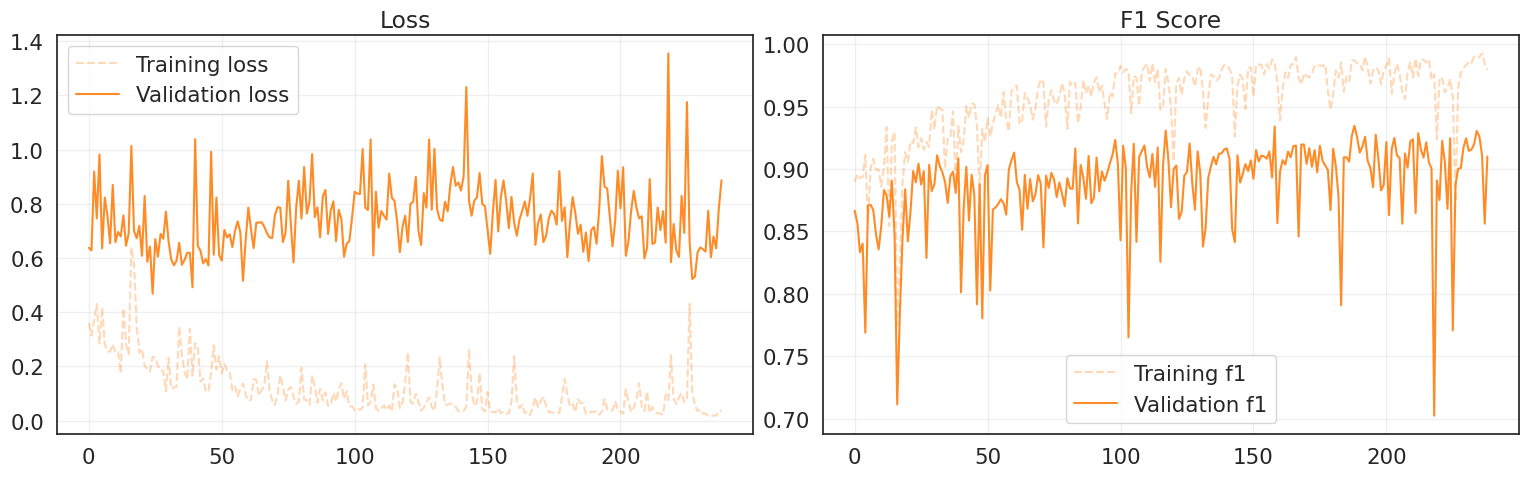

In [70]:
# @title Plot History
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

Accuracy over the validation set: 0.9366
Precision over the validation set: 0.9351
Recall over the validation set: 0.9366
F1 score over the validation set: 0.9346


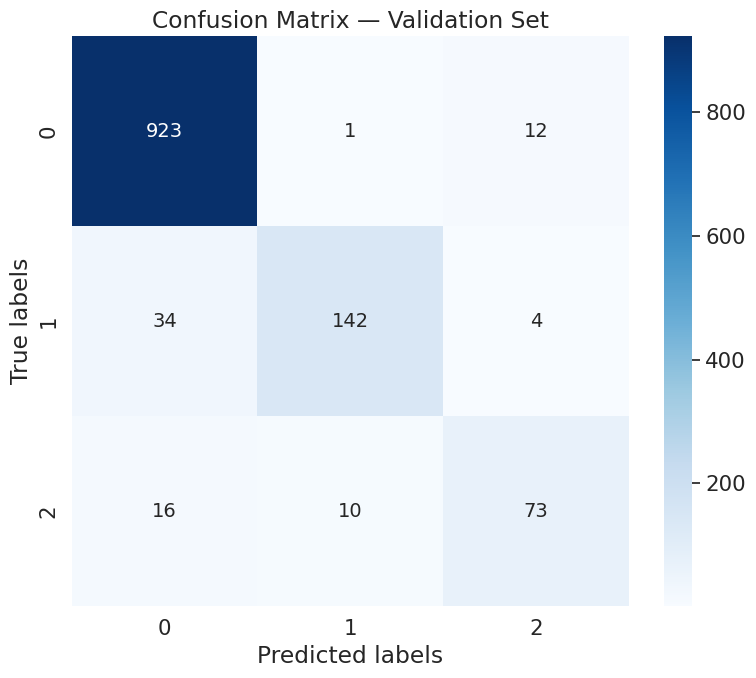

In [71]:
# @title Plot Confusion Matrix
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, x_static_batch, yb in val_loader:
        xb = xb.to(device)
        x_static_batch = x_static_batch.to(device)

        # Forward pass: get model predictions
        logits = rnn_model(xb, x_static_batch)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted', zero_division=0)
val_rec = recall_score(val_targets, val_preds, average='weighted', zero_division=0)
val_f1 = f1_score(val_targets, val_preds, average='weighted', zero_division=0)
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

# CROSS VALIDATION

In [ ]:
# Cross-validation
K = 5                    # Number of splits (5 and 10 are considered good values)
N_VAL_USERS = 135          # Number of users for validation split

# Training
EPOCHS = 500             # Maximum epochs (increase to improve performance)
PATIENCE = 50            # Early stopping patience (increase to improve performance)
VERBOSE = 10             # Print frequency

# Optimisation
LEARNING_RATE = 1e-3     # Learning rate
BATCH_SIZE = 32         # Batch size
WINDOW_SIZE = 60       # Input window size
STRIDE = 20            # Input stride

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 64        # Neurons per layer
RNN_TYPE = 'LSTM'         # Type of RNN architecture
BIDIRECTIONAL = True    # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0.2       # Dropout probability
L1_LAMBDA = 0           # L1 penalty
L2_LAMBDA = 0            # L2 penalty

LABEL_SMOOTHING= 0

# Training utilities
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor, label_smoothing=LABEL_SMOOTHING)

In [ ]:
# @title K-shuffle definition (adapted to the additional layer to divide static & dynamic features)
def k_shuffle_split_cross_validation_round_rnn(df, epochs, criterion, device,
                            k, n_val_users, batch_size, hidden_layers, hidden_size, learning_rate, dropout_rate,
                            window_size, stride, rnn_type, bidirectional,
                            l1_lambda, l2_lambda, patience, evaluation_metric="val_f1", mode='max',
                            restore_best_weights=True, writer=None, verbose=10, seed=42, experiment_name=""):
    """
    Perform K-fold shuffle split cross-validation with user-based splitting for time series data.

    Args:
        df: DataFrame with columns ['sample_index', 'label', 'pain_survey_X', 'n_X', 'joint_XX']
        epochs: Number of training epochs
        criterion: Loss function
        device: torch.device for computation
        k: Number of cross-validation splits
        n_val_users: Number of users for validation set
        batch_size: Batch size for training
        hidden_layers: Number of recurrent layers
        hidden_size: Hidden state dimensionality
        learning_rate: Learning rate for optimizer
        dropout_rate: Dropout rate
        window_size: Length of sliding windows
        stride: Step size for sliding windows
        rnn_type: Type of RNN ('RNN', 'LSTM', 'GRU')
        bidirectional: Whether to use bidirectional RNN
        l1_lambda: L1 regularization coefficient (if used)
        l2_lambda: L2 regularization coefficient (weight_decay)
        patience: Early stopping patience
        evaluation_metric: Metric to monitor for early stopping
        mode: 'max' or 'min' for evaluation metric
        restore_best_weights: Whether to restore best weights after training
        writer: TensorBoard writer
        verbose: Verbosity level
        seed: Random seed
        experiment_name: Name for experiment logging

    Returns:
        fold_losses: Dict with validation losses for each split
        fold_metrics: Dict with validation F1 scores for each split
        best_scores: Dict with best F1 score for each split plus mean and std
    """

    # Initialise containers for results across all splits
    fold_losses = {}
    fold_metrics = {}
    best_scores = {}

    label_col = 'label'
    user_id_col = 'sample_index'

    # Get number of classes from the global df 'label' column
    label_mapping = {
        'no_pain': 0,
        'low_pain': 1,
        'high_pain': 2,
    }
    num_classes = len(label_mapping)

    # Store initial weights to reset model for each split
    # Model is created inside the loop to ensure fresh state for each split
    initial_state = None

    # Iterate through K random splits
    for split_idx in range(k):

        if verbose > 0:
            print(f"Split {split_idx+1}/{k}")

        # Get unique user IDs and shuffle them with split-specific seed
        unique_users = df[user_id_col].unique()
        random.seed(seed + split_idx) # Use seed for reproducibility across splits
        random.shuffle(unique_users)

        # Calculate the number of users for the training set
        n_train_users = len(unique_users) - n_val_users

        # Split the shuffled user IDs into training, validation, and test sets
        train_users = unique_users[:n_train_users]
        val_users = unique_users[n_train_users:n_train_users + n_val_users]

        # Create deep copies for each split to avoid modifying the original df or other splits
        df_train_split = df[df[user_id_col].isin(train_users)].copy()
        df_val_split = df[df[user_id_col].isin(val_users)].copy()

        # Apply label mapping to convert string labels to integers for the current split
        df_train_split['label'] = df_train_split['label'].map(label_mapping)
        df_val_split['label'] = df_val_split['label'].map(label_mapping)

        if verbose > 0:
            print(f"  Training set shape: {df_train_split.shape}")
            print(f"  Validation set shape: {df_val_split.shape}")

        # Dynamically identify feature columns for scaling and sequence building
        all_feature_cols = [col for col in df_train_split.columns if col not in [user_id_col, 'time', label_col]]
        feature_cols_for_sequence = [col for col in df_train_split.columns if col.startswith('joint_')]

        # Normalise features using training set statistics for *this split*
        # Calculate min/max only from the training split of the current fold
        mins = df_train_split[all_feature_cols].min()
        maxs = df_train_split[all_feature_cols].max()

        # Apply normalization and ensure float32 for all numerical feature columns in all splits
        for col in all_feature_cols:
            # Handle potential division by zero if max equals min (constant column)
            divisor = (maxs[col] - mins[col])
            if divisor == 0: # If column is constant, assign 0 (or keep original value, depending on desired behavior)
                df_train_split[col] = 0.0 # Or keep df_train_split[col] as is if it's already a constant
                df_val_split[col] = 0.0
            else:
                df_train_split[col] = ((df_train_split[col] - mins[col]) / divisor).astype(np.float32)
                df_val_split[col] = ((df_val_split[col] - mins[col]) / divisor).astype(np.float32)

        # Build sequences using the modified build_sequences functions
        X_train, y_train_split, seq_ids_train_split = build_sequences(df_train_split, window=window_size, stride=stride, feature_columns_to_extract=feature_cols_for_sequence)
        X_val, y_val_split, seq_ids_val_split = build_sequences(df_val_split, window=window_size, stride=stride, feature_columns_to_extract=feature_cols_for_sequence)

        # Also get static features for this split
        static_cols = ['n_legs', 'n_hands', 'n_eyes']
        static_train_df_split = df_train_split.groupby('sample_index')[static_cols].first().astype(np.float32)
        static_val_df_split   = df_val_split.groupby('sample_index')[static_cols].first().astype(np.float32)

        X_train_static = build_static_array_from_seq_ids(seq_ids_train_split, static_train_df_split)
        X_val_static   = build_static_array_from_seq_ids(seq_ids_val_split, static_val_df_split)


        if verbose > 0:
            print(f"  Training sequences shape: {X_train.shape}")
            print(f"  Validation sequences shape: {X_val.shape}")
            # Note: There is no X_test processing within this CV function currently

        # Create PyTorch datasets
        train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(X_train_static), torch.from_numpy(y_train_split)) # Using y_train_split
        val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(X_val_static), torch.from_numpy(y_val_split)) # Using y_val_split

        # Create data loaders
        train_loader = make_loader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
        val_loader   = make_loader(val_ds, batch_size=batch_size, shuffle=False, drop_last=False)

        # The input size for the RNN is the number of features in the sequences
        rnn_input_size = len(feature_cols_for_sequence)

        # Initialise model inside the loop to ensure fresh state for each split
        model = RecurrentClassifier(
            input_size=rnn_input_size,
            hidden_size=hidden_size,
            num_layers=hidden_layers,
            num_classes=num_classes,
            dropout_rate=dropout_rate,
            bidirectional=bidirectional,
            rnn_type=rnn_type,
            static_size=X_train_static.shape[1]
        ).to(device)

        # Calculate class weights for this split's training data
        split_class_labels = np.unique(y_train_split)
        split_class_weights_np = compute_class_weight(
            class_weight='balanced',
            classes=split_class_labels,
            y=y_train_split
        )
        split_class_weights_tensor = torch.tensor(split_class_weights_np, dtype=torch.float32).to(device)

        # Define criterion for this split with calculated weights
        split_criterion = nn.CrossEntropyLoss(weight=split_class_weights_tensor, label_smoothing=LABEL_SMOOTHING)

        # Define optimizer with L2 regularization
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

        # Enable mixed precision training for GPU acceleration
        split_scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

        # Create directory for model checkpoints
        os.makedirs(f"models/{experiment_name}", exist_ok=True)

        # Train model on current split
        model, training_history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=epochs,
            criterion=split_criterion, # Pass the split-specific criterion
            optimizer=optimizer,
            scaler=split_scaler,
            device=device,
            writer=writer,
            patience=patience,
            verbose=verbose,
            l1_lambda=l1_lambda,
            evaluation_metric=evaluation_metric,
            mode=mode,
            restore_best_weights=restore_best_weights,
            experiment_name=experiment_name+"/split_"+str(split_idx)
        )

        # Store results for this split
        # Store the entire history for plotting purposes
        fold_losses[f"split_{split_idx}"] = training_history['val_loss']
        fold_metrics[f"split_{split_idx}"] = training_history['val_f1']

        # Also store the best single F1 score for mean/std calculation
        best_val_f1_in_split = max(training_history['val_f1'])
        # The best_val_loss_in_split is derived from the F1, we just need to ensure 'best_scores' gets the float
        best_scores[f"split_{split_idx}"] = best_val_f1_in_split

    # Compute mean and standard deviation of best scores across splits
    best_scores["mean"] = np.mean([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])
    best_scores["std"] = np.std([best_scores[k] for k in best_scores.keys() if k.startswith("split_")])

    if verbose > 0:
        print(f"Best score: {best_scores['mean']:.4f}\u00b1{best_scores['std']:.4f}")

    return fold_losses, fold_metrics, best_scores

In [ ]:
# @title Training with k-fold
%%time
# Execute K-fold cross-validation with baseline configuration
losses, metrics, best_scores = k_shuffle_split_cross_validation_round_rnn(
    df=df,
    epochs=EPOCHS,
    criterion=criterion,
    device=device,
    k=K,
    batch_size=BATCH_SIZE,
    hidden_layers=HIDDEN_LAYERS,
    hidden_size=HIDDEN_SIZE,
    learning_rate=LEARNING_RATE,
    dropout_rate=DROPOUT_RATE,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    verbose=VERBOSE,
    patience=PATIENCE,
    seed=SEED,
    experiment_name="gru_baseline",
    n_val_users=N_VAL_USERS,
    window_size=WINDOW_SIZE,
    stride=STRIDE,
    rnn_type=RNN_TYPE,
    bidirectional=BIDIRECTIONAL
)

Split 1/5
  Training set shape: (84160, 40)
  Validation set shape: (21600, 40)
  Training sequences shape: (2630, 80, 30)
  Validation sequences shape: (675, 80, 30)
Training 500 epochs...
Epoch   1/500 | Train: Loss=0.7238, F1 Score=0.6676 | Val: Loss=0.6748, F1 Score=0.6704
Epoch  10/500 | Train: Loss=0.3681, F1 Score=0.8526 | Val: Loss=0.5577, F1 Score=0.8079
Epoch  20/500 | Train: Loss=0.2805, F1 Score=0.9007 | Val: Loss=0.5143, F1 Score=0.8308
Epoch  30/500 | Train: Loss=0.1544, F1 Score=0.9449 | Val: Loss=0.4888, F1 Score=0.8434
Epoch  40/500 | Train: Loss=0.2483, F1 Score=0.9176 | Val: Loss=0.4847, F1 Score=0.8359
Epoch  50/500 | Train: Loss=0.1825, F1 Score=0.9370 | Val: Loss=0.4709, F1 Score=0.8371
Epoch  60/500 | Train: Loss=0.0932, F1 Score=0.9689 | Val: Loss=0.4295, F1 Score=0.8871
Epoch  70/500 | Train: Loss=0.0848, F1 Score=0.9710 | Val: Loss=0.5244, F1 Score=0.8695
Epoch  80/500 | Train: Loss=0.0652, F1 Score=0.9767 | Val: Loss=0.4221, F1 Score=0.9033
Epoch  90/500 | Tr

In [ ]:
import shutil

# Assuming 'best_scores' and 'experiment_name' (from k-fold) are available
# 'best_scores' is a dictionary containing F1 scores for each split and their mean/std.
# 'experiment_name' for k-fold was 'gru_baseline'.

# Find the split with the highest F1 score
overall_best_f1_kfold = -1.0
best_split_index_kfold = -1

for i in range(K): # K is the number of splits from the cross-validation setup
    current_split_f1 = best_scores[f'split_{i}']
    if current_split_f1 > overall_best_f1_kfold:
        overall_best_f1_kfold = current_split_f1
        best_split_index_kfold = i

# Define the source path for the best model from the best split
source_model_filename = f"gru_baseline/split_{best_split_index_kfold}_model.pt"
source_model_path = os.path.join("models", source_model_filename)

# Define the destination path for the overall best model
destination_model_filename = f"best_kfold_model_f1_{overall_best_f1_kfold:.4f}.pt"
destination_model_path = os.path.join("models", destination_model_filename)

# Ensure the source model file exists before copying
if os.path.exists(source_model_path):
    # Copy the best model from the best split to a new, descriptive filename
    shutil.copyfile(source_model_path, destination_model_path)
    print(f"Overall best K-fold model (F1: {overall_best_f1_kfold:.4f} from split {best_split_index_kfold}) saved to: {destination_model_path}")
else:
    print(f"Error: Best model for split {best_split_index_kfold} not found at {source_model_path}")
    print("Please ensure the K-fold cross-validation training was executed successfully.")

# Update the best_performance variable for consistency if desired
best_performance = overall_best_f1_kfold


Overall best K-fold model (F1: 0.9324 from split 0) saved to: models/best_kfold_model_f1_0.9324.pt


In [ ]:
# Create an inverse mapping from numeric labels back to string labels
inverse_label_mapping = {
    0: 'no_pain',
    1: 'low_pain',
    2: 'high_pain'
}

# The `test_ds` should already be defined correctly in n4g715TtSytf:
# test_ds = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(X_test_static).float())
# We don't redefine test_ds here.

# Create DataLoader for the test set (using the already defined test_ds)
test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

# --- Load the best K-fold model ---
# The path to the best K-fold model was saved in the previous cell
best_kfold_model_path = destination_model_path # From the previous cell 9UQK2Wls-7BZ

# Instantiate a new model with the architecture used for the best K-fold run
# Parameters should match the best performing config from k-fold, which were set globally for the k-fold run
# (HIDDEN_SIZE, HIDDEN_LAYERS, RNN_TYPE='GRU', BIDIRECTIONAL=True)
model_for_prediction = RecurrentClassifier(
    input_size=len(actual_joint_columns_global), # Use the dynamically determined number of joint features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes, # Use the globally available num_classes
    dropout_rate=DROPOUT_RATE,
    bidirectional=BIDIRECTIONAL,
    rnn_type=RNN_TYPE, # Use the RNN_TYPE (GRU) that performed best in K-fold
    static_size=X_test_static.shape[1] # Pass static_size here
).to(device)

# Load the state dictionary of the best K-fold model
model_for_prediction.load_state_dict(torch.load(best_kfold_model_path, map_location=device))
model_for_prediction.eval() # Set the loaded model to evaluation mode

all_test_predictions = []
# The seq_ids_test array generated by build_sequences already maps sequence predictions to sample_index.
# We will use this directly for grouping after predictions.

# Perform inference on the test set using the loaded best K-fold model
with torch.no_grad():
    for inputs_batch, static_inputs_batch in test_loader: # Unpack inputs and static_inputs
        inputs_batch = inputs_batch.to(device)
        static_inputs_batch = static_inputs_batch.to(device) # Move static inputs to device

        # Get model outputs
        outputs = model_for_prediction(inputs_batch, static_inputs_batch) # Pass both inputs

        # Get predicted class (the one with the highest probability)
        predictions = outputs.argmax(dim=1).cpu().numpy()

        all_test_predictions.extend(predictions)

# Combine seq_ids_test and predictions into a DataFrame
predictions_df = pd.DataFrame({
    'sample_index': seq_ids_test, # Use the global seq_ids_test array
    'predicted_label_numeric': all_test_predictions
})

# Group by sample_index and determine the final prediction (e.g., by taking the mode)
# Using pandas Series.mode() which is typically more robust for Series.
# Add a check for empty group to avoid IndexError.
final_predictions_grouped = predictions_df.groupby('sample_index')['predicted_label_numeric'].apply(
    lambda x: x.mode()[0] if not x.empty else np.nan # If a group is empty, assign NaN
)
final_predictions_df = final_predictions_grouped.reset_index()
final_predictions_df.columns = ['sample_index', 'predicted_label_numeric']

# Map numeric predictions back to string labels
final_predictions_df['predicted_label'] = final_predictions_df['predicted_label_numeric'].map(inverse_label_mapping)

# Define the output filename
output_filename = 'pirate_pain_predictions.csv'

# Save the DataFrame to a CSV file
final_predictions_df[['sample_index', 'predicted_label']].to_csv(output_filename, index=False)

print(f"Predictions saved to {output_filename}")
display(final_predictions_df.head())

# The file is already saved to Google Drive because the current working directory
# is set to '/gdrive/My Drive/Challenge1-Datasets'. No need to copy it again.
print(f"File '{output_filename}' is already saved to Google Drive at '{current_dir}/{output_filename}'")

NameError: name 'make_loader' is not defined

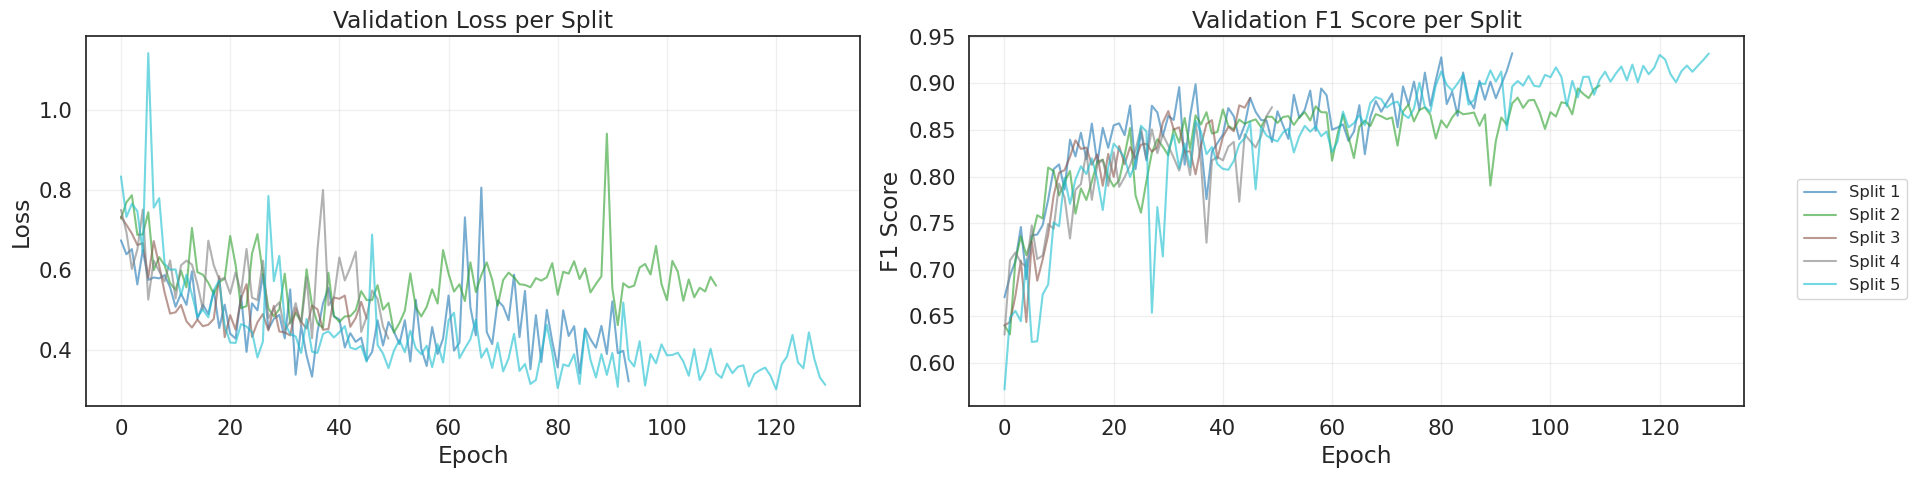

In [ ]:
# @title Plot History
# Create figure with two subplots sharing x axis
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 5), sharex=True)

# Color palette for K splits
colors = plt.cm.get_cmap('tab10', K)

# Plot validation loss for each split
for split in range(K):
    axes[0].plot(losses[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[0].set_title('Validation Loss per Split')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].grid(alpha=0.3)

# Plot validation F1 score for each split
for split in range(K):
    axes[1].plot(metrics[f'split_{split}'][:-PATIENCE], label=f'Split {split+1}',
                 color=colors(split), alpha=0.6)
axes[1].set_title('Validation F1 Score per Split')
axes[1].set_ylabel('F1 Score')
axes[1].set_xlabel('Epoch')
axes[1].grid(alpha=0.3)

# Add shared legend on the right
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(right=0.975)
plt.show()

In [ ]:
# @title Plot Confusion Matrix for Best K-fold Validation Set
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Re-create the validation data for the best performing split
label_col = 'label'
user_id_col = 'sample_index'
label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2,
}
# num_classes should be available globally, but we can re-derive it safely
num_classes_derived = len(label_mapping)

# Re-run the user splitting logic for the best split
unique_users = df[user_id_col].unique()
random.seed(SEED + best_split_index_kfold) # Use the same seed as that split
random.shuffle(unique_users)

n_train_users_best_split = len(unique_users) - N_VAL_USERS
train_users_best_split = unique_users[:n_train_users_best_split]
val_users_best_split = unique_users[n_train_users_best_split:n_train_users_best_split + N_VAL_USERS]

df_train_split_best = df[df[user_id_col].isin(train_users_best_split)].copy()
df_val_split_best = df[df[user_id_col].isin(val_users_best_split)].copy()

# Apply label mapping
df_train_split_best['label'] = df_train_split_best['label'].map(label_mapping)
df_val_split_best['label'] = df_val_split_best['label'].map(label_mapping)

# Dynamically identify feature columns for scaling and sequence building for this split
all_feature_cols_best_split = [col for col in df_train_split_best.columns if col not in [user_id_col, 'time', label_col]]
feature_cols_for_sequence_best_split = [col for col in df_train_split_best.columns if col.startswith('joint_')]

# Normalize features using training set statistics for this specific split
mins_best_split = df_train_split_best[all_feature_cols_best_split].min()
maxs_best_split = df_train_split_best[all_feature_cols_best_split].max()

for col in all_feature_cols_best_split:
    divisor = (maxs_best_split[col] - mins_best_split[col])
    if divisor == 0: # If column is constant, assign 0.0 for consistent typing
        df_train_split_best[col] = 0.0
        df_val_split_best[col] = 0.0
    else:
        df_train_split_best[col] = ((df_train_split_best[col] - mins_best_split[col]) / divisor).astype(np.float32)
        df_val_split_best[col] = ((df_val_split_best[col] - mins_best_split[col]) / divisor).astype(np.float32)

# Build sequences for validation set of best split
X_val_best_split, y_val_best_split, seq_ids_val_best_split = build_sequences(
    df_val_split_best, WINDOW_SIZE, STRIDE, feature_columns_to_extract=feature_cols_for_sequence_best_split
)

# Get static features for this split
static_cols = ['n_legs', 'n_hands', 'n_eyes']
static_val_df_best = df_val_split_best.groupby('sample_index')[static_cols].first().astype(np.float32)
X_val_static_best_split = build_static_array_from_seq_ids(seq_ids_val_best_split, static_val_df_best)

# Create DataLoader for the validation set of the best split
val_ds_best_split = TensorDataset(torch.from_numpy(X_val_best_split), torch.from_numpy(X_val_static_best_split), torch.from_numpy(y_val_best_split))
val_loader_best_split = make_loader(val_ds_best_split, BATCH_SIZE, shuffle=False, drop_last=False)

# Load the best K-fold model (destination_model_path should be available from earlier execution)
model_for_conf_matrix = RecurrentClassifier(
    input_size=len(feature_cols_for_sequence_best_split), # Use the dynamically determined number of joint features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes_derived,
    dropout_rate=DROPOUT_RATE,
    bidirectional=BIDIRECTIONAL,
    rnn_type=RNN_TYPE,
    static_size=X_val_static_best_split.shape[1]
).to(device)

model_for_conf_matrix.load_state_dict(torch.load(destination_model_path, map_location=device))
model_for_conf_matrix.eval()

# Collect predictions and ground truth labels for the best split's validation set
val_preds_best_split, val_targets_best_split = [], []
with torch.no_grad():
    for xb, x_static_batch, yb in val_loader_best_split:
        xb = xb.to(device)
        x_static_batch = x_static_batch.to(device)
        logits = model_for_conf_matrix(xb, x_static_batch)
        preds = logits.argmax(dim=1).cpu().numpy()
        val_preds_best_split.append(preds)
        val_targets_best_split.append(yb.numpy())

val_preds_best_split = np.concatenate(val_preds_best_split)
val_targets_best_split = np.concatenate(val_targets_best_split)

# Calculate overall validation metrics for this split
val_acc = accuracy_score(val_targets_best_split, val_preds_best_split)
val_prec = precision_score(val_targets_best_split, val_preds_best_split, average='weighted', zero_division=0)
val_rec = recall_score(val_targets_best_split, val_preds_best_split, average='weighted', zero_division=0)
val_f1 = f1_score(val_targets_best_split, val_preds_best_split, average='weighted', zero_division=0)
print(f"Metrics for Validation Set of Best K-fold Split (Fold {best_split_index_kfold+1}):")
print(f"Accuracy: {val_acc:.4f}")
print(f"Precision: {val_prec:.4f}")
print(f"Recall: {val_rec:.4f}")
print(f"F1 score: {val_f1:.4f}")

# Generate confusion matrix
cm_best_split = confusion_matrix(val_targets_best_split, val_preds_best_split)

# Map numeric labels back to string labels for better readability in the plot
inverse_label_mapping = {0: 'no_pain', 1: 'low_pain', 2: 'high_pain'}
class_labels = [inverse_label_mapping[i] for i in sorted(inverse_label_mapping.keys())]

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm_best_split, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels
           )
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix — Validation Set (Best K-fold Split Fold {best_split_index_kfold+1})')
plt.tight_layout()
plt.show()

NameError: name 'best_split_index_kfold' is not defined

# HYPERPARAMETER TUNING

In [ ]:
def grid_search_cv_rnn(df, param_grid, fixed_params, cv_params, verbose=True):
    """
    Execute grid search with K-shuffle-split cross-validation for RNN models on time series data.

    Args:
        df: DataFrame with columns ['user_id', 'activity', 'x_axis', 'y_axis', 'z_axis', 'id']
        param_grid: Dict of parameters to test, e.g. {'batch_size': [16, 32], 'rnn_type': ['LSTM', 'GRU']}
        fixed_params: Dict of fixed hyperparameters (hidden_size, learning_rate, window_size, stride, etc.)
        cv_params: Dict of CV settings (epochs, k, patience, criterion, scaler, device, etc.)
        verbose: Print progress for each configuration

    Returns:
        results: Dict with scores for each configuration
        best_config: Dict with best hyperparameter combination
        best_score: Best mean F1 score achieved
    """
    # Generate all parameter combinations
    param_names = list(param_grid.keys())
    param_values = list(param_grid.values())
    combinations = list(product(*param_values))

    results = {}
    best_score = -np.inf
    best_config = None

    total = len(combinations)

    for idx, combo in enumerate(combinations, 1):
        # Create current configuration dict
        current_config = dict(zip(param_names, combo))
        config_str = "_".join([f"{k}_{v}" for k, v in current_config.items()])

        if verbose:
            print(f"\nConfiguration {idx}/{total}:")
            for param, value in current_config.items():
                print(f"  {param}: {value}")

        # Merge current config with fixed parameters
        run_params = {**fixed_params, **current_config}

        # Execute cross-validation
        _, _, fold_scores = k_shuffle_split_cross_validation_round_rnn(
            df=df,
            experiment_name=config_str,
            **run_params,
            **cv_params
        )

        # Store results
        results[config_str] = fold_scores

        # Track best configuration
        if fold_scores["mean"] > best_score:
            best_score = fold_scores["mean"]
            best_config = current_config.copy()
            if verbose:
                print("  NEW BEST SCORE!")

        if verbose:
            print(f"  F1 Score: {fold_scores['mean']:.4f}±{fold_scores['std']:.4f}")

    return results, best_config, best_score


def plot_top_configurations_rnn(results, k_splits, top_n=5, figsize=(14, 7)):
    """
    Visualise top N RNN configurations with boxplots of F1 scores across CV splits.

    Args:
        results: Dict of results from grid_search_cv_rnn
        k_splits: Number of CV splits used
        top_n: Number of top configurations to display
        figsize: Figure size tuple
    """
    # Sort by mean score
    config_scores = {name: data['mean'] for name, data in results.items()}
    sorted_configs = sorted(config_scores.items(), key=lambda x: x[1], reverse=True)

    # Select top N
    top_configs = sorted_configs[:min(top_n, len(sorted_configs))]

    # Prepare boxplot data
    boxplot_data = []
    labels = []

    # Define a dictionary for replacements, ordered to handle prefixes correctly
    replacements = {
        'batch_size_': 'BS=',
        'learning_rate_': '\nLR=',
        'hidden_layers_': '\nHL=',
        'hidden_size_': '\nHS=',
        'dropout_rate_': '\nDR=',
        'window_size_': '\nWS=',
        'stride_': '\nSTR=',
        'rnn_type_': '\nRNN=',
        'bidirectional_': '\nBIDIR=',
        'l1_lambda_': '\nL1=',
        'l2_lambda_': '\nL2='
    }

    # Replacements for separators
    separator_replacements = {
        '_learning_rate_': '\nLR=',
        '_hidden_layers_': '\nHL=',
        '_hidden_size_': '\nHS=',
        '_dropout_rate_': '\nDR=',
        '_window_size_': '\nWS=',
        '_stride_': '\nSTR=',
        '_rnn_type_': '\nRNN=',
        '_bidirectional_': '\nBIDIR=',
        '_l1_lambda_': '\nL1=',
        '_l2_lambda_': '\nL2=',
        '_': ''
    }

    for config_name, mean_score in top_configs:
        # Extract best score from each split (auto-detect number of splits)
        split_scores = []
        for i in range(k_splits):
            if f'split_{i}' in results[config_name]:
                split_scores.append(results[config_name][f'split_{i}'])
        boxplot_data.append(split_scores)

        # Verify we have the expected number of splits
        if len(split_scores) != k_splits:
            print(f"Warning: Config {config_name} has {len(split_scores)} splits, expected {k_splits}")

        # Create readable label using the replacements dictionary
        readable_label = config_name
        for old, new in replacements.items():
            readable_label = readable_label.replace(old, new)

        # Apply separator replacements
        for old, new in separator_replacements.items():
             readable_label = readable_label.replace(old, new)

        labels.append(f"{readable_label}\n(μ={mean_score:.3f})")

    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    bp = ax.boxplot(boxplot_data, labels=labels, patch_artist=True,
                    showmeans=True, meanline=True)

    # Styling
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)

    # Highlight best configuration
    ax.get_xticklabels()[0].set_fontweight('bold')

    ax.set_ylabel('F1 Score')
    ax.set_xlabel('Configuration')
    ax.set_title(f'Top {len(top_configs)} RNN Configurations - F1 Score Distribution Across {k_splits} Splits')
    ax.grid(alpha=0.3, axis='y')

    plt.xticks(rotation=0, ha='center')
    plt.tight_layout()
    plt.show()

In [ ]:
# @title Grid search
%%time
# Define parameters to search
param_grid = {
    'window_size': [60, 90],
    'stride': [10, 15, 30],
}

# Fixed hyperparameters (not being tuned)
fixed_params = {
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'hidden_layers': HIDDEN_LAYERS,
    'hidden_size': HIDDEN_SIZE,
    'dropout_rate': DROPOUT_RATE,
    'l1_lambda': L1_LAMBDA,
    'l2_lambda': L2_LAMBDA,
    'rnn_type': RNN_TYPE,
    'bidirectional': BIDIRECTIONAL
}

# Cross-validation settings
cv_params = {
    'epochs': EPOCHS,
    'criterion': criterion,
    'device': device,
    'k': K,
    'n_val_users': N_VAL_USERS,
    'patience': PATIENCE,
    'verbose': 0,
    'seed': SEED
}

# Execute search
results, best_config, best_score = grid_search_cv_rnn(
    df=df,
    param_grid=param_grid,
    fixed_params=fixed_params,
    cv_params=cv_params
)


Configuration 1/6:
  window_size: 60
  stride: 10
Training 500 epochs...


In [ ]:
# Visualise results
plot_top_configurations_rnn(results, k_splits=K, top_n=5)

In [ ]:
# %%time
# --- 1. Combine fixed and best hyperparameters ---
# 'fixed_params' and 'best_config' are loaded from the grid search cell
final_best_params = {**fixed_params, **best_config}

# Generate config string (from grid params only) to find saved model files
best_config_str = "_".join([f"{k}_{v}" for k, v in best_config.items()])

# Initialise lists for metrics
test_accuracies = []
test_precisions = []
test_recall_scores = []
test_f1_scores = []
all_test_targets = [] # For aggregated confusion matrix
all_test_preds = []   # For aggregated confusion matrix

label_mapping = {
    'Walking': 0, 'Jogging': 1, 'Upstairs': 2,
    'Downstairs': 3, 'Sitting': 4, 'Standing': 5
}
scale_columns = ['x_axis', 'y_axis', 'z_axis']

# --- 2. Begin evaluation loop across the K splits ---
# K, SEED, N_VAL_USERS, N_TEST_USERS are defined globally
for split in range(K):
    print(f"Evaluating Split {split+1}/{K} using best config: {best_config_str}")

    # --- 3. Regenerate the exact data split for this fold ---
    # This logic must be identical to k_shuffle_split_cross_validation_round_rnn
    unique_users = df['user_id'].unique()
    random.seed(SEED + split) # Use the same CV seed
    random.shuffle(unique_users)

    n_train_users = len(unique_users) - N_VAL_USERS - N_TEST_USERS
    train_users = unique_users[:n_train_users]
    val_users = unique_users[n_train_users:n_train_users + N_VAL_USERS]
    test_users = unique_users[n_train_users + N_VAL_USERS:]

    df_train = df[df['user_id'].isin(train_users)].copy()
    df_test = df[df['user_id'].isin(test_users)].copy()

    # --- 4. Preprocess the data ---
    df_train['activity'] = df_train['activity'].map(label_mapping)
    df_test['activity'] = df_test['activity'].map(label_mapping)

    # Normalise features (fit on THIS split's training data)
    mins = df_train[scale_columns].min()
    maxs = df_train[scale_columns].max()

    for column in scale_columns:
        df_test[column] = (df_test[column] - mins[column]) / (maxs[column] - mins[column] + 1e-8)

    # --- 5. Build test sequences ---
    # Use the best window/stride from final_best_params
    X_test, y_test = build_sequences(
        df_test,
        window=final_best_params['window_size'],
        stride=final_best_params['stride']
    )

    # --- 6. Create the Test DataLoader ---
    test_ds  = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
    test_loader  = make_loader(
        test_ds,
        batch_size=final_best_params['batch_size'],
        shuffle=False,
        drop_last=False
    )

    # Handle empty test sets from user splits
    if len(test_ds) == 0:
        print(f"  WARNING: Test set for split {split+1} is empty. Skipping.")
        continue

    # --- 7. Initialise the Model ---
    # Use the best architecture parameters from the grid search
    model = RecurrentClassifier(
        input_size=X_test.shape[2], # num_features (3)
        hidden_size=final_best_params['hidden_size'],
        num_layers=final_best_params['hidden_layers'],
        num_classes=len(label_mapping), # num_classes (6)
        dropout_rate=final_best_params['dropout_rate'],
        bidirectional=final_best_params['bidirectional'],
        rnn_type=final_best_params['rnn_type']
    ).to(device)

    # --- 8. Load the model weights for this specific split and config ---
    model_path = f"models/{best_config_str}/split_{split}_model.pt"

    try:
        model.load_state_dict(torch.load(model_path, map_location=device))
    except FileNotFoundError:
        print(f"  ERROR: Model file not found at {model_path}")
        print(f"  Skipping split {split+1}.")
        continue

    model.eval() # Set model to evaluation mode

    # --- 9. Run predictions on the test set ---
    split_test_preds, split_test_targets = [], []
    with torch.no_grad(): # Disable gradient computation for inference
        for xb, yb in test_loader:
            xb = xb.to(device)
            logits = model(xb)
            preds = logits.argmax(dim=1).cpu().numpy()
            split_test_preds.append(preds)
            split_test_targets.append(yb.numpy())

    split_test_preds = np.concatenate(split_test_preds)
    split_test_targets = np.concatenate(split_test_targets)

    # --- 10. Calculate and store metrics for this split ---
    split_test_acc = accuracy_score(split_test_targets, split_test_preds)
    split_test_prec = precision_score(split_test_targets, split_test_preds, average='weighted', zero_division=0)
    split_test_rec = recall_score(split_test_targets, split_test_preds, average='weighted', zero_division=0)
    split_test_f1 = f1_score(split_test_targets, split_test_preds, average='weighted', zero_division=0)

    print(f"  Test F1 Score for Split {split+1}: {split_test_f1:.4f}")

    test_accuracies.append(split_test_acc)
    test_precisions.append(split_test_prec)
    test_recall_scores.append(split_test_rec)
    test_f1_scores.append(split_test_f1)

    all_test_targets.extend(split_test_targets)
    all_test_preds.extend(split_test_preds)


# --- 11. After the loop: Print mean metrics and plot confusion matrix ---
print("\nAverage metrics across all splits on the test set:")
print(f"Mean Accuracy: {np.mean(test_accuracies):.4f} ± {np.std(test_accuracies):.4f}")
print(f"Mean Precision: {np.mean(test_precisions):.4f} ± {np.std(test_precisions):.4f}")
print(f"Mean Recall: {np.mean(test_recall_scores):.4f} ± {np.std(test_recall_scores):.4f}")
print(f"Mean F1 score: {np.mean(test_f1_scores):.4f} ± {np.std(test_f1_scores):.4f}")


# Generate confusion matrix for the concatenated test sets
cm = confusion_matrix(all_test_targets, all_test_preds)
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Aggregated Confusion Matrix — Test Sets Across Splits')
plt.tight_layout()
plt.show()

The end